In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import visual_behavior.data_access.loading as loading
import visual_behavior.data_access.utilities as utilities

import visual_behavior.visualization.utils as utils

experience_level_colors = utils.get_experience_level_colors()
cre_line_colors = utils.get_cre_line_colors()

experience_levels = utils.get_new_experience_levels()
cell_types = utils.get_cell_types()

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 1})

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

import visual_behavior.visualization.ophys.glm_example_plots as gep
import visual_behavior.visualization.ophys.platform_paper_figures as ppf



C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [4]:
import visual_behavior_glm.GLM_visualization_tools as gvt

#### Where to save figures

In [5]:
save_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_figures_final\figure_3'

folder = 'glm_plots'

### Load from saved files

In [6]:
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

platform_cache_dir = loading.get_platform_analysis_cache_dir()
print(platform_cache_dir)

cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir = platform_cache_dir)
experiments_table = cache.get_ophys_experiment_table()
print(len(experiments_table))

\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new
1936


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [7]:
# metadata tables
experiments_table = pd.read_csv(os.path.join(platform_cache_dir, 'all_ophys_experiments_table.csv'), index_col=0)
platform_experiments = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_ophys_experiments_table.csv'), index_col=0)
platform_cells_table = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_ophys_cells_table.csv'), index_col=0)
matched_cells_table = pd.read_csv(os.path.join(platform_cache_dir, 'platform_paper_matched_ophys_cells_table.csv'), index_col=0)

### Define model version
glm_version = '24_events_all_L2_optimize_by_session'
 
# glm outputs
run_params = pd.read_pickle(os.path.join(platform_cache_dir, 'glm_results', glm_version+'_run_params.pkl'))
all_weights_df = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'weights_df.h5'), key='df')
all_results = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'all_results.h5'), key='df')
all_results_pivoted = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'results_pivoted.h5'), key='df')

# split out csid and oeid for results table
all_results['cell_specimen_id'] = [int(identifier.split('_')[1]) for identifier in all_results.identifier.values]
all_results['ophys_experiment_id'] = [int(identifier.split('_')[0]) for identifier in all_results.identifier.values]

# get results and weights just for platform paper experiments
results_pivoted = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'platform_results_pivoted.h5'), key='df')
weights_df = pd.read_hdf(os.path.join(platform_cache_dir, 'glm_results', 'platform_results_weights_df.h5'), key='df')

# get lists of matched cells and expts
matched_cells = matched_cells_table.cell_specimen_id.unique()
matched_experiments = matched_cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(platform_cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, platform_experiments)

In [8]:
# confirm that filtered platform experiments and matched cells table have the same number of experiments
print(len(platform_cells_table.cell_specimen_id.unique()))
print(len(matched_cells_table.cell_specimen_id.unique()))

14495
3921


In [9]:
# confirm that filtered platform experiments and matched cells table have the same number of experiments
print(len(platform_experiments))
print(len(platform_cells_table.ophys_experiment_id.unique()))

402
402


In [10]:
# confirm that filtered platform experiments and matched cells table have the same number of experiments
print(len(results_pivoted.cell_specimen_id.unique()))
print(len(results_pivoted.ophys_experiment_id.unique()))

14495
402


In [11]:
print(platform_cells_table.experience_level.unique())
print(results_pivoted.experience_level.unique())

['Familiar' 'Novel' 'Novel +']
['Familiar' 'Novel' 'Novel +']


### Plot timeseries, kernels, and cell fit examples 

#### timeseries + kernel durations plots

In [12]:
ophys_experiment_id = 808621034

dataset = loading.get_ophys_dataset(ophys_experiment_id)

trials = dataset.trials.copy()
start_times = trials[trials.is_change].start_time.values
start_time = start_times[10]


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\data_access\loading.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_presentations[column] = stimulus_presentations[column].astype('bool')
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\data_access\loading.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_presentations[column] = stimulus_presentations[column].astype('bool')
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visua

saving


array([<Axes: title={'center': '425496_808621034_Slc17a7_VISp_175_OPHYS_4_images_B'}>,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: ylabel='running\nspeed\n(cm/s)'>,
       <Axes: ylabel='pupil\ndiameter\n(pixels)'>, <Axes: ylabel='licks'>,
       <Axes: xlabel='time in session (seconds)', ylabel='rewards'>],
      dtype=object)

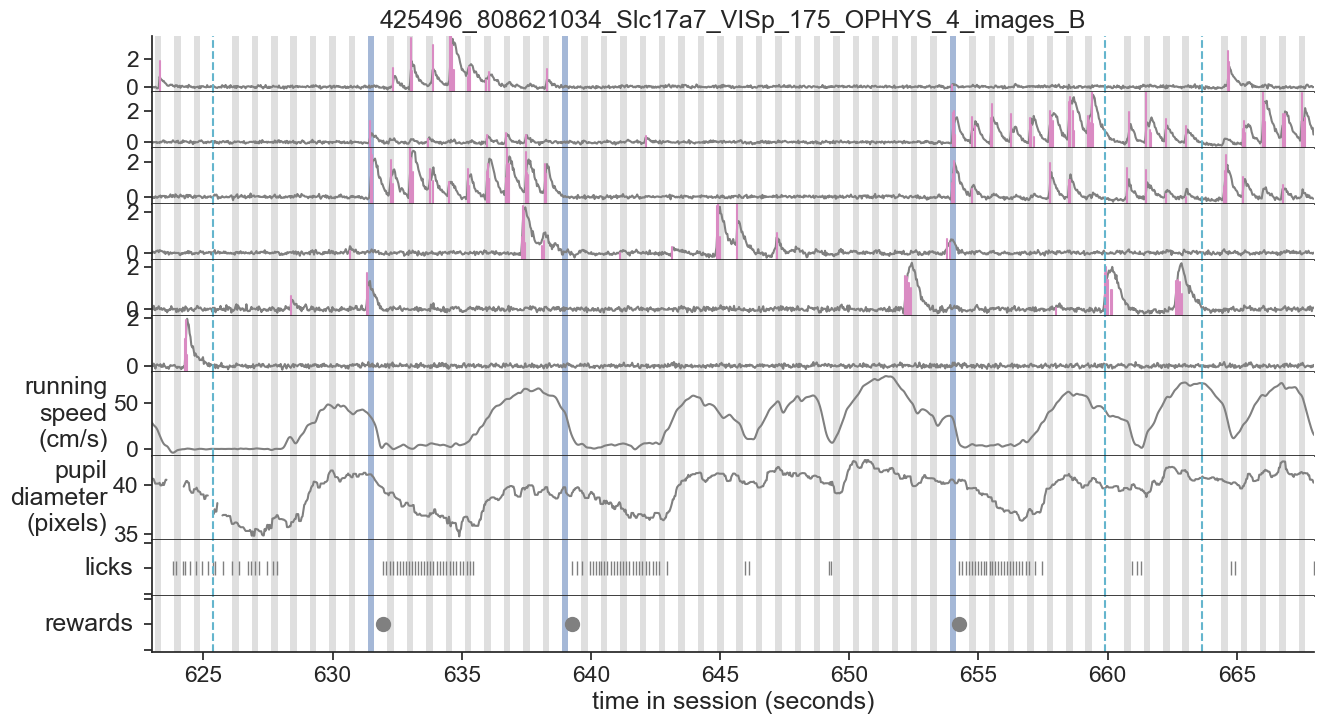

In [13]:
ppf.plot_behavior_and_physio_timeseries_stacked(dataset, start_time=628, duration_seconds=20, save_dir=save_dir, ax=None)

C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\data_access\loading.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_presentations[column] = stimulus_presentations[column].astype('bool')
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\data_access\loading.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_presentations[column] = stimulus_presentations[column].astype('bool')
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visua

array([<Axes: >, <Axes: ylabel='image 1'>, <Axes: ylabel='image 2'>,
       <Axes: ylabel='image 3'>, <Axes: ylabel='omissions'>,
       <Axes: ylabel='hits'>, <Axes: ylabel='misses'>,
       <Axes: ylabel='licks'>, <Axes: ylabel='running'>,
       <Axes: xlabel='Time in session (seconds)', ylabel='pupil'>],
      dtype=object)

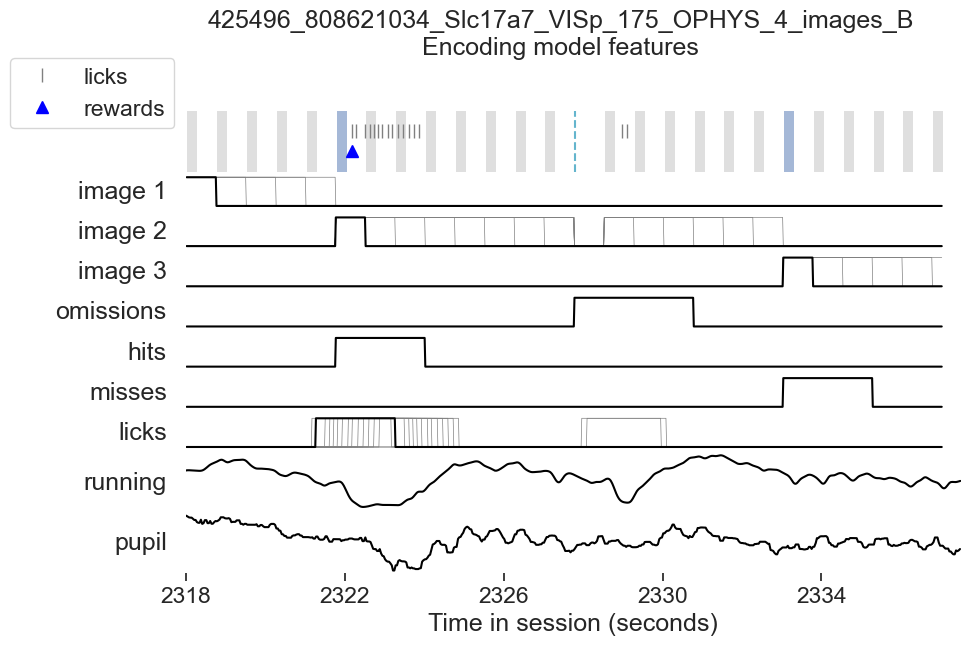

In [14]:
start_time = 2318 #1500, 1450, 2550, 2320
duration_seconds = 19.5

gep.plot_behavior_timeseries_and_GLM_kernel_activations(dataset, start_time, duration_seconds, save_dir=None)


## GLM model fits

### Plot model fits

#### Create model fit + timeseries plot for the original cell 

In [15]:
# reproduce Alex's exact figure
ophys_experiment_id = 967008471
cell_specimen_id = 1086492467
times = [1789, 1799]


# load dataset & filter stim presentations
dataset = loading.get_ophys_dataset(ophys_experiment_id)

# get GLM results
cell_results_df, expt_results, dropouts = gep.load_glm_model_fit_results(ophys_experiment_id)


gep.plot_model_fits_example_cell(cell_specimen_id, dataset, cell_results_df, dropouts, expt_results,
                                None, include_events=True, times=times, save_dir=save_dir)
gep.plot_model_fits_example_cell(cell_specimen_id, dataset, cell_results_df, dropouts, expt_results,
                                'all-images', include_events=True, times=times, save_dir=save_dir)
gep.plot_model_fits_example_cell(cell_specimen_id, dataset, cell_results_df, dropouts, expt_results,
                                'omissions', include_events=True, times=times, save_dir=save_dir)
gep.plot_model_fits_example_cell(cell_specimen_id, dataset, cell_results_df, dropouts, expt_results,
                                None, include_events=False, times=times, save_dir=save_dir)
gep.plot_model_fits_example_cell(cell_specimen_id, dataset, cell_results_df, dropouts, expt_results,
                                'all-images', include_events=False, times=times, save_dir=save_dir)
gep.plot_model_fits_example_cell(cell_specimen_id, dataset, cell_results_df, dropouts, expt_results,
                                'omissions',  include_events=False, times=times, save_dir=save_dir)


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


#### Plot model fit + timeseries for all high SNR cells in an experiment

In [ ]:
# cell_results_df, expt_results, dropouts = gep.load_glm_model_fit_results(ophys_experiment_id)

In [ ]:
# ophys_experiment_ids = platform_experiments.index.values
# ophys_experiment_id = ophys_experiment_ids[15]

In [ ]:
# gep.plot_glm_model_fits_examples_for_experiment(ophys_experiment_id, save_dir=save_dir)

#### Plot for all experiments

In [ ]:
# ophys_experiment_ids = platform_experiments.index.values
# for ophys_experiment_id in ophys_experiment_ids:
#     gep.plot_glm_model_fits_examples_for_experiment(ophys_experiment_id, save_dir=save_dir)

#### Plot kernels & coding scores for one cell

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


file exists:
loading response df from file for 967008471 filtered_events all
sdf loaded
annotating stim presentations
adding reward rate
adding epochs
Pandas requires version '1.7.1' or newer of 'scipy' (version '1.4.1' currently installed).
finished annotating
file exists:
loading response df from file for 967008471 filtered_events omissions
sdf loaded
annotating stim presentations
adding reward rate
adding epochs
Pandas requires version '1.7.1' or newer of 'scipy' (version '1.4.1' currently installed).
finished annotating
file exists:
loading response df from file for 967008471 filtered_events changes
sdf loaded
annotating stim presentations
adding reward rate
adding epochs
Pandas requires version '1.7.1' or newer of 'scipy' (version '1.4.1' currently installed).
finished annotating


C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\data_access\loading.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_presentations[column] = stimulus_presentations[column].astype('bool')
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\data_access\loading.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_presentations[column] = stimulus_presentations[column].astype('bool')


plotting other kernels


<Axes: title={'center': 'var_exp_full = 0.743'}, xlabel='Coding score'>

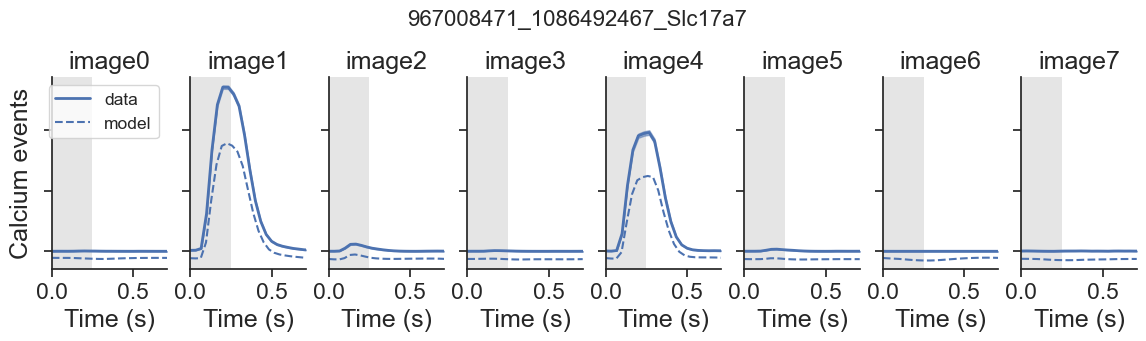

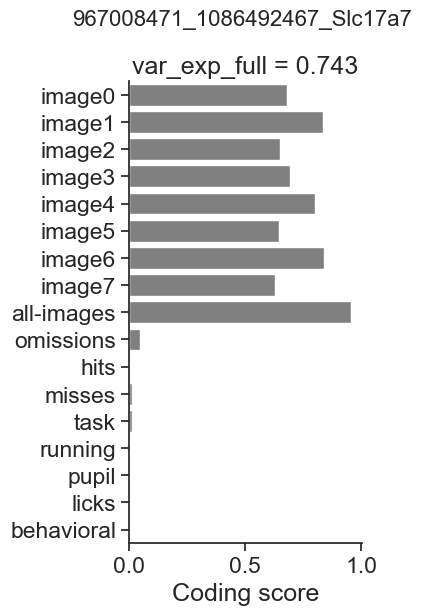

In [ ]:
cells_table = platform_cells_table.copy()

# for a cell with high variance explained
# high_var_data = all_results[(all_results.variance_explained_full>0.2) &
#                         (all_results.ophys_experiment_id.isin(cells_table.ophys_experiment_id.unique())) & 
#                         (all_results.cre_line=='Vip-IRES-Cre')]

# high_var_cells = high_var_data.identifier.unique()
# print(len(high_var_cells))
# identifier = high_var_cells[2]
# ophys_experiment_id = int(identifier.split('_')[0])
# cell_specimen_id = int(identifier.split('_')[1])

# for a specific cell 
# cell_specimen_id = 1086501664
# ophys_experiment_id = 849233396

ophys_experiment_id = 967008471
cell_specimen_id = 1086492467
identifier = str(ophys_experiment_id)+'_'+str(cell_specimen_id)

# get average responses
dataset = loading.get_ophys_dataset(ophys_experiment_id, get_extended_stimulus_presentations=False)

kernels = run_params['kernels']
frame_rate = 31
image_sdf, omission_sdf, change_sdf = gep.get_stimulus_response_dfs_for_kernel_windows(dataset, kernels, frame_rate)

gep.plot_image_kernels_and_traces_for_cell(cell_specimen_id, dataset, 
                                 image_sdf, omission_sdf, change_sdf, 
                                 weights_df, kernels, save_dir=save_dir)

gep.plot_all_kernels_and_traces_for_cell(cell_specimen_id, dataset, 
                                 image_sdf, omission_sdf, change_sdf, 
                                 weights_df, kernels, save_dir=save_dir)


gep.plot_coding_scores_for_cell(cell_specimen_id,  ophys_experiment_id, results_pivoted, save_dir=save_dir)

#### Plot kernels and coding scores for all high variance or high SNR cells for one experiment

In [ ]:
# ophys_experiment_id = 905955219

# gep.plot_kernels_traces_and_dropouts_examples_for_experiment(ophys_experiment_id, run_params, 
#                                                             all_results, results_pivoted, weights_df, 
#                                                             use_var_exp=True, save_dir=save_dir)

#### Plot for all experiments

In [ ]:
# ophys_experiment_ids = platform_experiments[platform_experiments.cre_line=='Vip-IRES-Cre'].index.values

# failed_experiments = []
# for ophys_experiment_id in ophys_experiment_ids[:15]:
#     try: 

#         gep.plot_kernels_traces_and_dropouts_examples_for_experiment(ophys_experiment_id, run_params, 
#                                                             all_results, results_pivoted, weights_df, 
#                                                             use_var_exp=False, save_dir=save_dir)
#     except: 
#         print('problem for', ophys_experiment_id)
#         failed_experiments.append(ophys_experiment_id)

### Plot model fits, kernels, and coding scores in the same figure

#### For one cell

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


file exists:
loading response df from file for 967008471 filtered_events all
sdf loaded
annotating stim presentations
adding reward rate
adding epochs
Pandas requires version '1.7.1' or newer of 'scipy' (version '1.4.1' currently installed).
finished annotating
file exists:
loading response df from file for 967008471 filtered_events omissions
sdf loaded
annotating stim presentations
adding reward rate
adding epochs
Pandas requires version '1.7.1' or newer of 'scipy' (version '1.4.1' currently installed).
finished annotating
file exists:
loading response df from file for 967008471 filtered_events changes
sdf loaded
annotating stim presentations
adding reward rate
adding epochs
Pandas requires version '1.7.1' or newer of 'scipy' (version '1.4.1' currently installed).
finished annotating


C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\data_access\loading.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stimulus_presentations[column] = stimulus_presentations[column].astype('bool')
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\visualization\ophys\glm_example_plots.py:170: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(fit['fit_trace_timestamps'][time_vec],
C:\Users\marinag\Documents\Code\visual_behavior_analysis\visual_behavior\visualization\ophys\glm_example_plots.py:189: UserWarning: color is redundantly defined by the 'color' keyword argument

plotting other kernels


Text(0.5, 0.9, '479458_967008471_Slc17a7_VISp_375_OPHYS_4_images_A')

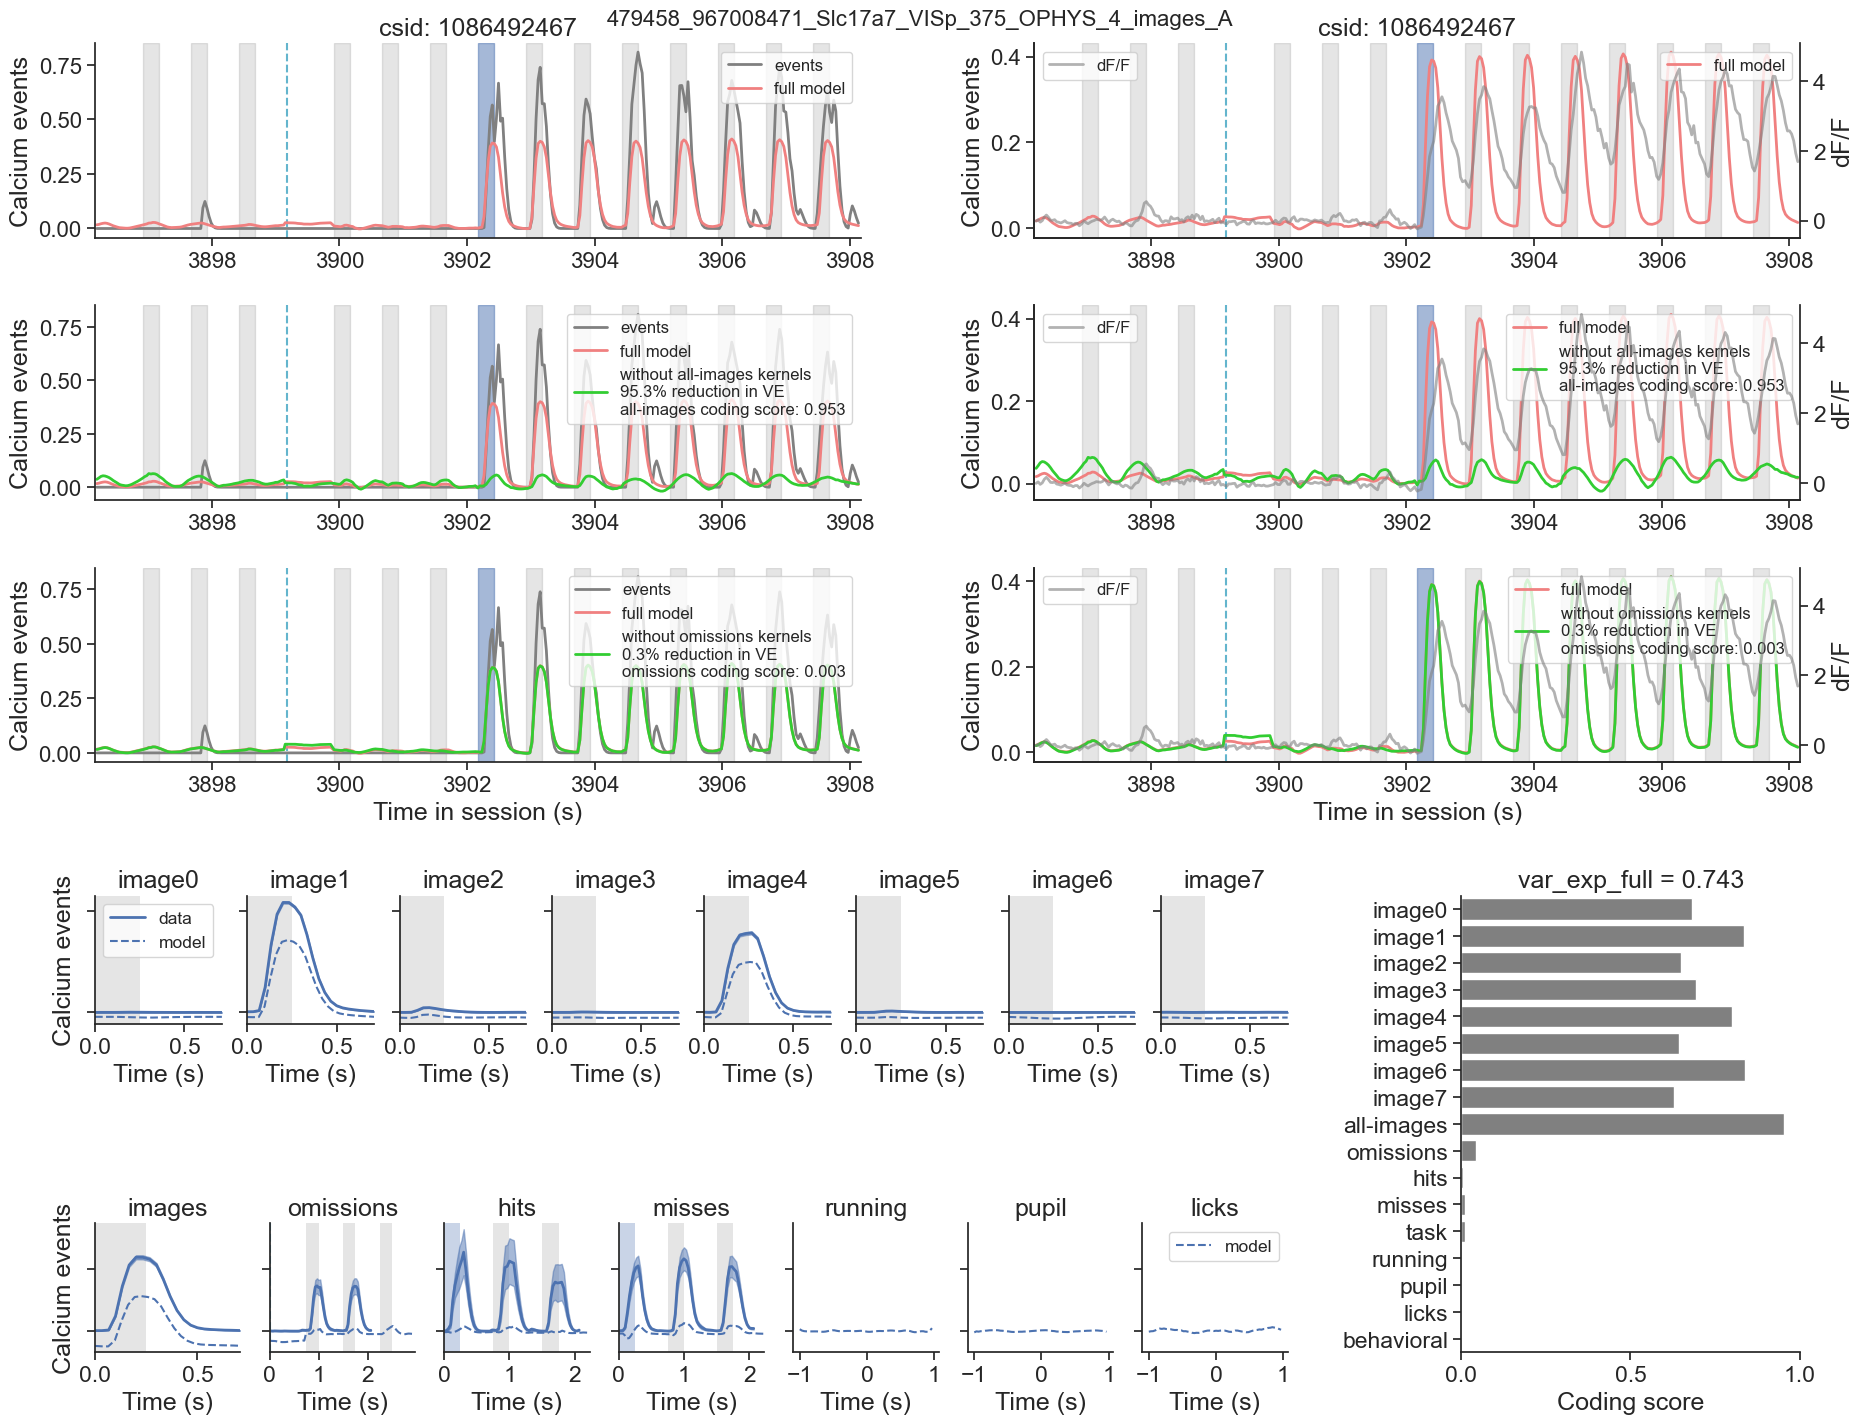

In [ ]:
# ophys_experiment_id = 849233396
# cell_specimen_id = 1086501664

ophys_experiment_id = 967008471
cell_specimen_id = 1086492467

# load dataset & filter stim presentations
dataset = loading.get_ophys_dataset(ophys_experiment_id)

# get GLM results
cell_results_df, expt_results, dropouts = gep.load_glm_model_fit_results(ophys_experiment_id)

# get stimulus response dfs for kernel lengths
kernels = run_params['kernels']
frame_rate = 31
image_sdf, omission_sdf, change_sdf = gep.get_stimulus_response_dfs_for_kernel_windows(dataset, kernels, frame_rate)

# plot figuregep.
figsize = [2 * 11, 2 * 8.5]
fig = plt.figure(figsize=figsize, facecolor='white')

ax = utils.placeAxesOnGrid(fig, dim=(1, 1), xspan=(0, 0.45), yspan=(0, 0.15))
ax = gep.plot_model_fits_example_cell(cell_specimen_id, dataset, cell_results_df, dropouts, expt_results,
                                None, include_events=True, save_dir=None, ax=ax)
ax.set_xlabel('')

ax = utils.placeAxesOnGrid(fig, dim=(1, 1), xspan=(0, 0.45), yspan=(0.2, 0.35))
ax = gep.plot_model_fits_example_cell(cell_specimen_id, dataset, cell_results_df, dropouts, expt_results,
                                kernel='all-images', include_events=True, save_dir=None, ax=ax)
ax.set_title('')
ax.set_xlabel('')

ax = utils.placeAxesOnGrid(fig, dim=(1, 1), xspan=(0, 0.45), yspan=(0.4, 0.55))
ax = gep.plot_model_fits_example_cell(cell_specimen_id, dataset, cell_results_df, dropouts, expt_results,
                                kernel='omissions', include_events=True, save_dir=None, ax=ax)
ax.set_title('')

ax = utils.placeAxesOnGrid(fig, dim=(1, 1), xspan=(0.55, 1.0), yspan=(0, 0.15))
ax = gep.plot_model_fits_example_cell(cell_specimen_id, dataset, cell_results_df, dropouts, expt_results,
                                kernel=None, include_events=False, save_dir=None, ax=ax)
ax.set_xlabel('')

ax = utils.placeAxesOnGrid(fig, dim=(1, 1), xspan=(0.55, 1.0), yspan=(0.2, 0.35))
ax = gep.plot_model_fits_example_cell(cell_specimen_id, dataset, cell_results_df, dropouts, expt_results,
                                kernel='all-images', include_events=False, save_dir=None, ax=ax)
ax.set_title('')
ax.set_xlabel('')

ax = utils.placeAxesOnGrid(fig, dim=(1, 1), xspan=(0.55, 1.0), yspan=(0.4, 0.55))
ax = gep.plot_model_fits_example_cell(cell_specimen_id, dataset, cell_results_df, dropouts, expt_results,
                                kernel='omissions', include_events=False, save_dir=None, ax=ax)
ax.set_title('')


ax = utils.placeAxesOnGrid(fig, dim=(1, 8), xspan=(0., 0.7), yspan=(0.65, 0.75), sharey=True)
ax = gep.plot_image_kernels_and_traces_for_cell(cell_specimen_id, dataset, image_sdf, omission_sdf, change_sdf,
                                                weights_df, kernels, save_dir=None, ax=ax)

ax = utils.placeAxesOnGrid(fig, dim=(1, 7), xspan=(0., 0.7), yspan=(0.9, 1.0), sharey=True,)
                        #    gridspec_kw={'width_ratios': [1, 3, 2.25, 2.25, 2, 2, 2, ]})
ax = gep.plot_all_kernels_and_traces_for_cell(cell_specimen_id, dataset, image_sdf, omission_sdf, change_sdf,
                                        weights_df, kernels, save_dir=None, ax=ax)

ax = utils.placeAxesOnGrid(fig, dim=(1, 1), xspan=(0.8, 1.0), yspan=(0.65, 1.0))
ax = gep.plot_coding_scores_for_cell(cell_specimen_id, ophys_experiment_id, results_pivoted, save_dir=None, ax=ax)

metadata_string = utils.get_metadata_string(dataset.metadata)
fig.suptitle(metadata_string, x=0.5, y=0.9, fontsize = 16)


#### For all cells in one experiment

In [ ]:
# ophys_experiment_id = platform_experiments[platform_experiments.cre_line=='Vip-IRES-Cre'].index.values[0]

# gep.plot_glm_example_cells_figure(ophys_experiment_id, run_params, 
#                                   all_results, results_pivoted, weights_df,
#                                   use_var_exp=True, save_dir=False)

#### For multiple experiments for a given cre line

In [ ]:
# ophys_experiment_ids = platform_experiments[platform_experiments.cre_line=='Vip-IRES-Cre'].index.values

# for ophys_experiment_id in ophys_experiment_ids[:20]: 
#     gep.plot_glm_example_cells_figure(ophys_experiment_id, run_params, 
#                                   all_results, results_pivoted, weights_df,
#                                   use_var_exp=False, save_dir=save_dir)



In [ ]:
# ophys_experiment_ids = platform_experiments[platform_experiments.cre_line=='Sst-IRES-Cre'].index.values

# for ophys_experiment_id in ophys_experiment_ids[:20]: 
#     gep.plot_glm_example_cells_figure(ophys_experiment_id, run_params, 
#                                   all_results, results_pivoted, weights_df,
#                                   use_var_exp=True, save_dir=save_dir)



In [ ]:
# ophys_experiment_ids = platform_experiments[platform_experiments.cre_line=='Slc17a7-IRES2-Cre'].index.values

# for ophys_experiment_id in ophys_experiment_ids[:20]: 
#     gep.plot_glm_example_cells_figure(ophys_experiment_id, run_params, 
#                                   all_results, results_pivoted, weights_df,
#                                   use_var_exp=False, save_dir=save_dir)



In [ ]:
# # high variance cells

# ophys_experiment_ids = platform_experiments[platform_experiments.cre_line=='Vip-IRES-Cre'].index.values

# for ophys_experiment_id in ophys_experiment_ids: 
#     gep.plot_glm_example_cells_figure(ophys_experiment_id, run_params, 
#                                   all_results, results_pivoted, weights_df,
#                                   use_var_exp=True, save_dir=save_dir)
    

# ophys_experiment_ids = platform_experiments[platform_experiments.cre_line=='Sst-IRES-Cre'].index.values

# for ophys_experiment_id in ophys_experiment_ids: 
#     gep.plot_glm_example_cells_figure(ophys_experiment_id, run_params, 
#                                   all_results, results_pivoted, weights_df,
#                                   use_var_exp=True, save_dir=save_dir)


# ophys_experiment_ids = platform_experiments[platform_experiments.cre_line=='Slc17a7-IRES2-Cre'].index.values

# for ophys_experiment_id in ophys_experiment_ids: 
#     gep.plot_glm_example_cells_figure(ophys_experiment_id, run_params, 
#                                   all_results, results_pivoted, weights_df,
#                                   use_var_exp=True, save_dir=save_dir)




## Describe kernels

### kernel heatmaps

[-0.0029696191727447197, 0.0029696191727447197]

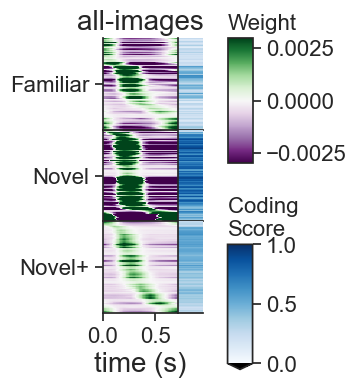

In [ ]:
# all cre lines, all experience levels 

kernel = 'all-images'
run_params['kernels'][kernel] = run_params['kernels']['image0'].copy()

time_vec = np.arange(run_params['kernels'][kernel]['offset'], run_params['kernels'][kernel]['offset'] + run_params['kernels'][kernel]['length'], 1/31.)
time_vec = np.round(time_vec,2)
if 'image' in kernel:
    time_vec = time_vec[:-1]

sst_table = weights_df.query('cre_line == "Sst-IRES-Cre"')[[kernel+'_weights',kernel]]
vip_table = weights_df.query('cre_line == "Vip-IRES-Cre"')[[kernel+'_weights',kernel]]
slc_table = weights_df.query('cre_line == "Slc17a7-IRES2-Cre"')[[kernel+'_weights',kernel]]


gvt.plot_kernel_heatmap_with_dropout_by_experience(vip_table, sst_table, slc_table, 
    time_vec, kernel, run_params, ncells = {},ax=None,extra='',zlims=None,
    session_filter=['Familiar', 'Novel', 'Novel +'],savefig=False,
    cell_filter='',sort_by_dropout=False,limited=False)

In [ ]:
#### all cre in same plot

[-0.0029696191727447197, 0.0029696191727447197]

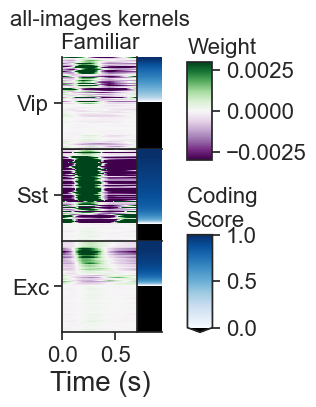

In [ ]:
kernel = 'all-images'
# run_params['kernels'][kernel] = run_params['kernels']['image0'].copy()

time_vec = np.arange(run_params['kernels'][kernel]['offset'], run_params['kernels'][kernel]['offset'] + run_params['kernels'][kernel]['length'], 1/31.)
time_vec = np.round(time_vec,2)
if 'image' in kernel:
    time_vec = time_vec[:-1]

sst_table = weights_df.query('cre_line == "Sst-IRES-Cre"')[[kernel+'_weights',kernel]]
vip_table = weights_df.query('cre_line == "Vip-IRES-Cre"')[[kernel+'_weights',kernel]]
slc_table = weights_df.query('cre_line == "Slc17a7-IRES2-Cre"')[[kernel+'_weights',kernel]]

gvt.plot_kernel_heatmap_with_dropout(vip_table, sst_table, slc_table, time_vec, kernel, 
                                     run_params, ncells = {}, ax=None, extra='', zlims=None, 
                                     session_filter=['Familiar'], savefig=False)
    

[-0.002133128935519523, 0.002133128935519523]

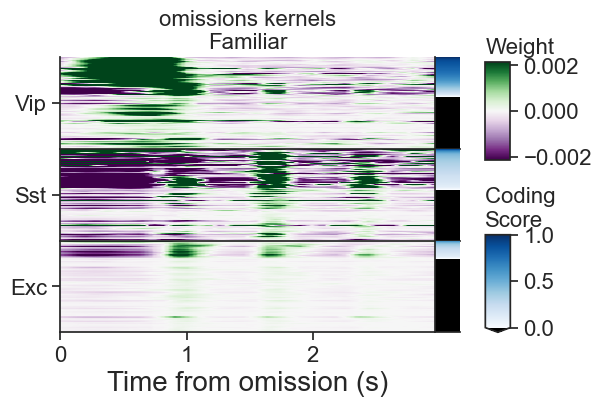

In [ ]:
kernel = 'omissions'
# run_params['kernels'][kernel] = run_params['kernels']['image0'].copy()

time_vec = np.arange(run_params['kernels'][kernel]['offset'], run_params['kernels'][kernel]['offset'] + run_params['kernels'][kernel]['length'], 1/31.)
time_vec = np.round(time_vec,2)
if 'image' in kernel:
    time_vec = time_vec[:-1]

sst_table = weights_df.query('cre_line == "Sst-IRES-Cre"')[[kernel+'_weights',kernel]]
vip_table = weights_df.query('cre_line == "Vip-IRES-Cre"')[[kernel+'_weights',kernel]]
slc_table = weights_df.query('cre_line == "Slc17a7-IRES2-Cre"')[[kernel+'_weights',kernel]]

gvt.plot_kernel_heatmap_with_dropout(vip_table, sst_table, slc_table, time_vec, kernel, 
                                     run_params, ncells = {}, ax=None, extra='', zlims=None, 
                                     session_filter=['Familiar'], savefig=False)
    

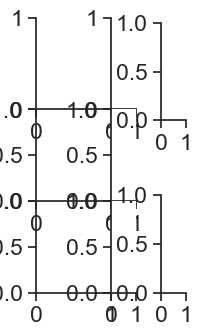

In [ ]:
from mpl_toolkits.axes_grid1 import Divider, Size

kernel = 'all-images'

height = 4
if kernel == 'all_images':
    kernel_length = run_params['kernels']['all-images']['length']       
else:
    kernel_length = run_params['kernels'][kernel]['length']
width=4+((4/3)*kernel_length)
pre_horz_offset = 1.5
post_horz_offset = 2.5
vertical_offset = .75
fig = plt.figure(figsize=(width,height))
h = [Size.Fixed(pre_horz_offset),Size.Fixed(width-pre_horz_offset-post_horz_offset-.25)]
v = [Size.Fixed(vertical_offset),Size.Fixed((height-vertical_offset-.5)/3)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
ax3 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))
v = [Size.Fixed(vertical_offset+(height-vertical_offset-.5)/3),Size.Fixed((height-vertical_offset-.5)/3)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
ax2 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))
v = [Size.Fixed(vertical_offset+2*(height-vertical_offset-.5)/3),Size.Fixed((height-vertical_offset-.5)/3)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
ax1 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))

h = [Size.Fixed(width-post_horz_offset-.25),Size.Fixed(.25)]
v = [Size.Fixed(vertical_offset+2*(height-vertical_offset-.5)/3),Size.Fixed((height-vertical_offset-.5)/3)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
dax1 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))  
v = [Size.Fixed(vertical_offset+(height-vertical_offset-.5)/3),Size.Fixed((height-vertical_offset-.5)/3)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
dax2 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))  
v = [Size.Fixed(vertical_offset),Size.Fixed((height-vertical_offset-.5)/3)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
dax3 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))  

# cbar 1
h = [Size.Fixed(width-post_horz_offset+.25),Size.Fixed(.25)]
v = [Size.Fixed(vertical_offset+(height-vertical_offset-.5)/2)+.35,Size.Fixed((height-vertical_offset-.5)/2.5-.125)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
cax1 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))  

# cbar 2
h = [Size.Fixed(width-post_horz_offset+.25),Size.Fixed(.25)]
v = [Size.Fixed(vertical_offset/1),Size.Fixed((height-vertical_offset-.5)/2.5-.125)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
cax2 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))  



### kernel averages

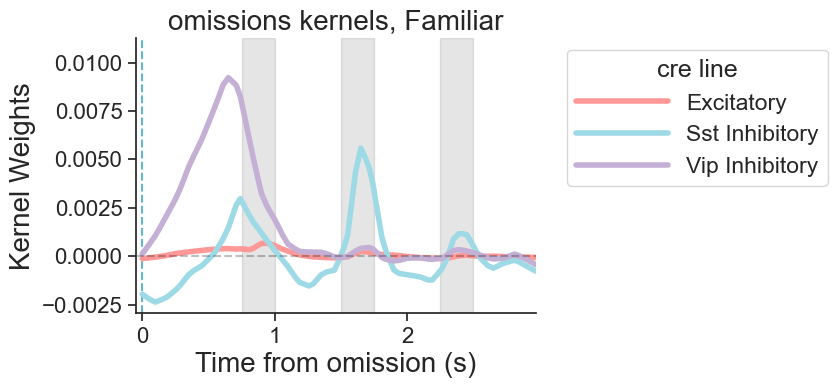

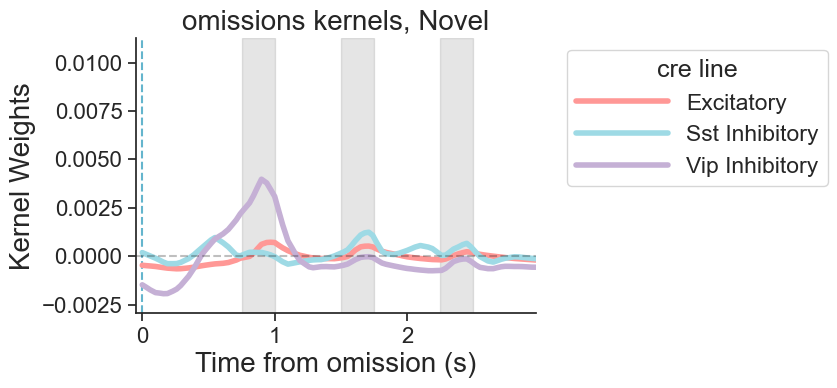

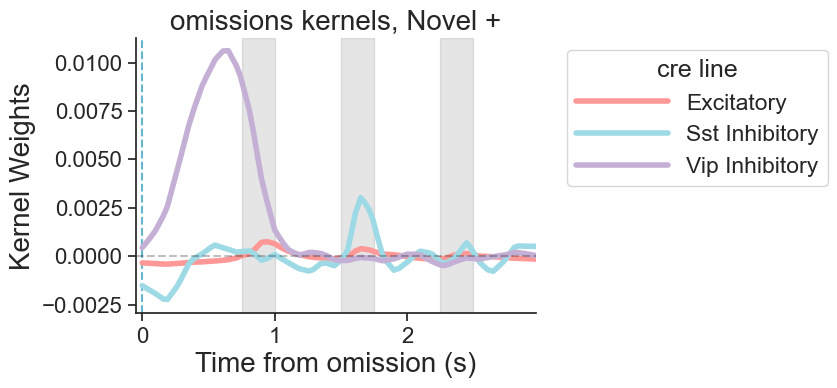

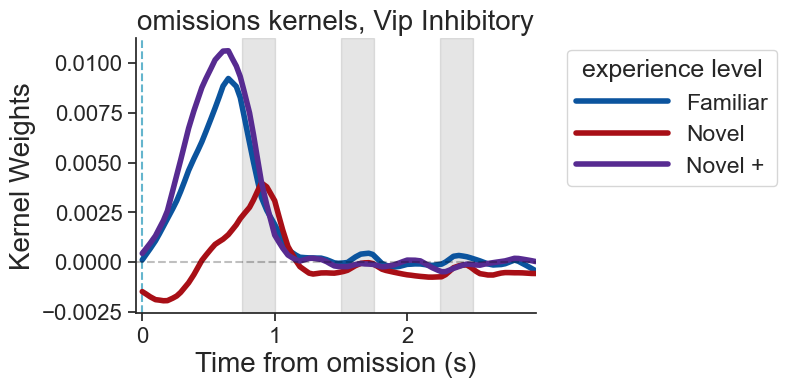

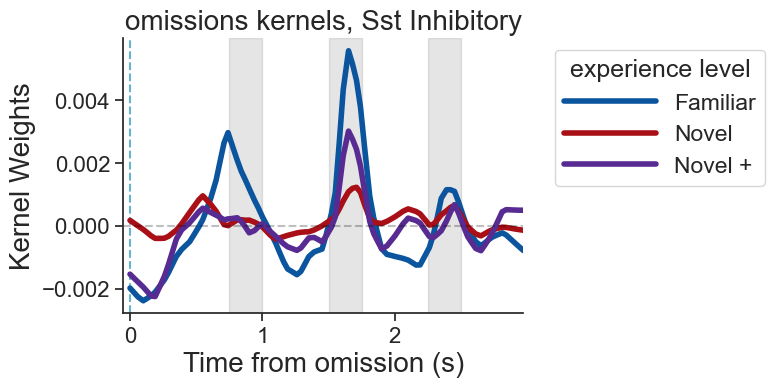

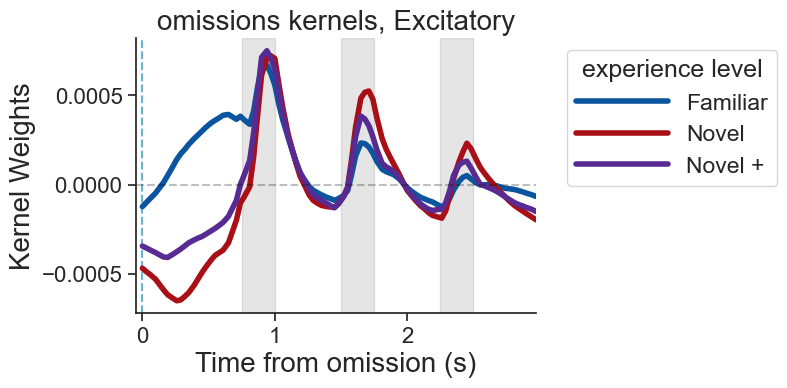

In [ ]:

# ## Panel B - Omission kernel heatmap for familiar sessions
# # This generates several figures, Panel B is `omissions_heatmap_with_dropout_Familiar.svg`
# gvt.kernel_evaluation(weights_df, run_params, 'omissions', session_filter=['Familiar'])

## Panel C - Omission kernels for each experience level
# This generates 6 figures,  3 by experience, and 3 by cre-line
# only the 3 by experience are used in the main figure
gvt.plot_kernel_comparison_by_experience(weights_df, run_params, 'omissions')
# gvt.kernel_evaluation_by_experience(weights_df, run_params, 'all-images',limited=False)   
# gvt.kernel_evaluation_by_experience(weights_df, run_params, 'omissions',limited=False)


## Describe feature coding by cell type

#### Old version

In [ ]:
all_results.experience_level.unique()

NameError: name 'all_results' is not defined

In [ ]:

## Panel D - Dropout summaries
# Returns a dataframe with rows for cre/dropout, and columns describing
# the dropout score
stats_D = gvt.plot_dropout_summary_population(all_results,run_params) 
# stats_D = gvt.plot_dropout_summary_population_with_experience(all_results,run_params) 
results_pivoted_active = results_pivoted.query('not passive').copy()
anova, tukey = gvt.test_significant_across_cell(results_pivoted_active,'all-images')
anova, tukey = gvt.test_significant_across_cell(results_pivoted_active,'omissions')
anova, tukey = gvt.test_significant_across_cell(results_pivoted_active,'behavioral')
anova, tukey = gvt.test_significant_across_cell(results_pivoted_active,'task')


NameError: name 'gvt' is not defined

In [ ]:
# compute coding fractions
results_pivoted = results_pivoted.query('not passive').copy()
results_pivoted['code_anything'] = results_pivoted['variance_explained_full'] > run_params['dropout_threshold'] 
results_pivoted['code_images'] = results_pivoted['code_anything'] & (results_pivoted['all-images'] < 0)
results_pivoted['code_omissions'] = results_pivoted['code_anything'] & (results_pivoted['omissions'] < 0)
results_pivoted['code_behavioral'] = results_pivoted['code_anything'] & (results_pivoted['behavioral'] < 0)
results_pivoted['code_task'] = results_pivoted['code_anything'] & (results_pivoted['task'] < 0)
summary_df = results_pivoted.groupby(['cre_line','experience_level'])[['code_anything','code_images','code_omissions','code_behavioral','code_task']].mean()

# Compute Confidence intervals
summary_df['n'] = results_pivoted.groupby(['cre_line','experience_level'])[['code_anything','code_images','code_omissions','code_behavioral','code_task']].count()['code_anything']
summary_df['code_images_ci'] = 1.96*np.sqrt((summary_df['code_images']*(1-summary_df['code_images']))/summary_df['n'])
summary_df['code_omissions_ci'] = 1.96*np.sqrt((summary_df['code_omissions']*(1-summary_df['code_omissions']))/summary_df['n'])
summary_df['code_behavioral_ci'] = 1.96*np.sqrt((summary_df['code_behavioral']*(1-summary_df['code_behavioral']))/summary_df['n'])
summary_df['code_task_ci'] = 1.96*np.sqrt((summary_df['code_task']*(1-summary_df['code_task']))/summary_df['n'])


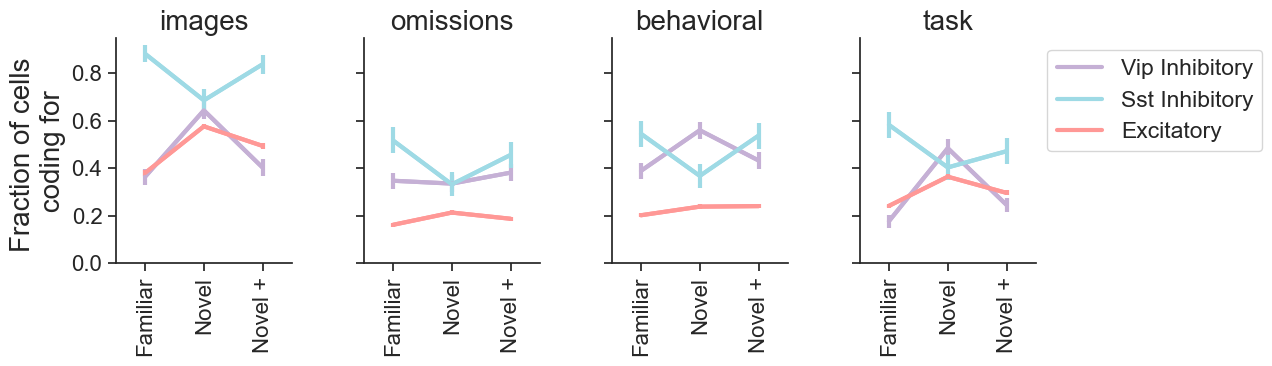

In [ ]:
coding_groups = ['code_images','code_omissions','code_behavioral','code_task']
titles = ['images','omissions','behavioral','task']
colors = utils.get_cre_line_color_dict()

fig, ax = plt.subplots(1,len(coding_groups),figsize=(10.8,4), sharey=True)
for index, feature in enumerate(coding_groups):
    # plots three cre-lines in standard colors
    ax[index].plot([0,1,2], summary_df.loc['Vip-IRES-Cre'][feature],'-', color=colors['Vip-IRES-Cre'],label='Vip Inhibitory',linewidth=3)
    ax[index].plot([0,1,2], summary_df.loc['Sst-IRES-Cre'][feature],'-', color=colors['Sst-IRES-Cre'],label='Sst Inhibitory',linewidth=3)
    ax[index].plot([0,1,2], summary_df.loc['Slc17a7-IRES2-Cre'][feature],'-', color=colors['Slc17a7-IRES2-Cre'],label='Excitatory',linewidth=3)
    
    ax[index].errorbar([0,1,2], summary_df.loc['Vip-IRES-Cre'][feature],yerr=summary_df.loc['Vip-IRES-Cre'][feature+'_ci'],color=colors['Vip-IRES-Cre'],linewidth=3)
    ax[index].errorbar([0,1,2], summary_df.loc['Sst-IRES-Cre'][feature],yerr=summary_df.loc['Sst-IRES-Cre'][feature+'_ci'],color=colors['Sst-IRES-Cre'],linewidth=3)
    ax[index].errorbar([0,1,2], summary_df.loc['Slc17a7-IRES2-Cre'][feature],yerr=summary_df.loc['Slc17a7-IRES2-Cre'][feature+'_ci'],color=colors['Slc17a7-IRES2-Cre'],linewidth=3)

    ax[index].set_title(titles[index],fontsize=20)
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')
    ax[index].set_xticks([0,1,2])
    ax[index].set_xticklabels(experience_levels, rotation=90)
    ax[index].tick_params(axis='x',labelsize=16)
    ax[index].tick_params(axis='y',labelsize=16)
    ax[index].spines['top'].set_visible(False)
    ax[index].spines['right'].set_visible(False)
    ax[index].set_xlim(-.5,2.5)
    ax[index].set_ylim(bottom=0)
    if index ==3:
        ax[index].legend(bbox_to_anchor=(1,1))
ax[0].set_ylabel('Fraction of cells \n coding for ',fontsize=20)
plt.tight_layout()

In [ ]:
for kernel in ['image0', 'omissions', 'hits', 'misses', 'licks', 'running', 'pupil']:
    print(run_params['kernels'][kernel])

{'event': 'image0', 'type': 'discrete', 'length': 0.75, 'offset': 0, 'num_weights': None, 'dropout': True, 'text': 'image presentation'}
{'event': 'omissions', 'type': 'discrete', 'length': 3, 'offset': 0, 'num_weights': None, 'dropout': True, 'text': 'image was omitted'}
{'event': 'hit', 'type': 'discrete', 'length': 2.25, 'offset': 0, 'num_weights': None, 'dropout': True, 'text': 'lick to image change'}
{'event': 'miss', 'type': 'discrete', 'length': 2.25, 'offset': 0, 'num_weights': None, 'dropout': True, 'text': 'no lick to image change'}
{'event': 'licks', 'type': 'discrete', 'length': 2, 'offset': -1, 'num_weights': None, 'dropout': True, 'text': 'mouse lick'}
{'event': 'running', 'type': 'continuous', 'length': 2, 'offset': -1, 'num_weights': None, 'dropout': True, 'text': 'normalized running speed'}
{'event': 'pupil', 'type': 'continuous', 'length': 2, 'offset': -1, 'num_weights': None, 'dropout': True, 'text': 'Z-scored pupil diameter'}


### fraction cells coding each feature

#### color by cre

In [ ]:
summary_df = results_pivoted.groupby(['cre_line'])[['code_anything','code_images','code_omissions','code_behavioral','code_task']].mean()
fractions = summary_df.copy()
fractions.columns = [column.split('_')[1] for column in fractions.columns]
fractions = fractions.drop(columns=['anything'])
fractions = fractions.rename(columns={'behavioral':'behavior'})
fractions = fractions.reset_index()
fractions = fractions.melt(id_vars=['cre_line'], var_name='feature', value_name='fraction')
fractions['cell_type'] = [utils.get_abbreviated_cell_type(cre_line) for cre_line in fractions.cre_line.values]
fractions

cre_line    feature  fraction cell_type
0   Slc17a7-IRES2-Cre     images  0.486155       Exc
1        Sst-IRES-Cre     images  0.799591       Sst
2        Vip-IRES-Cre     images  0.465086       Vip
3   Slc17a7-IRES2-Cre  omissions  0.188713       Exc
4        Sst-IRES-Cre  omissions  0.433538       Sst
5        Vip-IRES-Cre  omissions  0.355292       Vip
6   Slc17a7-IRES2-Cre   behavior  0.227822       Exc
7        Sst-IRES-Cre   behavior  0.481595       Sst
8        Vip-IRES-Cre   behavior  0.457620       Vip
9   Slc17a7-IRES2-Cre       task  0.302866       Exc
10       Sst-IRES-Cre       task  0.484663       Sst
11       Vip-IRES-Cre       task  0.297321       Vip

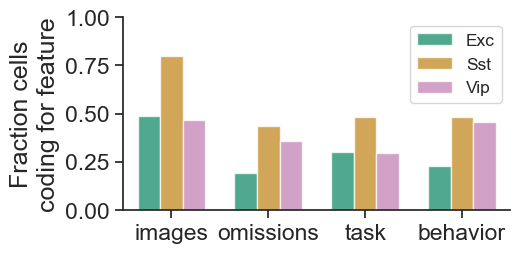

In [ ]:
features = processing.get_feature_labels_for_clustering()
cell_type_colors = utils.get_cell_type_colors()
cell_types = np.sort(fractions.cell_type.unique())

figsize = (5, 2.5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.barplot(data=fractions, x='feature', y='fraction', order=features,
                        hue='cell_type', hue_order=cell_types, palette=cell_type_colors, 
                        width=0.7, alpha=0.75, ax=ax)
ax.legend(fontsize='x-small')
# ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylabel('Fraction cells\ncoding for feature')
# ax.set_xlabel('Feature category')
ax.set_ylim(0,1)
fig.subplots_adjust(hspace=0.4)

#### color by feature

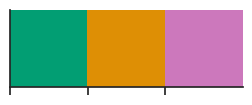

In [ ]:
colors = utils.get_cell_type_colors()
sns.palplot(colors)

In [ ]:
summary_df = results_pivoted.groupby(['cre_line'])[['code_anything','code_images','code_omissions','code_behavioral','code_task']].mean()
fractions = summary_df.copy()
fractions.columns = [column.split('_')[1] for column in fractions.columns]
fractions = fractions.drop(columns=['anything'])
fractions = fractions.rename(columns={'behavioral':'behavior'})
fractions = fractions.reset_index()
fractions = fractions.melt(id_vars=['cre_line'], var_name='feature', value_name='fraction')
fractions['cell_type'] = [utils.get_abbreviated_cell_type(cre_line) for cre_line in fractions.cre_line.values]
fractions


cre_line    feature  fraction cell_type
0   Slc17a7-IRES2-Cre     images  0.486155       Exc
1        Sst-IRES-Cre     images  0.799591       Sst
2        Vip-IRES-Cre     images  0.465086       Vip
3   Slc17a7-IRES2-Cre  omissions  0.188713       Exc
4        Sst-IRES-Cre  omissions  0.433538       Sst
5        Vip-IRES-Cre  omissions  0.355292       Vip
6   Slc17a7-IRES2-Cre   behavior  0.227822       Exc
7        Sst-IRES-Cre   behavior  0.481595       Sst
8        Vip-IRES-Cre   behavior  0.457620       Vip
9   Slc17a7-IRES2-Cre       task  0.302866       Exc
10       Sst-IRES-Cre       task  0.484663       Sst
11       Vip-IRES-Cre       task  0.297321       Vip

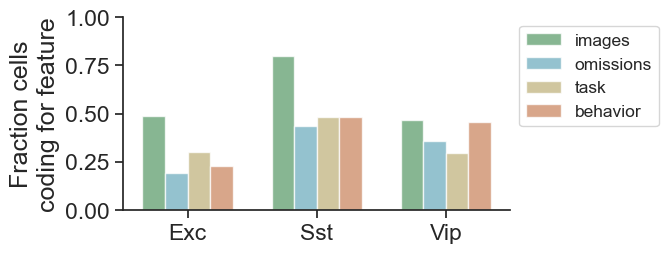

In [ ]:

features = processing.get_feature_labels_for_clustering()
feature_colors, feature_labels_dict = plotting.get_feature_colors_and_labels()

figsize = (5, 2.5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.barplot(data=fractions, x='cell_type', y='fraction', order=cell_types,
                        hue='feature', hue_order=features, palette=feature_colors, 
                        width=0.7, alpha=0.75, ax=ax)
ax.legend(fontsize='x-small', bbox_to_anchor=(1,1))
# ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylabel('Fraction cells\ncoding for feature')
# ax.set_xlabel('Feature category')
ax.set_ylim(0,1)
fig.subplots_adjust(hspace=0.4)

##### stricter criteria 

In [ ]:
var_explained_thresh = run_params['dropout_threshold'] # 0.01 # stricter than inclusion threshold of 0.005
coding_thresh = -0.1

# compute coding fractions
results_pivoted = results_pivoted.query('not passive').copy()
results_pivoted['code_anything_strict'] = results_pivoted['variance_explained_full'] > var_explained_thresh #run_params['dropout_threshold'] 
results_pivoted['code_images_strict'] = results_pivoted['code_anything_strict'] & (results_pivoted['all-images'] < coding_thresh)
results_pivoted['code_omissions_strict'] = results_pivoted['code_anything_strict'] & (results_pivoted['omissions'] < coding_thresh)
results_pivoted['code_behavioral_strict'] = results_pivoted['code_anything_strict'] & (results_pivoted['behavioral'] < coding_thresh)
results_pivoted['code_task_strict'] = results_pivoted['code_anything_strict'] & (results_pivoted['task'] < coding_thresh)

summary_df = results_pivoted.groupby(['cre_line'])[['code_anything_strict','code_images_strict','code_omissions_strict','code_behavioral_strict','code_task_strict']].mean()
fractions = summary_df.copy()
fractions.columns = [column.split('_')[1] for column in fractions.columns]
fractions = fractions.drop(columns=['anything'])
fractions = fractions.rename(columns={'behavioral':'behavior'})
fractions = fractions.reset_index()
fractions = fractions.melt(id_vars=['cre_line'], var_name='feature', value_name='fraction')

fractions['cell_type'] = [utils.get_abbreviated_cell_type(cre_line) for cre_line in fractions.cre_line.values]

fractions

cre_line    feature  fraction cell_type
0   Slc17a7-IRES2-Cre     images  0.478880       Exc
1        Sst-IRES-Cre     images  0.791411       Sst
2        Vip-IRES-Cre     images  0.421607       Vip
3   Slc17a7-IRES2-Cre  omissions  0.061376       Exc
4        Sst-IRES-Cre  omissions  0.162577       Sst
5        Vip-IRES-Cre  omissions  0.298639       Vip
6   Slc17a7-IRES2-Cre   behavior  0.096120       Exc
7        Sst-IRES-Cre   behavior  0.149284       Sst
8        Vip-IRES-Cre   behavior  0.357488       Vip
9   Slc17a7-IRES2-Cre       task  0.155159       Exc
10       Sst-IRES-Cre       task  0.209611       Sst
11       Vip-IRES-Cre       task  0.158981       Vip

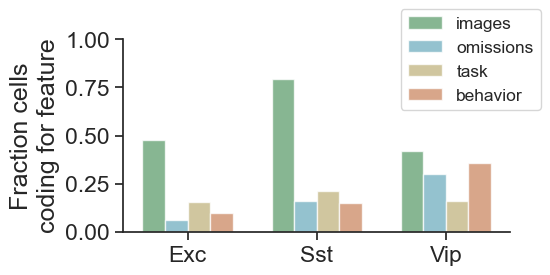

In [ ]:
features = processing.get_feature_labels_for_clustering()
feature_colors, feature_labels_dict = plotting.get_feature_colors_and_labels()

figsize = (5, 2.5)
fig, ax = plt.subplots(figsize=figsize)
ax = sns.barplot(data=fractions, x='cell_type', y='fraction', order=cell_types,
                        hue='feature', hue_order=features, palette=feature_colors, 
                        width=0.7, alpha=0.75, ax=ax)
ax.legend(fontsize='x-small', bbox_to_anchor=(1.1, 1.2))
# ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylabel('Fraction cells\ncoding for feature')
# ax.set_xlabel('Feature category')
ax.set_ylim(0,1)
fig.subplots_adjust(hspace=0.4)

#### maximally contributing feature dimension

In [ ]:
# get average coding scores per cell for main features
results_pivoted_avg_per_cell = results_pivoted.groupby(['cre_line', 'cell_specimen_id']).mean().reset_index()
df = results_pivoted_avg_per_cell.set_index(['cell_specimen_id'])[processing.get_features_for_clustering()]
# df = df.set_index('cell_specimen_id')
df = np.abs(df)
# aggregate the feature with largest average coding score for each cell
max_feature = pd.DataFrame(df.index.values, columns=['cell_specimen_id'])
max_feature = max_feature.set_index('cell_specimen_id')
max_feature['max_feature'] = None
for csid in df.index.values:
    max_feature.loc[csid, 'max_feature'] = df.loc[csid].idxmax()
max_feature = max_feature.merge(cells_table[['cell_specimen_id', 'cre_line']], on=['cell_specimen_id'])

# count how many cells in each cre line have maximal coding for each feature
feature_counts = plotting.get_fraction_cells_for_column(max_feature, column_to_group = 'max_feature')
feature_counts.head()

C:\Users\marinag\AppData\Local\Temp\ipykernel_27156\2474856346.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_pivoted_avg_per_cell = results_pivoted.groupby(['cre_line', 'cell_specimen_id']).mean().reset_index()


cre_line max_feature  n_cells  total_cells  fraction
0  Slc17a7-IRES2-Cre  all-images    20278        22680  0.894092
1  Slc17a7-IRES2-Cre  behavioral      686        22680  0.030247
2  Slc17a7-IRES2-Cre   omissions      357        22680  0.015741
3  Slc17a7-IRES2-Cre        task     1359        22680  0.059921
4       Sst-IRES-Cre  all-images      905          978  0.925358

In [ ]:
feature_colors, feature_labels_dict = plotting.get_feature_colors_and_labels()
features = processing.get_feature_labels_for_clustering()

C:\Users\marinag\AppData\Local\Temp\ipykernel_27156\3076472477.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in utils.get_cre_lines()])


Text(0.5, 1.0, 'Maxmially contributing\nfeature distribution')

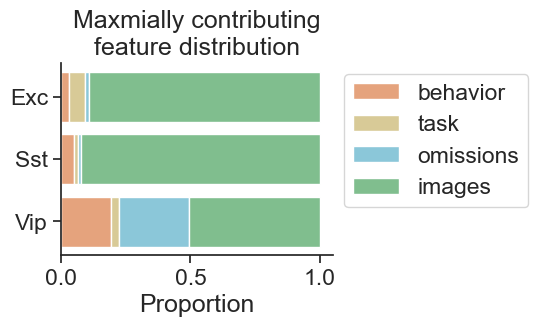

In [ ]:
figsize = (3.5,2.5)
fig, ax = plt.subplots(figsize=figsize)
feature_order = processing.get_features_for_clustering()
feature_labels = processing.get_feature_labels_for_clustering()[::-1] # for some reason legend shows colors in reverse order
ax = sns.histplot(feature_counts, y='cre_line', hue='max_feature', hue_order=feature_order, weights='fraction',
            multiple='stack', palette=feature_colors, shrink=0.8, alpha=0.75, ax=ax)
ax.set_yticklabels([utils.get_abbreviated_cell_type(cre_line) for cre_line in utils.get_cre_lines()])
ax.legend(feature_labels, bbox_to_anchor=(1,1))
ax.set_xlabel('Proportion')
ax.set_ylabel('')
ax.set_title('Maxmially contributing\nfeature distribution')

## Feature coding by experience

In [ ]:
summary_df = results_pivoted.groupby(['cre_line','experience_level'])[['code_anything','code_images','code_omissions','code_behavioral','code_task']].mean()

fractions = summary_df.copy()
fractions.columns = [column.split('_')[1] for column in fractions.columns]
fractions = fractions.drop(columns=['anything'])
fractions = fractions.rename(columns={'behavioral':'behavior'})
fractions = fractions.reset_index()
fractions = fractions.melt(id_vars=['cre_line', 'experience_level'], var_name='feature', value_name='fraction')
fractions['experience_level'] = [utils.convert_experience_level(exp_level) for exp_level in fractions.experience_level.values]

fractions

cre_line experience_level    feature  fraction
0   Slc17a7-IRES2-Cre         Familiar     images  0.379896
1   Slc17a7-IRES2-Cre            Novel     images  0.576248
2   Slc17a7-IRES2-Cre          Novel +     images  0.493922
3        Sst-IRES-Cre         Familiar     images  0.881620
4        Sst-IRES-Cre            Novel     images  0.685460
5        Sst-IRES-Cre          Novel +     images  0.837500
6        Vip-IRES-Cre         Familiar     images  0.363980
7        Vip-IRES-Cre            Novel     images  0.643454
8        Vip-IRES-Cre          Novel +     images  0.402614
9   Slc17a7-IRES2-Cre         Familiar  omissions  0.162284
10  Slc17a7-IRES2-Cre            Novel  omissions  0.213820
11  Slc17a7-IRES2-Cre          Novel +  omissions  0.187736
12       Sst-IRES-Cre         Familiar  omissions  0.517134
13       Sst-IRES-Cre            Novel  omissions  0.332344
14       Sst-IRES-Cre          Novel +  omissions  0.456250
15       Vip-IRES-Cre         Familiar  omissions  0.347607
16       Vip-IRES-Cre            Novel  omissions  0.335655
17       Vip-IRES-Cre          Novel +  omissions  0.381699
18  Slc17a7-IRES2-Cre         Familiar   behavior  0.202547
19  Slc17a7-IRES2-Cre            Novel   behavior  0.238776
20  Slc17a7-IRES2-Cre          Novel +   behavior  0.240951
21       Sst-IRES-Cre         Familiar   behavior  0.545171
22       Sst-IRES-Cre            Novel   behavior  0.367953
23       Sst-IRES-Cre          Novel +   behavior  0.537500
24       Vip-IRES-Cre         Familiar   behavior  0.389169
25       Vip-IRES-Cre            Novel   behavior  0.559889
26       Vip-IRES-Cre          Novel +   behavior  0.432680
27  Slc17a7-IRES2-Cre         Familiar       task  0.241988
28  Slc17a7-IRES2-Cre            Novel       task  0.364560
29  Slc17a7-IRES2-Cre          Novel +       task  0.296461
30       Sst-IRES-Cre         Familiar       task  0.582555
31       Sst-IRES-Cre            Novel       task  0.403561
32       Sst-IRES-Cre          Novel +       task  0.471875
33       Vip-IRES-Cre         Familiar       task  0.177582
34       Vip-IRES-Cre            Novel       task  0.484680
35       Vip-IRES-Cre          Novel +       task  0.245752

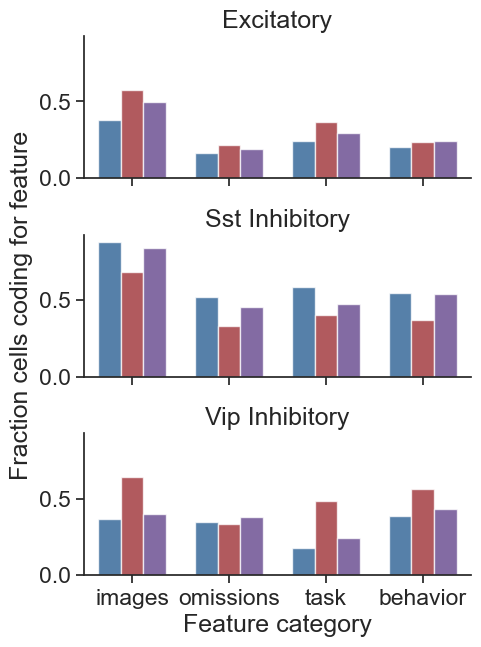

In [ ]:
features = processing.get_feature_labels_for_clustering()


figsize = (5, 7)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharex=True, sharey=True)
for i, cre_line in enumerate(cre_lines): 
    fractions_cre = fractions[fractions.cre_line==cre_line].copy()
    ax[i] = sns.barplot(data=fractions_cre, x='feature', y='fraction', order=features,
                           hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                           width=0.7, alpha=0.75, ax=ax[i])
    ax[i].get_legend().remove()
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
ax[1].set_ylabel('Fraction cells coding for feature')
ax[2].set_xlabel('Feature category')
fig.subplots_adjust(hspace=0.4)

In [ ]:
# swap names of features 
results_melted = results_pivoted.copy()
results_melted['images'] = results_melted['all-images']
results_melted['behavior'] = results_melted['behavioral']

# get coding scores for main features
features = processing.get_feature_labels_for_clustering()
print(features)
metadata = ['cell_specimen_id', 'ophys_experiment_id', 'cre_line', 'experience_level']
results_melted = results_melted[features + metadata]

# transform coding scores for plotting
results_melted = results_melted.melt(id_vars=metadata, value_vars=features, var_name='feature', value_name='coding_score')

# take absolute value & convert exp level
results_melted['coding_score'] = np.abs(results_melted['coding_score'])
results_melted['experience_level'] = [utils.convert_experience_level(exp_level) for exp_level in results_melted.experience_level.values]

len(results_melted.ophys_experiment_id.unique())

['images', 'omissions', 'task', 'behavior']


402

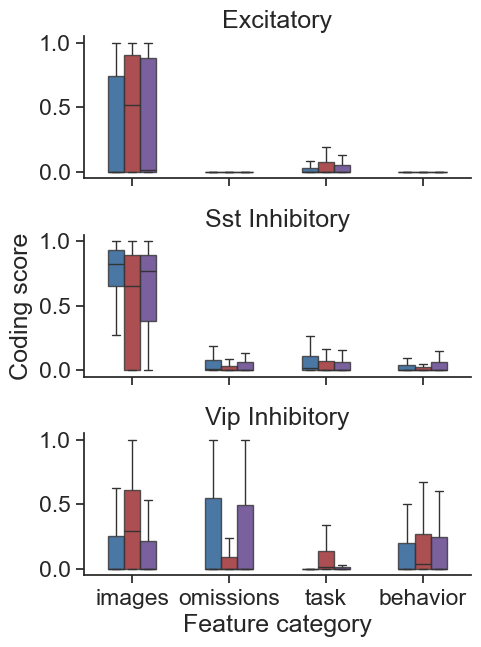

In [ ]:
# simple boxplot
figsize = (5,7)
fig, ax = plt.subplots(3, 1, figsize=figsize, sharex=True, sharey=True)
features = processing.get_feature_labels_for_clustering()

for i, cre_line in enumerate(cre_lines): 
    results_pivoted_cre = results_melted[results_melted.cre_line==cre_line].copy()
    ax[i] = sns.boxplot(data=results_pivoted_cre, x='feature', y='coding_score', order=features,
                           hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                           width=0.5, fliersize=0, boxprops=dict(alpha=0.8), ax=ax[i])
    ax[i].get_legend().remove()
    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
ax[1].set_ylabel('Coding score')
ax[2].set_xlabel('Feature category')
fig.subplots_adjust(hspace=0.4)

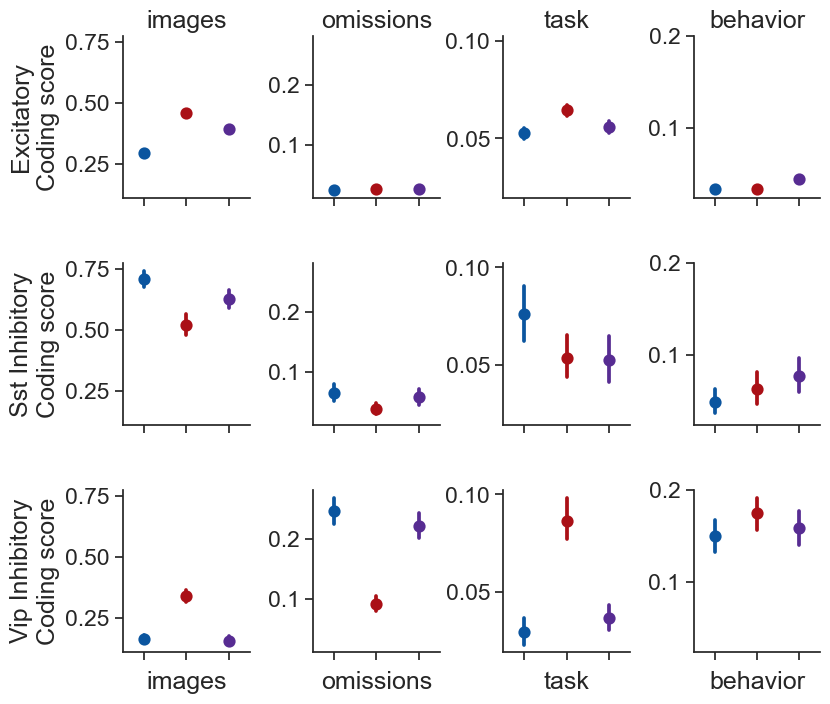

In [ ]:
# pointplot
figsize = (9,8)
fig, ax = plt.subplots(3, 4, figsize=figsize, sharey='col', sharex=False)
ax = ax.ravel()
i=0
for c, cre_line in enumerate(cre_lines): 
    for f, feature in enumerate(features):
        results_pivoted_cre_feature = results_melted[(results_melted.cre_line==cre_line)
                                                    & (results_melted.feature==feature)].copy()
        
        ax[i] = sns.pointplot(data=results_pivoted_cre_feature, x='experience_level', y='coding_score',  
                            hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                            ax=ax[i])
        # ax[i].get_legend().remove()
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].set_xticklabels([])
        if c == 0: 
            ax[i].set_title(feature)
        if c == 2: 
            ax[i].set_xlabel(feature)
        if f == 0: 
            ax[i].set_ylabel(utils.convert_cre_line_to_cell_type(cre_line)+'\nCoding score')
        i+=1
fig.subplots_adjust(hspace=0.4, wspace=0.5)

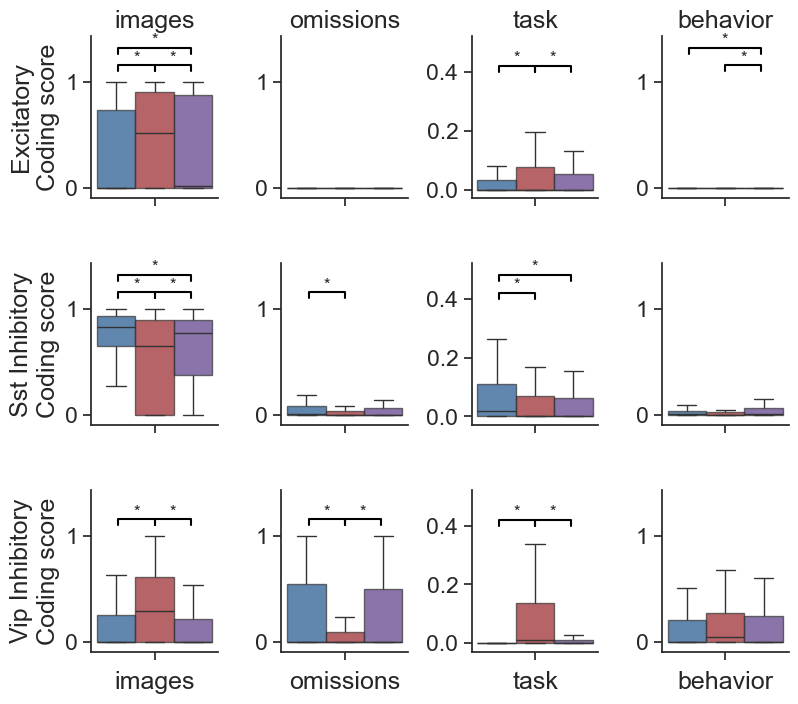

In [ ]:
# boxplot with no outliers
figsize = (9,8)
fig, ax = plt.subplots(3, 4, figsize=figsize, sharey='col')
ax = ax.ravel()
i=0
for c, cre_line in enumerate(cre_lines): 
    for f, feature in enumerate(features):
        results_pivoted_cre_feature = results_melted[(results_melted.cre_line==cre_line)
                                                    & (results_melted.feature==feature)].copy()
        
        ax[i] = sns.boxplot(data=results_pivoted_cre_feature, x='feature', y='coding_score',  #order=experience_levels, 
                            hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                            width=0.8, fliersize=0, whis=1.5, boxprops={'alpha':0.7},  ax=ax[i])
        ax[i].get_legend().remove()
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].set_xticklabels([])
        if c == 0: 
            ax[i].set_title(feature)
        if c == 2: 
            ax[i].set_xlabel(feature)
        if f == 0: 
            ax[i].set_ylabel(utils.convert_cre_line_to_cell_type(cre_line)+'\nCoding score')
        if feature == 'task':
            ax[i].set_ylim(-0.03, 0.4)
        elif feature == 'behavioral':
            ax[i].set_ylim(-0.05, 0.75)
        else: 
            ax[i].set_ylim(-0.1, 1.1)

        # add stats to plot for hues
        ax[i], tukey_table = ppf.add_stats_to_plot(results_pivoted_cre_feature, 'coding_score', 
                                               column_to_compare='experience_level', hue_only=True, ax=ax[i])
        i+=1
fig.subplots_adjust(hspace=0.4, wspace=0.5)

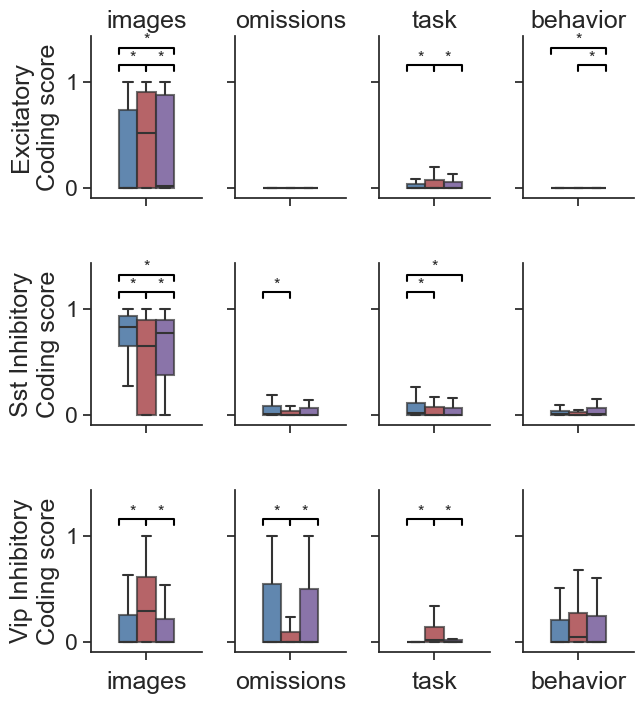

In [ ]:
# boxplot with no outliers
figsize = (7, 8)
fig, ax = plt.subplots(3, 4, figsize=figsize, sharey=True)
ax = ax.ravel()
i=0
for c, cre_line in enumerate(cre_lines): 
    for f, feature in enumerate(features):
        results_pivoted_cre_feature = results_melted[(results_melted.cre_line==cre_line)
                                                    & (results_melted.feature==feature)].copy()
        
        ax[i] = sns.boxplot(data=results_pivoted_cre_feature, x='feature', y='coding_score',  #order=experience_levels, 
                            hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                            native_scale=False, linewidth=1.5, width=0.5, fliersize=0, whis=1.5, 
                            boxprops={'alpha':0.7},  ax=ax[i])
        ax[i].get_legend().remove()
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].set_xticklabels([])
        if c == 0: 
            ax[i].set_title(feature)
        if c == 2: 
            ax[i].set_xlabel(feature)
        if f == 0: 
            ax[i].set_ylabel(utils.convert_cre_line_to_cell_type(cre_line)+'\nCoding score')

        ax[i].set_ylim(-0.1, 1.1)
        ax[i].set_xlim(-0.5, 0.5)

        # add stats to plot for hues
        ax[i], tukey_table = ppf.add_stats_to_plot(results_pivoted_cre_feature, 'coding_score', 
                                               column_to_compare='experience_level', hue_only=True, ax=ax[i])
        i+=1
fig.subplots_adjust(hspace=0.4, wspace=0.3)

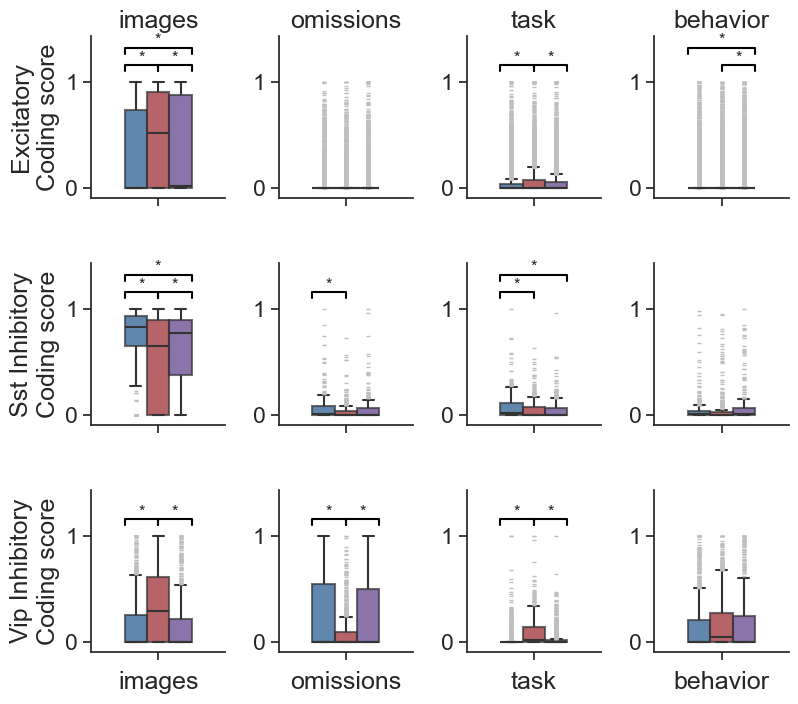

In [ ]:
# boxplot with outliers
figsize = (9, 8)
fig, ax = plt.subplots(3, 4, figsize=figsize, sharey='col')
ax = ax.ravel()
i=0
for c, cre_line in enumerate(cre_lines): 
    for f, feature in enumerate(features):
        results_pivoted_cre_feature = results_melted[(results_melted.cre_line==cre_line)
                                                    & (results_melted.feature==feature)].copy()
        
        ax[i] = sns.boxplot(data=results_pivoted_cre_feature, x='feature', y='coding_score',  #order=experience_levels, 
                            hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                            native_scale=False, linewidth=1.5, width=0.5, fliersize=0, whis=1.5, 
                            flierprops=dict(markerfacecolor='0.75', markersize=3, marker='_',
                                            linestyle='none', markeredgecolor='0.75'),
                            boxprops={'alpha':0.7}, ax=ax[i])
        ax[i].get_legend().remove()
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].set_xticklabels([])
        if c == 0: 
            ax[i].set_title(feature)
        if c == 2: 
            ax[i].set_xlabel(feature)
        if f == 0: 
            ax[i].set_ylabel(utils.convert_cre_line_to_cell_type(cre_line)+'\nCoding score')

        ax[i].set_ylim(-0.1, 1.1)
        ax[i].set_xlim(-0.5, 0.5)

        # add stats to plot for hues
        ax[i], tukey_table = ppf.add_stats_to_plot(results_pivoted_cre_feature, 'coding_score', 
                                               column_to_compare='experience_level', hue_only=True, ax=ax[i])
        i+=1
fig.subplots_adjust(hspace=0.4, wspace=0.4)

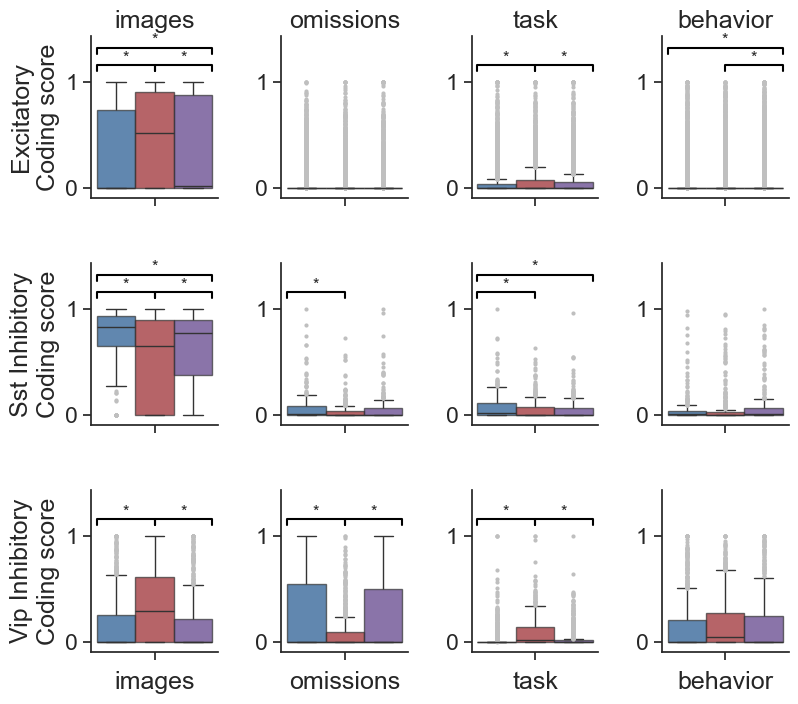

In [ ]:
# boxplot with outliers
figsize = (9,8)
fig, ax = plt.subplots(3, 4, figsize=figsize, sharey='col')
ax = ax.ravel()
i=0
for c, cre_line in enumerate(cre_lines): 
    for f, feature in enumerate(features):
        results_pivoted_cre_feature = results_melted[(results_melted.cre_line==cre_line)
                                                    & (results_melted.feature==feature)].copy()
        
        ax[i] = sns.boxplot(data=results_pivoted_cre_feature, x='feature', y='coding_score',  #order=experience_levels, 
                            hue='experience_level', hue_order=experience_levels, palette=experience_level_colors, 
                            width=0.5, fliersize=1, whis=1.5, boxprops={'alpha':0.7}, ax=ax[i], 
                            flierprops=dict(markerfacecolor='0.75', markersize=3, linestyle='none', markeredgecolor='none'),)

        ax[i].get_legend().remove()
        ax[i].set_ylabel('')
        ax[i].set_xlabel('')
        ax[i].set_xticklabels([])
        if c == 0: 
            ax[i].set_title(feature)
        if c == 2: 
            ax[i].set_xlabel(feature)
        if f == 0: 
            ax[i].set_ylabel(utils.convert_cre_line_to_cell_type(cre_line)+'\nCoding score')
        if feature == 'task':
            ax[i].set_ylim(-0.1, 1.1)
        elif feature == 'behavioral':
            ax[i].set_ylim(-0.05, 0.75)
        else: 
            ax[i].set_ylim(-0.1, 1.1)

        # add stats to plot for hues
        ax[i], tukey_table = ppf.add_stats_to_plot(results_pivoted_cre_feature, 'coding_score', 
                                               column_to_compare='experience_level', hue_only=True, ax=ax[i])
        i+=1
fig.subplots_adjust(hspace=0.4, wspace=0.5)

## Area / depth differences

C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


removing 1 problematic experiments


C:\Users\marinag\Documents\Code\visual_behavior_glm\visual_behavior_glm\GLM_visualization_tools.py:4068: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  ax[index] = sns.pointplot(
C:\Users\marinag\Documents\Code\visual_behavior_glm\visual_behavior_glm\GLM_visualization_tools.py:4068: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  ax[index] = sns.pointplot(
C:\Users\marinag\Documents\Code\visual_behavior_glm\visual_behavior_glm\GLM_visualization_tools.py:4068: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  ax[index] = sns.pointplot(
C:\Users\marinag\Documents\Code\visual_behavior_glm\visual_behavior_glm\GLM_visualization_tools.py:4068: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  ax[index] = sns.pointplot(
C:\Users\marinag\Documents\Code\visual_behavior_glm\visual_behavior_glm\GLM_visualization_tools.py:4068: UserWarning: 

The `join` p

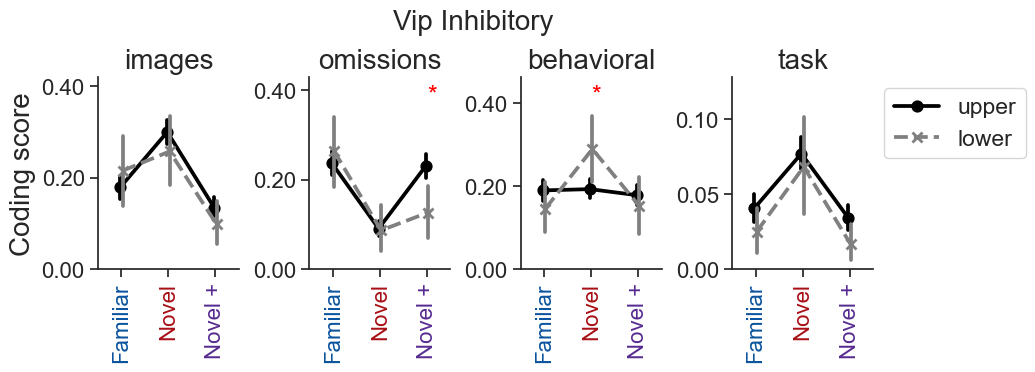

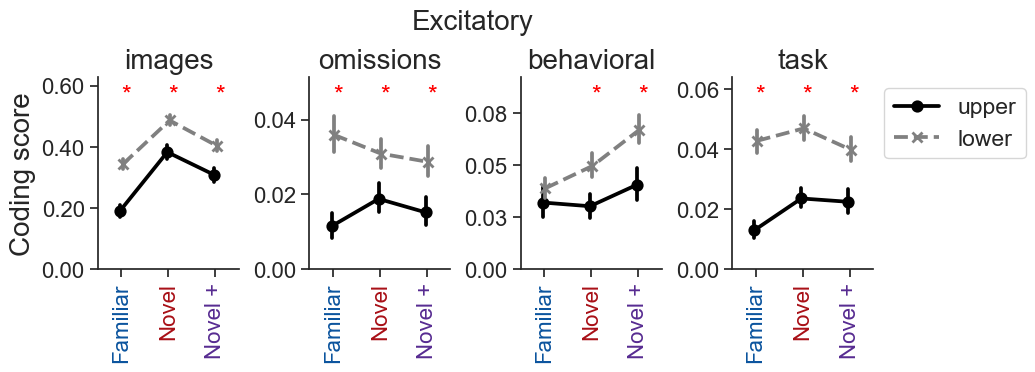

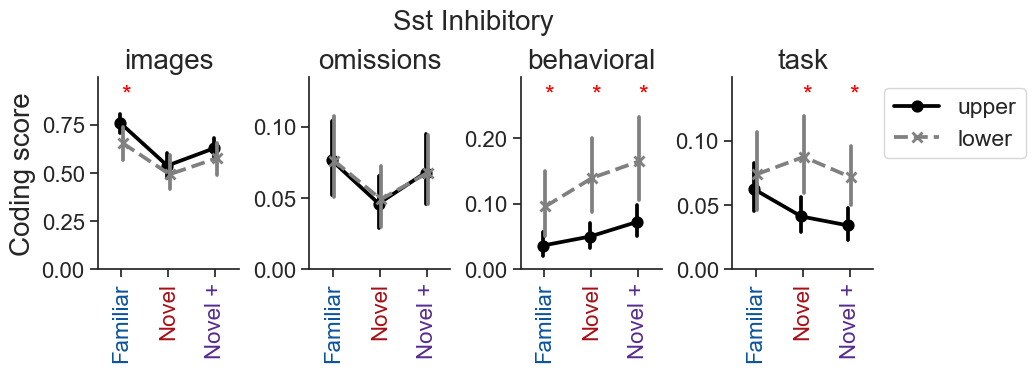

In [ ]:
summary = gvt.plot_population_averages_by_depth(results_pivoted, run_params, 
                                      dropouts_to_show = ['all-images','omissions','behavioral','task'],
                                      sharey=False, include_zero_cells=True, add_stats=True, 
                                      extra='', equipment="mesoscope", area=['VISp', 'VISl'], savefig=False)


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


removing 1 problematic experiments


C:\Users\marinag\Documents\Code\visual_behavior_glm\visual_behavior_glm\GLM_visualization_tools.py:4210: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  data = all_data,
C:\Users\marinag\Documents\Code\visual_behavior_glm\visual_behavior_glm\GLM_visualization_tools.py:4210: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  data = all_data,
C:\Users\marinag\Documents\Code\visual_behavior_glm\visual_behavior_glm\GLM_visualization_tools.py:4210: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  data = all_data,
C:\Users\marinag\Documents\Code\visual_behavior_glm\visual_behavior_glm\GLM_visualization_tools.py:4210: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. 

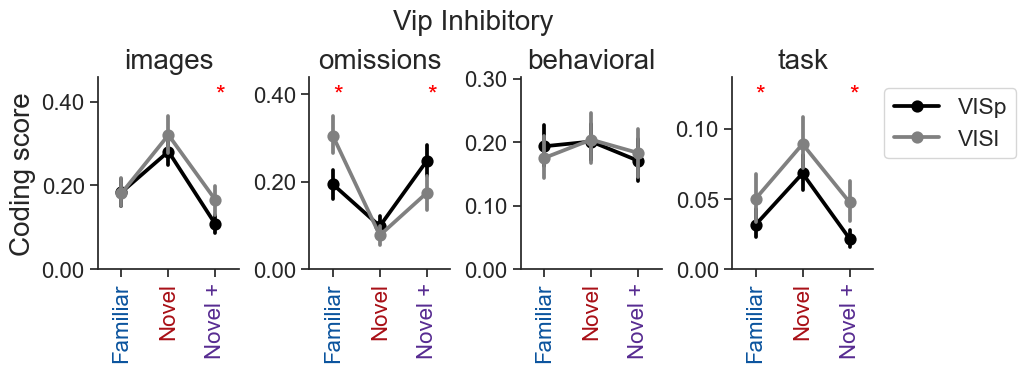

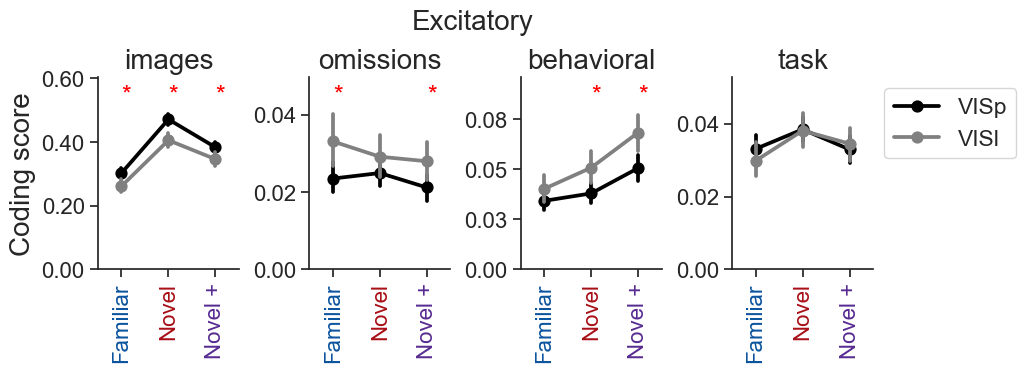

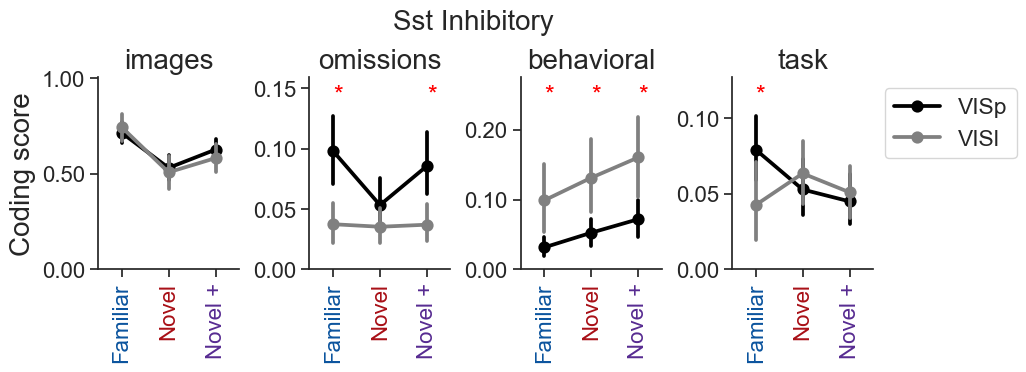

In [ ]:
summary = gvt.plot_population_averages_by_area(results_pivoted, run_params, 
                                     dropouts_to_show = ['all-images','omissions','behavioral','task'],
                                     sharey=False, include_zero_cells=True, add_stats=True, 
                                     extra='', equipment="mesoscope", savefig=False)

## Other figs

In [ ]:
# ### Main paper figures
# ## Panel A - Example inputs and outputs
# # Load example experiment, which takes a few minutes
# oeid = 967008471
# g=GLM(oeid, VERSION, use_previous_fit=True, log_results=False, log_weights=False)

# # Plot Inputs and model outputs for an example cell
# cell_specimen_id = 1086492467
# gsm.plot_glm_example(g,cell_specimen_id, run_params)


In [ ]:
# ## Panel B - Omission kernel heatmap for familiar sessions
# # This generates several figures, Panel B is `omissions_heatmap_with_dropout_Familiar.svg`
# gvt.kernel_evaluation(weights_df, run_params, 'all-images', session_filter=['Familiar'])


In [ ]:
# ## Panel B - Omission kernel heatmap for familiar sessions
# # This generates several figures, Panel B is `omissions_heatmap_with_dropout_Familiar.svg`
# gvt.kernel_evaluation(weights_df, run_params, 'omissions', session_filter=['Familiar'])


In [ ]:

# ## Panel E - Dropout averages for experience and cre-line
# '''
#     Returns a dictionary containing two entries for each dropout in
#     `dropouts_to_show`. The default option is the 4 primary dropouts, but the 
#     supplemental figures below use different dropouts.

#     "<dropout> stats" is a dictionary, which has a 2-tuple value for each cell type
#         The stats are computed in `gvt.test_significant_dropout_averages` 
#         The first entry is the results of scipy.stats.f_oneway anova test comparing
#             across experience levels
#         The second entry is the results of multiple comparison adjusted tukey tests
#             between each individual experience level comparison.

#     "<dropout> data" is a dictionary of cell types and data filters.
#         "<cell type> all data" is a pandas "describe()" output on all cells
#         "<cell type> matched data" is just for matched cells
#         "<cell type> strict matched data" is available only if requested 
# '''
# stats_E = gvt.plot_population_averages(results_pivoted, run_params) 

# ## Panel F - Coding fraction by experience/cre
# # Returns a dataframe with rows for cre/experience, and columns with the fraction of
# # cells coding for each regressor, and the CI value (which is the value +/- from the mean)
# stats_F = gvt.plot_fraction_summary_population(results_pivoted, run_params)

# ## New Panel B, replaces D,E,F
# stats_B = gvt.plot_dropout_summary_population_cdf(results_pivoted, run_params)


#### Revise kernel heatmaps

In [ ]:
# # Set up time vectors.
# if kernel in ['preferred_image', 'all-images']:
#     run_params['kernels'][kernel] = run_params['kernels']['image0'].copy()
# if kernel == 'all-omissions':
#     run_params['kernels'][kernel] = run_params['kernels']['omissions'].copy()
#     run_params['kernels'][kernel]['length'] = run_params['kernels']['omissions']['length'] + run_params['kernels']['post-omissions']['length']
# if kernel == 'all-hits':
#     run_params['kernels'][kernel] = run_params['kernels']['hits'].copy()
#     run_params['kernels'][kernel]['length'] = run_params['kernels']['hits']['length'] + run_params['kernels']['post-hits']['length']   
# if kernel == 'all-misses':
#     run_params['kernels'][kernel] = run_params['kernels']['misses'].copy()
#     run_params['kernels'][kernel]['length'] = run_params['kernels']['misses']['length'] + run_params['kernels']['post-misses']['length']   
# if kernel == 'all-passive_change':
#     run_params['kernels'][kernel] = run_params['kernels']['passive_change'].copy()
#     run_params['kernels'][kernel]['length'] = run_params['kernels']['passive_change']['length'] + run_params['kernels']['post-passive_change']['length']   
# if kernel == 'task':
#     run_params['kernels'][kernel] = run_params['kernels']['hits'].copy()   
# time_vec = np.arange(run_params['kernels'][kernel]['offset'], run_params['kernels'][kernel]['offset'] + run_params['kernels'][kernel]['length'],1/31)
# time_vec = np.round(time_vec,2)
# if 'image' in kernel:
#     time_vec = time_vec[:-1]
# if ('omissions' == kernel) & ('post-omissions' in run_params['kernels']):
#     time_vec = time_vec[:-1]
# if ('hits' == kernel) & ('post-hits' in run_params['kernels']):
#     time_vec = time_vec[:-1]
# if ('misses' == kernel) & ('post-misses' in run_params['kernels']):
#     time_vec = time_vec[:-1]
# if ('passive_change' == kernel) & ('post-passive_change' in run_params['kernels']):
#     time_vec = time_vec[:-1]

In [ ]:
     
    # # Plot Heat maps
    # sst_sorted = sst[:,np.argsort(np.argmax(sst,axis=0))]
    # vip_sorted = vip[:,np.argsort(np.argmax(vip,axis=0))]
    # slc_sorted = slc[:,np.argsort(np.argmax(slc,axis=0))]
    # if plot_dropout_sorted:
    #     sst_drop_sorted = sst[:,sst_drop.values.argsort()]
    #     vip_drop_sorted = vip[:,vip_drop.values.argsort()] 
    #     slc_drop_sorted = slc[:,slc_drop.values.argsort()]
    # weights_sorted = np.hstack([slc_sorted,sst_sorted, vip_sorted])
    # cbar = ax[0,1].imshow(weights_sorted.T,aspect='auto',extent=[time_vec[0], time_vec[-1], 0, np.shape(weights_sorted)[1]],cmap='PRGn')
    # cbar.set_clim(-np.nanpercentile(np.abs(weights_sorted),95),np.nanpercentile(np.abs(weights_sorted),95))
    # color_bar=fig.colorbar(cbar, ax=ax[0,1])
    # color_bar.ax.set_ylabel('Weights')   
    # ax[0,1].set_ylabel('{0} Cells\n sorted by peak'.format(np.shape(weights_sorted)[1]))
    # ax[0,1].set_xlabel('Time (s)')
    # ax[0,1].axhline(np.shape(vip)[1],color='k',linewidth='1')
    # ax[0,1].axhline(np.shape(vip)[1] + np.shape(sst)[1],color='k',linewidth='1')
    # ax[0,1].set_yticks([np.shape(vip)[1]/2,np.shape(vip)[1]+np.shape(sst)[1]/2, np.shape(vip)[1]+np.shape(sst)[1]+np.shape(slc)[1]/2])
    # ax[0,1].set_yticklabels(['Vip','Sst','Exc'])
    # ax[0,1].set_title(kernel)

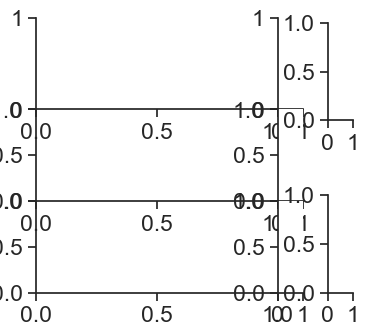

In [ ]:
from mpl_toolkits.axes_grid1 import Divider, Size


height = 4
if kernel == 'all_images':
    kernel_length = run_params['kernels']['all-images']['length']       
else:
    kernel_length = run_params['kernels'][kernel]['length']
width=4+((4/3)*kernel_length)
pre_horz_offset = 1.5
post_horz_offset = 2.5
vertical_offset = .75
fig = plt.figure(figsize=(width,height))
h = [Size.Fixed(pre_horz_offset),Size.Fixed(width-pre_horz_offset-post_horz_offset-.25)]
v = [Size.Fixed(vertical_offset),Size.Fixed((height-vertical_offset-.5)/3)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
ax3 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))
v = [Size.Fixed(vertical_offset+(height-vertical_offset-.5)/3),Size.Fixed((height-vertical_offset-.5)/3)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
ax2 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))
v = [Size.Fixed(vertical_offset+2*(height-vertical_offset-.5)/3),Size.Fixed((height-vertical_offset-.5)/3)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
ax1 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))

h = [Size.Fixed(width-post_horz_offset-.25),Size.Fixed(.25)]
v = [Size.Fixed(vertical_offset+2*(height-vertical_offset-.5)/3),Size.Fixed((height-vertical_offset-.5)/3)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
dax1 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))  
v = [Size.Fixed(vertical_offset+(height-vertical_offset-.5)/3),Size.Fixed((height-vertical_offset-.5)/3)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
dax2 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))  
v = [Size.Fixed(vertical_offset),Size.Fixed((height-vertical_offset-.5)/3)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
dax3 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))  

# cbar 1
h = [Size.Fixed(width-post_horz_offset+.25),Size.Fixed(.25)]
v = [Size.Fixed(vertical_offset+(height-vertical_offset-.5)/2)+.35,Size.Fixed((height-vertical_offset-.5)/2.5-.125)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
cax1 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))  

# cbar 2
h = [Size.Fixed(width-post_horz_offset+.25),Size.Fixed(.25)]
v = [Size.Fixed(vertical_offset/1),Size.Fixed((height-vertical_offset-.5)/2.5-.125)]
divider = Divider(fig, (0,0,1,1),h,v,aspect=False)
cax2 = fig.add_axes(divider.get_position(), axes_locator=divider.new_locator(nx=1,ny=1))  



### Heatmap of coding scores for matched cells split by cre line

In [ ]:
# def restructure_results_to_get_coding_by_experience_for_matched_cells(glm_version, results_pivoted, matched_experiments, matched_cells):
#     # limit to matched cells 
#     results_pivoted = results_pivoted[results_pivoted.ophys_experiment_id.isin(matched_experiments)].copy()
#     results_pivoted = results_pivoted[results_pivoted.cell_specimen_id.isin(matched_cells)].copy()

#     # drop duplicates
#     results_pivoted = results_pivoted.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])
#     print(len(results_pivoted), 'len(results_pivoted) after dropping duplicates')
            
#     print(len(results_pivoted.cell_specimen_id.unique()),
#         'cells in results_pivoted after limiting to strictly matched cells')

#     # limit to features used for clustering
#     # features = processing.get_feature_labels_for_clustering()
#     features = ['all-images', 'omissions', 'task', 'behavioral']
#     features = [*features, 'ophys_experiment_id']
#     results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted, features)

#     # flip sign so coding scores are positive
#     results_pivoted = processing.flip_sign_of_dropouts(results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

#     results_pivoted = results_pivoted.rename(columns={'all-images':'images', 'behavioral':'behavior'})
#     # now drop ophys_experiment_id
#     results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

#     results_pivoted['experience_level'] = [utils.convert_experience_level(experience_level) for experience_level in results_pivoted.experience_level.values]

#     feature_matrix = processing.get_feature_matrix_for_clustering(results_pivoted, glm_version, save_dir=save_dir)

#     return feature_matrix

In [ ]:
feature_matrix = processing.restructure_results_to_get_coding_by_experience_for_matched_cells(glm_version, results_pivoted, matched_experiments, matched_cells)
   

11763 len(results_pivoted) after dropping duplicates
3921 cells in results_pivoted after limiting to strictly matched cells
No duplicated cells found
3921


In [ ]:
cre_lines = utils.get_cre_lines()
n_cells_dict = {}
for cre_line in cre_lines: 
    cre_cells = matched_cells_table[matched_cells_table.cre_line==cre_line].cell_specimen_id.unique()
    n_cells_dict[cre_line] = len(cre_cells)

In [ ]:
n_cells_dict

{'Slc17a7-IRES2-Cre': 3306, 'Sst-IRES-Cre': 200, 'Vip-IRES-Cre': 415}

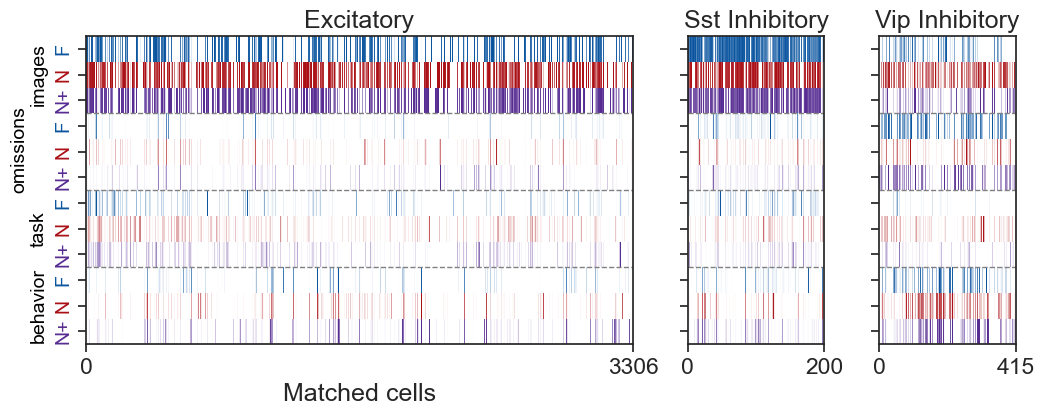

In [ ]:
figsize = (12, 4)
fig, ax = plt.subplots(1, 3, figsize=figsize, gridspec_kw={'width_ratios': [4, 1, 1]})
for i, cre_line in enumerate(cre_lines):
    cre_cells = matched_cells_table[matched_cells_table.cre_line==cre_line].cell_specimen_id.unique()
    cre_coding_scores = feature_matrix.loc[cre_cells]

    # remap to new colors
    coding_scores_remapped, coding_score_cmap, vmax = plotting.remap_coding_scores_to_session_colors(cre_coding_scores)

    # translate so rows are feature-exp combos and columns are cells
    coding_scores_remapped = coding_scores_remapped.T.copy()

    # relabel dataframe indices to be abbreviated experience labels (without feature categories)
    new_labels = plotting.get_clean_labels_for_coding_scores_df(coding_scores_remapped, columns=False)
    coding_scores_remapped.index = new_labels

    ax[i] = sns.heatmap(coding_scores_remapped, cmap=coding_score_cmap, ax=ax[i], vmin=0, vmax=vmax,
                        robust=True, cbar=False, cbar_kws={"drawedges": False, "shrink": 0.7, "label": 'coding score'})

    # dotted gray lines in between feature categories
    for y in [3, 6, 9]:
        ax[i].axhline(y=y, xmin=0, xmax=coding_scores_remapped.shape[0], color='gray', linestyle='--', linewidth=1)

    # y-axis formtting
    # ax.set_ylim(ax.get_ylim()[::-1])  # flip y axes so larger clusters are on top
    ax[i].set_ylabel('')
    ax[i].set_ylim(0, coding_scores_remapped.shape[0])
    # set y ticks to F, N, N+ with correct colors
    ax[i].set_yticks(np.arange(0.5, coding_scores_remapped.shape[0]+0.5, 1))
    ax[i].set_yticklabels([])
    ax[i].set_ylim(ax[i].get_ylim()[::-1])  # flip y axes so image clusters are on top

    # x-axis formatting
    ax[i].set_xlim(0, coding_scores_remapped.shape[1])
    ax[i].set_xticks([0, coding_scores_remapped.shape[1]])
    ax[i].set_xticklabels((0, coding_scores_remapped.shape[1]), rotation=0)
    ax[i].set_xlabel('')

    ax[i].set_title(utils.convert_cre_line_to_cell_type(cre_line))

    sns.despine(ax=ax[i], top=False, right=False, left=False, bottom=False, offset=None, trim=False)


# y axis formatting - first axis only
ax[0].set_xlabel('Matched cells')
ax[0].set_yticklabels(new_labels, rotation=90, fontsize=14)
plotting.color_yaxis_labels_by_experience(ax[0])

# label feature categories on left
rotation = 90
fontsize = 14
features = processing.get_feature_labels_for_clustering()
for i, feature in enumerate(features):
    if feature == 'all-images':
        features[i] = 'images'
ax[0].text(s=features[0], x=-230, y=1.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='right')
ax[0].text(s=features[1], x=-350, y=4.4, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='right')
ax[0].text(s=features[2], x=-230, y=7.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='right')
ax[0].text(s=features[3], x=-230, y=10.5, rotation=rotation, color='black', fontsize=fontsize, va='center', ha='right')

plt.subplots_adjust(wspace=0.2)

## Correlate model free metrics with coding score metrics

#### Use function to create or load merged metrics table

In [ ]:
# coding_score_metrics = processing.generate_coding_score_metrics_table(results_pivoted, save_dir=os.path.join(platform_cache_dir, 'glm_results'))

In [ ]:
model_free_metrics_file = os.path.join(platform_cache_dir, 'cell_metrics', 'merged_cell_metrics_table_events_platform_experiment_table.csv')
response_metrics = pd.read_csv(model_free_metrics_file, index_col=0)

# merge in metadata
response_metrics = response_metrics.merge(platform_cells_table, on=['cell_specimen_id', 'ophys_experiment_id', 'experience_level'])
response_metrics['identifier'] = [str(response_metrics.iloc[row].ophys_experiment_id)+'_'+str(response_metrics.iloc[row].cell_specimen_id) for row in range(len(response_metrics))]

# check numbers
print(len(response_metrics.ophys_experiment_id.unique()))
print(len(response_metrics.cell_specimen_id.unique()))



402
14495


In [ ]:
response_metrics.experience_level.unique()

array(['Familiar', 'Novel', 'Novel +'], dtype=object)

### Plot correlation of coding scores and metrics

In [ ]:
# make coding scores positive
results_pivoted[processing.get_features_for_clustering()] = np.abs(results_pivoted[processing.get_features_for_clustering()])


In [ ]:
tmp_results = results_pivoted[processing.get_features_for_clustering()+['identifier']]
# tmp_results[processing.get_features_for_clustering()] = np.abs(tmp_results[processing.get_features_for_clustering()])
metric_data = response_metrics.merge(tmp_results, on='identifier')
metric_data['images'] = metric_data['all-images']
metric_data['behavior'] = metric_data['behavioral']
print(len(metric_data.ophys_experiment_id.unique()))
print(len(metric_data.cell_specimen_id.unique()))

402
14495


In [ ]:
# def plot_metric_feature_coding_relationship(metric_data, x, y, xlabel=None, ylabel=None, title=None,
#                                             color_by_cre=True, xlims=(-0.1, 1.1), ylims=(-0.1, 1.1), 
#                                             ax=None, save_dir=None):

#     import scipy 

#     cell_type_colors = utils.get_cell_type_colors()
#     cre_lines = np.sort(metric_data.cre_line.unique())

#     if xlabel is None: 
#         xlabel = x
#     if ylabel is None: 
#         ylabel = y

#     if ax is None:
#         figsize = (4,4)
#         fig, ax = plt.subplots(figsize=figsize)
#     # only include cells that code for this feature
#     data = metric_data[metric_data[x]>0]
#     if color_by_cre: 
#         for i,cre_line in enumerate(cre_lines): 
#             ax = sns.kdeplot(data=data[data.cre_line==cre_line], x=x, y=y, 
#                             label=utils.get_abbreviated_cell_type(cre_line), color=cell_type_colors[i], 
#                             fill=False, levels=10, thresh=.2, cut=0, ax=ax)
#         ax.legend(loc='upper left', fontsize='small')
#         title = 'cre_colors'
#     else: 
#         corr_data = data[[x, y, 'cre_line', 'cell_specimen_id']]
#         corr_data = corr_data.dropna()
#         r, p = scipy.stats.pearsonr(corr_data[x].values, corr_data[y].values)
#         legend = 'r = '+str(np.round(r, 2))+', p = '+ str(np.round(p, 4))+'\nn = '+str(len(corr_data.cell_specimen_id.unique()))+' cells'
#         ax = sns.kdeplot(data=data, x=x, y=y, color='gray', levels=15, thresh=.1, cut=0, fill=False, label=legend, ax=ax)
#         if xlims: 
#             x_loc = xlims[0]
#             y_loc = ylims[1]-0.15
#         else:
#             x_loc=0
#             y_loc=0.9
#         ax.text(s=legend, x=x_loc, y=y_loc, fontsize=14)
#         # ax.legend()
#         ax.set_title(title)
    
#     if xlims is not None: 
#         ax.set_xlim(xlims)
#     if ylims is not None: 
#         ax.set_ylim(ylims)
#     ax.set_ylabel(ylabel)
#     ax.set_xlabel(xlabel)

#     if save_dir:
#         utils.save_figure(fig, figsize, save_dir, 'metric_feature_coding_correlations', x+'_'+y+'_'+title)

#     return ax

In [ ]:
len(metric_data.cell_specimen_id.unique())

14495

In [ ]:
data = metric_data[metric_data[x]>0]
print(len(data.cell_specimen_id.unique()))
corr_data = data[[x, y, 'cre_line', 'cell_specimen_id']]
corr_data = corr_data.dropna()
print(len(corr_data.cell_specimen_id.unique()))

8586
8586


<Axes: title={'center': 'all cells'}, xlabel='Image coding score', ylabel='Image selectivity'>

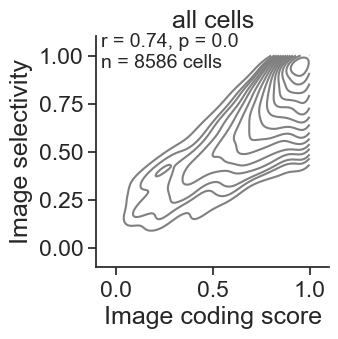

In [ ]:
x = 'images'
y = 'lifetime_sparseness_images'
xlabel = 'Image coding score'
ylabel = 'Image selectivity'
title = 'all cells'

plotting.plot_metric_feature_coding_relationship(metric_data, x, y, xlabel=xlabel, ylabel=ylabel, title=title, 
                                        color_by_cre=False, save_dir=save_dir)

12826
7508
468
400
1201
678


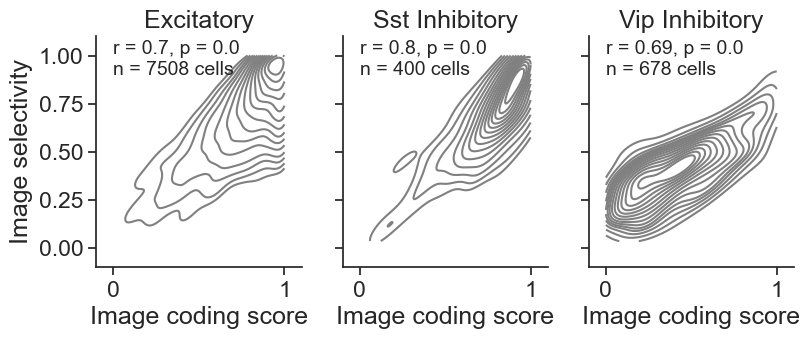

In [ ]:
x = 'images'
y = 'lifetime_sparseness_images'
xlabel = 'Image coding score'
ylabel = 'Image selectivity'
title = ''

figsize = (9, 3)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
for i,cre_line in enumerate(cre_lines): 
    title = utils.convert_cre_line_to_cell_type(cre_line)
    ax[i] = plotting.plot_metric_feature_coding_relationship(metric_data[metric_data.cre_line==cre_line],
                                            x, y, xlabel=xlabel, ylabel=ylabel, title=title, 
                                            color_by_cre=False, ax=ax[i])
if save_dir:
    utils.save_figure(fig, figsize, save_dir, 'metric_feature_coding_correlations', x+'_'+y+'_all_cre')

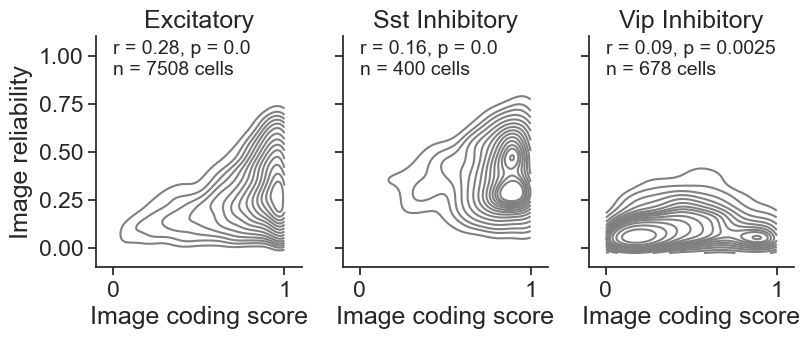

In [ ]:
x = 'images'
y = 'reliability_pref_image'
xlabel = 'Image coding score'
ylabel = 'Image reliability'
title = ''

figsize = (9, 3)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
for i,cre_line in enumerate(cre_lines): 
    title = utils.convert_cre_line_to_cell_type(cre_line)
    ax[i] = plotting.plot_metric_feature_coding_relationship(metric_data[metric_data.cre_line==cre_line],
                                            x, y, xlabel=xlabel, ylabel=ylabel, title=title, 
                                            color_by_cre=False, ax=ax[i])
if save_dir:
    utils.save_figure(fig, figsize, save_dir, 'metric_feature_coding_correlations', x+'_'+y+'_all_cre')

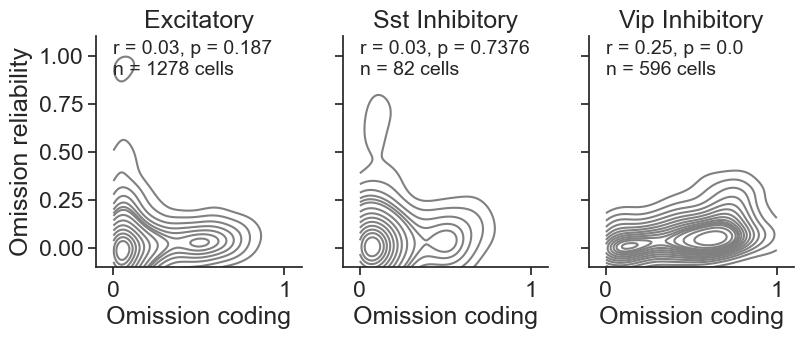

In [ ]:
x = 'omissions'
y = 'reliability_omissions'
xlabel = 'Omission coding'
ylabel = 'Omission reliability'

figsize = (9, 3)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
for i,cre_line in enumerate(cre_lines): 
    title = utils.convert_cre_line_to_cell_type(cre_line)
    ax[i] = plotting.plot_metric_feature_coding_relationship(metric_data[metric_data.cre_line==cre_line],
                                            x, y, xlabel=xlabel, ylabel=ylabel, title=title, 
                                            color_by_cre=False, ax=ax[i])
if save_dir:
    utils.save_figure(fig, figsize, save_dir, 'metric_feature_coding_correlations', x+'_'+y+'_all_cre')

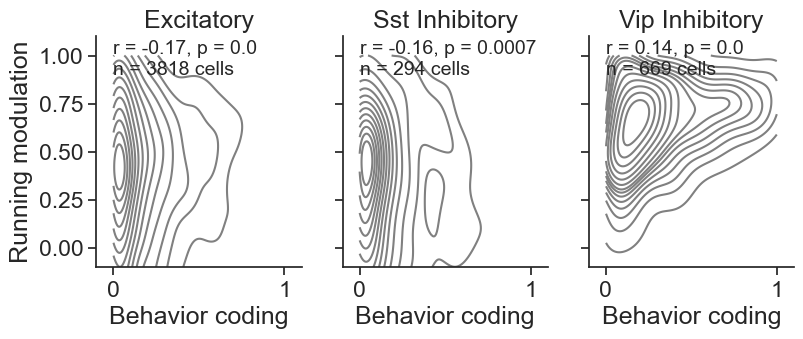

In [ ]:
x = 'behavior'
y = 'running_modulation_all_images'
xlabel = 'Behavior coding'
ylabel = 'Running modulation'

figsize = (9, 3)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
for i,cre_line in enumerate(cre_lines): 
    title = utils.convert_cre_line_to_cell_type(cre_line)
    ax[i] = plotting.plot_metric_feature_coding_relationship(metric_data[metric_data.cre_line==cre_line],
                                            x, y, xlabel=xlabel, ylabel=ylabel, title=title, 
                                            color_by_cre=False, ax=ax[i])
if save_dir:
    utils.save_figure(fig, figsize, save_dir, 'metric_feature_coding_correlations', x+'_'+y+'_all_cre')

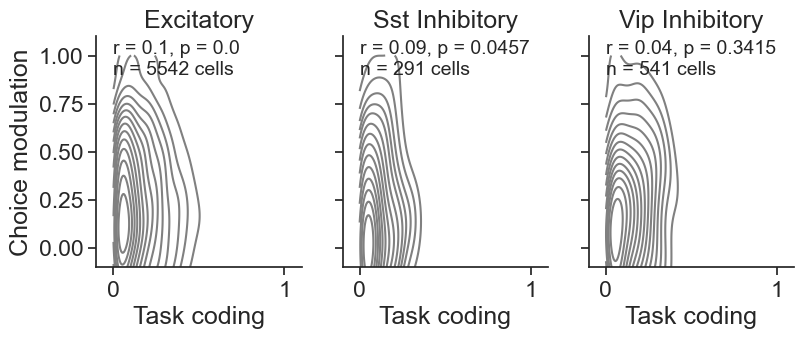

In [ ]:
x = 'task'
y = 'hit_miss_index'
xlabel = 'Task coding'
ylabel = 'Choice modulation'

figsize = (9, 3)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
for i,cre_line in enumerate(cre_lines): 
    title = utils.convert_cre_line_to_cell_type(cre_line)
    ax[i] = plotting.plot_metric_feature_coding_relationship(metric_data[metric_data.cre_line==cre_line],
                                            x, y, xlabel=xlabel, ylabel=ylabel, title=title, 
                                            color_by_cre=False, ax=ax[i])
if save_dir:
    utils.save_figure(fig, figsize, save_dir, 'metric_feature_coding_correlations', x+'_'+y+'_all_cre')


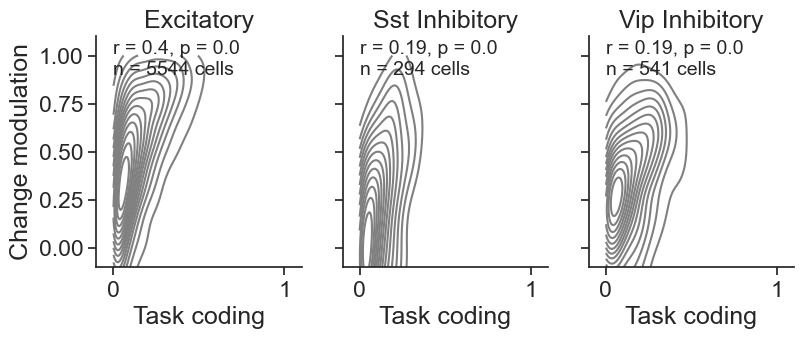

In [ ]:
x = 'task'
y = 'change_modulation_index'
xlabel = 'Task coding'
ylabel = 'Change modulation'

figsize = (9, 3)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharex=True, sharey=True)
for i,cre_line in enumerate(cre_lines): 
    title = utils.convert_cre_line_to_cell_type(cre_line)
    ax[i] = plotting.plot_metric_feature_coding_relationship(metric_data[metric_data.cre_line==cre_line],
                                            x, y, xlabel=xlabel, ylabel=ylabel, title=title, 
                                            color_by_cre=False, ax=ax[i])
if save_dir:
    utils.save_figure(fig, figsize, save_dir, 'metric_feature_coding_correlations', x+'_'+y+'_all_cre')


#### Load cell trace SNR values

In [ ]:
import visual_behavior.ophys.response_analysis.cell_metrics as cm

In [ ]:
data_type = 'dff'
condition = 'traces'
stimuli = 'full_session'
session_subset='full_session'
inclusion_criteria='platform_experiment_table', 

trace_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

getting experiment table for March and August releases from lims


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\tables\util\prior_exposure_processing.py:178: FutureWarning: Not prepending group keys to the result index o

excluding Ai94 data
there are 1874 experiments after filtering for inclusion criteria -  ('platform_experiment_table',)


  0%|          | 0/1874 [00:00<?, ?it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\951980471_traces_full_session_full_session_dff.h5


  0%|          | 1/1874 [00:00<20:31,  1.52it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\951980473_traces_full_session_full_session_dff.h5


  0%|          | 2/1874 [00:01<20:34,  1.52it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\951980475_traces_full_session_full_session_dff.h5


  0%|          | 3/1874 [00:01<19:49,  1.57it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\951980479_traces_full_session_full_session_dff.h5


  0%|          | 4/1874 [00:02<16:12,  1.92it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\951980481_traces_full_session_full_session_dff.h5


  0%|          | 5/1874 [00:02<16:14,  1.92it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\951980484_traces_full_session_full_session_dff.h5


  0%|          | 8/1874 [00:03<11:13,  2.77it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\951980486_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\953659743_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\953659745_traces_full_session_full_session_dff.h5


  1%|          | 11/1874 [00:04<06:34,  4.73it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\953659749_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\953659752_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958527464_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958527471_traces_full_session_full_session_dff.h5


  1%|          | 13/1874 [00:04<04:55,  6.29it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958527474_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958527479_traces_full_session_full_session_dff.h5


  1%|          | 16/1874 [00:04<04:53,  6.34it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958527481_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958527485_traces_full_session_full_session_dff.h5


  1%|          | 19/1874 [00:05<03:59,  7.75it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958527488_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\956941841_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\956941844_traces_full_session_full_session_dff.h5


  1%|          | 21/1874 [00:05<03:28,  8.89it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\956941846_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\957759562_traces_full_session_full_session_dff.h5


  1%|          | 23/1874 [00:05<03:46,  8.19it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\957759564_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\957759566_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\957759570_traces_full_session_full_session_dff.h5


  1%|▏         | 25/1874 [00:06<05:25,  5.68it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\957759572_traces_full_session_full_session_dff.h5


  1%|▏         | 28/1874 [00:06<04:44,  6.50it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\957759574_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\957759576_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958741219_traces_full_session_full_session_dff.h5


  2%|▏         | 32/1874 [00:06<03:13,  9.50it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958741222_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958741230_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958741232_traces_full_session_full_session_dff.h5


  2%|▏         | 34/1874 [00:06<02:53, 10.60it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958741234_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959388788_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959388790_traces_full_session_full_session_dff.h5


  2%|▏         | 36/1874 [00:07<04:29,  6.81it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959388792_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959388796_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959388798_traces_full_session_full_session_dff.h5


  2%|▏         | 40/1874 [00:07<03:07,  9.76it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959388800_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959388802_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960410023_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960410026_traces_full_session_full_session_dff.h5


  2%|▏         | 42/1874 [00:07<02:49, 10.81it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960410028_traces_full_session_full_session_dff.h5
generating trace metrics for 960410028 dff
generating trace metrics for 960410028


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
  2%|▏         | 44/1874 [00:22<1:05:29,  2.15s/it]

metrics generated for dff traces full_session full_session interpolate: True
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960410038_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960410042_traces_full_session_full_session_dff.h5


  2%|▏         | 46/1874 [00:22<42:15,  1.39s/it]  

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993862620_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994053903_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994278281_traces_full_session_full_session_dff.h5


  3%|▎         | 50/1874 [00:22<19:46,  1.54it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994790561_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994955425_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\995280513_traces_full_session_full_session_dff.h5


  3%|▎         | 52/1874 [00:23<14:27,  2.10it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\995439942_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\995622557_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\792815735_traces_full_session_full_session_dff.h5


  3%|▎         | 56/1874 [00:23<08:14,  3.68it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\795073741_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\795953296_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\796108483_traces_full_session_full_session_dff.h5


  3%|▎         | 58/1874 [00:23<07:26,  4.07it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\796308505_traces_full_session_full_session_dff.h5


  3%|▎         | 59/1874 [00:24<07:46,  3.89it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\798404219_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\826587940_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\830093338_traces_full_session_full_session_dff.h5


  3%|▎         | 63/1874 [00:24<05:05,  5.92it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\830700800_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\832115263_traces_full_session_full_session_dff.h5


  3%|▎         | 65/1874 [00:24<04:14,  7.09it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\833631914_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\836258957_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\836911939_traces_full_session_full_session_dff.h5


  4%|▎         | 67/1874 [00:24<04:01,  7.47it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992870935_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993344852_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993594789_traces_full_session_full_session_dff.h5


  4%|▍         | 71/1874 [00:25<03:17,  9.12it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993863108_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994056251_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994278291_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994790553_traces_full_session_full_session_dff.h5


  4%|▍         | 74/1874 [00:25<03:33,  8.41it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994955433_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\871155338_traces_full_session_full_session_dff.h5


  4%|▍         | 77/1874 [00:26<03:29,  8.57it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\872433717_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\873156540_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\873972085_traces_full_session_full_session_dff.h5


  4%|▍         | 79/1874 [00:26<03:05,  9.69it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877022592_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\878363088_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\879331157_traces_full_session_full_session_dff.h5


  4%|▍         | 83/1874 [00:26<02:38, 11.29it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\880374622_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\880961028_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939327156_traces_full_session_full_session_dff.h5


  5%|▍         | 85/1874 [00:26<02:37, 11.39it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940354166_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940852658_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\942043482_traces_full_session_full_session_dff.h5


  5%|▍         | 89/1874 [00:27<02:21, 12.60it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\943151552_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\944366183_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\932331541_traces_full_session_full_session_dff.h5


  5%|▍         | 91/1874 [00:27<02:15, 13.17it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\933338719_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\934476801_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938001540_traces_full_session_full_session_dff.h5


  5%|▍         | 93/1874 [00:27<02:12, 13.48it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939319851_traces_full_session_full_session_dff.h5


  5%|▌         | 95/1874 [00:27<02:50, 10.44it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940354181_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518876_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518878_traces_full_session_full_session_dff.h5


  5%|▌         | 99/1874 [00:27<02:21, 12.51it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518880_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518885_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518887_traces_full_session_full_session_dff.h5


  5%|▌         | 103/1874 [00:28<02:26, 12.09it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518889_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518891_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518893_traces_full_session_full_session_dff.h5


  6%|▌         | 105/1874 [00:28<02:18, 12.77it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989213058_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989213059_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989213060_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989213061_traces_full_session_full_session_dff.h5


  6%|▌         | 109/1874 [00:28<02:22, 12.36it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989213062_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989213063_traces_full_session_full_session_dff.h5


  6%|▌         | 111/1874 [00:28<02:15, 13.00it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989213064_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989213065_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989610985_traces_full_session_full_session_dff.h5


  6%|▌         | 113/1874 [00:28<02:17, 12.76it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989610986_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989610987_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989610988_traces_full_session_full_session_dff.h5


  6%|▌         | 117/1874 [00:29<02:18, 12.72it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989610989_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989610990_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989610991_traces_full_session_full_session_dff.h5


  6%|▋         | 119/1874 [00:29<02:15, 12.99it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989610992_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990400775_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990400777_traces_full_session_full_session_dff.h5


  7%|▋         | 123/1874 [00:29<02:27, 11.85it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990400778_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990400779_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990400780_traces_full_session_full_session_dff.h5


  7%|▋         | 125/1874 [00:29<02:17, 12.72it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990400781_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990400782_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990400783_traces_full_session_full_session_dff.h5


  7%|▋         | 129/1874 [00:30<02:19, 12.50it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990681006_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990681007_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990681008_traces_full_session_full_session_dff.h5


  7%|▋         | 131/1874 [00:30<02:17, 12.68it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990681009_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990681010_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990681012_traces_full_session_full_session_dff.h5


  7%|▋         | 133/1874 [00:30<02:21, 12.27it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990681013_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990681014_traces_full_session_full_session_dff.h5


  7%|▋         | 137/1874 [00:30<02:20, 12.34it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\991852000_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\991852001_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\991852002_traces_full_session_full_session_dff.h5


  7%|▋         | 139/1874 [00:31<02:30, 11.56it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\991852003_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\991852004_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\991852005_traces_full_session_full_session_dff.h5


  8%|▊         | 143/1874 [00:31<02:15, 12.78it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\991852006_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\991852008_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1008408502_traces_full_session_full_session_dff.h5


  8%|▊         | 145/1874 [00:31<02:13, 12.94it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1008408506_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1008408508_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1008408509_traces_full_session_full_session_dff.h5


  8%|▊         | 149/1874 [00:31<02:17, 12.55it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1008408511_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1008408512_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1008408514_traces_full_session_full_session_dff.h5


  8%|▊         | 151/1874 [00:32<02:16, 12.60it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495873_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495876_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495879_traces_full_session_full_session_dff.h5


  8%|▊         | 155/1874 [00:32<02:53,  9.89it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495880_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495882_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495883_traces_full_session_full_session_dff.h5


  8%|▊         | 159/1874 [00:32<02:34, 11.09it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495885_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495875_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010092798_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010092802_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010092804_traces_full_session_full_session_dff.h5


  9%|▊         | 161/1874 [00:33<02:52,  9.92it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010092806_traces_full_session_full_session_dff.h5


  9%|▊         | 163/1874 [00:33<03:48,  7.49it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010092809_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010092810_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010092812_traces_full_session_full_session_dff.h5


  9%|▉         | 167/1874 [00:33<02:53,  9.83it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010092800_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010556648_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010556652_traces_full_session_full_session_dff.h5


  9%|▉         | 171/1874 [00:34<02:25, 11.73it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010556655_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010556658_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010556659_traces_full_session_full_session_dff.h5


  9%|▉         | 173/1874 [00:34<02:18, 12.30it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010556662_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010556650_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010839667_traces_full_session_full_session_dff.h5


  9%|▉         | 175/1874 [00:34<02:19, 12.15it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010839670_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010839672_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010839673_traces_full_session_full_session_dff.h5


 10%|▉         | 179/1874 [00:34<02:18, 12.26it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010839675_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010839676_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010839678_traces_full_session_full_session_dff.h5


 10%|▉         | 181/1874 [00:34<02:13, 12.65it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010839669_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1011771121_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1011771132_traces_full_session_full_session_dff.h5


 10%|▉         | 185/1874 [00:35<02:21, 11.92it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012165644_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012165647_traces_full_session_full_session_dff.h5


 10%|▉         | 187/1874 [00:35<02:24, 11.70it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012165650_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012165652_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012165653_traces_full_session_full_session_dff.h5


 10%|█         | 189/1874 [00:35<02:24, 11.69it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012165646_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012490778_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012490781_traces_full_session_full_session_dff.h5


 10%|█         | 193/1874 [00:35<02:22, 11.80it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012490784_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012490786_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012490787_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012490789_traces_full_session_full_session_dff.h5


 11%|█         | 197/1874 [00:36<02:06, 13.30it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012771655_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012771658_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012771660_traces_full_session_full_session_dff.h5


 11%|█         | 199/1874 [00:36<02:14, 12.44it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012771661_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012771663_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012771664_traces_full_session_full_session_dff.h5


 11%|█         | 203/1874 [00:36<02:28, 11.28it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012771666_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012771657_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965224600_traces_full_session_full_session_dff.h5


 11%|█         | 205/1874 [00:36<02:32, 10.94it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967008454_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967876201_traces_full_session_full_session_dff.h5


 11%|█         | 207/1874 [00:37<02:23, 11.63it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\968651977_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969809655_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\971280274_traces_full_session_full_session_dff.h5


 11%|█         | 209/1874 [00:37<02:15, 12.28it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972200901_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\935440133_traces_full_session_full_session_dff.h5


 11%|█▏        | 211/1874 [00:37<02:24, 11.51it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\936494970_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939327085_traces_full_session_full_session_dff.h5


 11%|█▏        | 215/1874 [00:37<02:30, 11.05it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940352367_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940852112_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\943151492_traces_full_session_full_session_dff.h5


 12%|█▏        | 217/1874 [00:37<02:17, 12.03it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\919314793_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\920211809_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\920976741_traces_full_session_full_session_dff.h5


 12%|█▏        | 221/1874 [00:38<02:26, 11.25it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\923100531_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\924108253_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\924798932_traces_full_session_full_session_dff.h5


 12%|█▏        | 223/1874 [00:38<02:23, 11.47it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\927048127_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\929132798_traces_full_session_full_session_dff.h5


 12%|█▏        | 227/1874 [00:38<02:21, 11.61it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1042126970_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1042387062_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1042639858_traces_full_session_full_session_dff.h5


 12%|█▏        | 229/1874 [00:39<02:11, 12.53it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1042895986_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1043834889_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1044448293_traces_full_session_full_session_dff.h5


 12%|█▏        | 231/1874 [00:39<02:09, 12.71it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853328115_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853962951_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\854703305_traces_full_session_full_session_dff.h5


 13%|█▎        | 235/1874 [00:39<02:12, 12.35it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\855577488_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\857658471_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\859147033_traces_full_session_full_session_dff.h5


 13%|█▎        | 237/1874 [00:39<02:27, 11.12it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\863735602_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1048483604_traces_full_session_full_session_dff.h5


 13%|█▎        | 239/1874 [00:39<02:28, 11.04it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1048483608_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1048483611_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1048483613_traces_full_session_full_session_dff.h5


 13%|█▎        | 241/1874 [00:40<02:26, 11.13it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1048483614_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1048483616_traces_full_session_full_session_dff.h5


 13%|█▎        | 245/1874 [00:40<02:33, 10.59it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1049610116_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1049610120_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1049610123_traces_full_session_full_session_dff.h5


 13%|█▎        | 249/1874 [00:40<02:16, 11.90it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1049610125_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1049610126_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1049610129_traces_full_session_full_session_dff.h5


 13%|█▎        | 251/1874 [00:40<02:15, 11.98it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050485645_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050485649_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050485652_traces_full_session_full_session_dff.h5


 14%|█▎        | 253/1874 [00:41<02:23, 11.31it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050485654_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050485655_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050485657_traces_full_session_full_session_dff.h5


 14%|█▎        | 257/1874 [00:41<02:19, 11.56it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050762966_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050762969_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050762972_traces_full_session_full_session_dff.h5


 14%|█▍        | 259/1874 [00:41<02:25, 11.09it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050762974_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050762975_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050762977_traces_full_session_full_session_dff.h5


 14%|█▍        | 263/1874 [00:42<02:38, 10.18it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1051249026_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1051249029_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1051249031_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1051460016_traces_full_session_full_session_dff.h5


 14%|█▍        | 267/1874 [00:42<02:47,  9.57it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1051460018_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608406_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608408_traces_full_session_full_session_dff.h5


 14%|█▍        | 269/1874 [00:42<02:36, 10.28it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608410_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608412_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608414_traces_full_session_full_session_dff.h5


 15%|█▍        | 273/1874 [00:43<02:23, 11.16it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608416_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608418_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608420_traces_full_session_full_session_dff.h5


 15%|█▍        | 275/1874 [00:43<02:15, 11.81it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300311_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300313_traces_full_session_full_session_dff.h5


 15%|█▍        | 277/1874 [00:43<02:28, 10.79it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300315_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300317_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300319_traces_full_session_full_session_dff.h5


 15%|█▍        | 281/1874 [00:43<02:19, 11.39it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300321_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300323_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300325_traces_full_session_full_session_dff.h5


 15%|█▌        | 283/1874 [00:43<02:15, 11.78it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977220481_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977220483_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977220485_traces_full_session_full_session_dff.h5


 15%|█▌        | 287/1874 [00:44<02:16, 11.61it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977220487_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977220489_traces_full_session_full_session_dff.h5


 15%|█▌        | 289/1874 [00:44<02:23, 11.07it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977220491_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977220493_traces_full_session_full_session_dff.h5


 16%|█▌        | 291/1874 [00:44<02:21, 11.18it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977220495_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977975790_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977975792_traces_full_session_full_session_dff.h5


 16%|█▌        | 293/1874 [00:44<02:18, 11.42it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977975794_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977975796_traces_full_session_full_session_dff.h5


 16%|█▌        | 295/1874 [00:45<02:27, 10.70it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977975798_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977975800_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977975802_traces_full_session_full_session_dff.h5


 16%|█▌        | 299/1874 [00:45<02:11, 11.95it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977975804_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978284048_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978284050_traces_full_session_full_session_dff.h5


 16%|█▌        | 301/1874 [00:45<02:22, 11.05it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978284052_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978284054_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978284056_traces_full_session_full_session_dff.h5


 16%|█▋        | 305/1874 [00:45<02:05, 12.49it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978284060_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978284064_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978866896_traces_full_session_full_session_dff.h5


 16%|█▋        | 307/1874 [00:46<02:03, 12.65it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978866898_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978866900_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978866902_traces_full_session_full_session_dff.h5


 17%|█▋        | 311/1874 [00:46<01:57, 13.26it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978866904_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978866906_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978866908_traces_full_session_full_session_dff.h5


 17%|█▋        | 313/1874 [00:46<01:57, 13.33it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978866910_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1047025008_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1047612322_traces_full_session_full_session_dff.h5


 17%|█▋        | 315/1874 [00:46<01:58, 13.11it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1047824550_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1048044013_traces_full_session_full_session_dff.h5


 17%|█▋        | 319/1874 [00:47<02:29, 10.39it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1049332776_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050730726_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\848697604_traces_full_session_full_session_dff.h5


 17%|█▋        | 323/1874 [00:47<02:06, 12.28it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\849203586_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\855582981_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\856096766_traces_full_session_full_session_dff.h5


 17%|█▋        | 325/1874 [00:47<02:05, 12.34it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\856938751_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\857660011_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\862848066_traces_full_session_full_session_dff.h5


 17%|█▋        | 327/1874 [00:47<02:22, 10.87it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\864370674_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369355_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369356_traces_full_session_full_session_dff.h5


 18%|█▊        | 331/1874 [00:48<02:17, 11.25it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369357_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369358_traces_full_session_full_session_dff.h5


 18%|█▊        | 333/1874 [00:48<02:22, 10.81it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369359_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369360_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369361_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369362_traces_full_session_full_session_dff.h5


 18%|█▊        | 335/1874 [00:48<02:35,  9.92it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993619354_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993619355_traces_full_session_full_session_dff.h5


 18%|█▊        | 339/1874 [00:48<02:34,  9.95it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993619356_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993619361_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993619363_traces_full_session_full_session_dff.h5


 18%|█▊        | 341/1874 [00:49<02:24, 10.60it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891310_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891311_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891312_traces_full_session_full_session_dff.h5


 18%|█▊        | 343/1874 [00:49<02:20, 10.88it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891313_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891315_traces_full_session_full_session_dff.h5


 19%|█▊        | 347/1874 [00:49<02:32,  9.98it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891316_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891318_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082654_traces_full_session_full_session_dff.h5


 19%|█▊        | 349/1874 [00:49<02:35,  9.79it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082656_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082660_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082661_traces_full_session_full_session_dff.h5


 19%|█▉        | 353/1874 [00:50<02:37,  9.66it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082663_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082664_traces_full_session_full_session_dff.h5


 19%|█▉        | 355/1874 [00:50<02:28, 10.24it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082666_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994278581_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994278583_traces_full_session_full_session_dff.h5


 19%|█▉        | 357/1874 [00:50<02:18, 10.93it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994278586_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994278587_traces_full_session_full_session_dff.h5


 19%|█▉        | 359/1874 [00:51<02:45,  9.14it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994278589_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994278592_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101388653_traces_full_session_full_session_dff.h5


 19%|█▉        | 361/1874 [00:51<02:39,  9.46it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101388656_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101388659_traces_full_session_full_session_dff.h5


 19%|█▉        | 364/1874 [00:51<02:51,  8.80it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101388662_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101564155_traces_full_session_full_session_dff.h5


 20%|█▉        | 367/1874 [00:51<02:38,  9.49it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101564161_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101564165_traces_full_session_full_session_dff.h5


 20%|█▉        | 369/1874 [00:52<02:25, 10.37it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101564168_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101751314_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101751316_traces_full_session_full_session_dff.h5


 20%|█▉        | 371/1874 [00:52<02:15, 11.13it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101751320_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101751323_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101751326_traces_full_session_full_session_dff.h5


 20%|█▉        | 374/1874 [00:52<02:49,  8.85it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1102263507_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1102263509_traces_full_session_full_session_dff.h5


 20%|██        | 375/1874 [00:52<02:46,  9.01it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1102263512_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1102263517_traces_full_session_full_session_dff.h5
generating trace metrics for 1102263517 dff
generating trace metrics for 1102263517


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
 20%|██        | 379/1874 [01:08<48:51,  1.96s/it]  

metrics generated for dff traces full_session full_session interpolate: True
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1102263520_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1102479792_traces_full_session_full_session_dff.h5


 20%|██        | 381/1874 [01:08<33:11,  1.33s/it]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1102479794_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1102479797_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1102479801_traces_full_session_full_session_dff.h5


 21%|██        | 385/1874 [01:08<16:19,  1.52it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1102479805_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\930996067_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\930996069_traces_full_session_full_session_dff.h5


 21%|██        | 387/1874 [01:08<11:49,  2.09it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\930996073_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\930996076_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\930996078_traces_full_session_full_session_dff.h5


 21%|██        | 389/1874 [01:09<09:06,  2.72it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\930996080_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\930996082_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\935514360_traces_full_session_full_session_dff.h5


 21%|██        | 393/1874 [01:09<05:31,  4.46it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\935514362_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\935514366_traces_full_session_full_session_dff.h5


 21%|██        | 395/1874 [01:09<04:28,  5.51it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\935514368_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\935514373_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\935514375_traces_full_session_full_session_dff.h5


 21%|██        | 397/1874 [01:09<03:52,  6.36it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\935514378_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\936500596_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\936500602_traces_full_session_full_session_dff.h5


 21%|██▏       | 399/1874 [01:10<03:25,  7.18it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\936500611_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\936500617_traces_full_session_full_session_dff.h5


 21%|██▏       | 401/1874 [01:10<03:10,  7.71it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\936500623_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\936500627_traces_full_session_full_session_dff.h5


 22%|██▏       | 404/1874 [01:10<03:12,  7.65it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\936500631_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938002071_traces_full_session_full_session_dff.h5


 22%|██▏       | 406/1874 [01:10<03:02,  8.07it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938002073_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938002077_traces_full_session_full_session_dff.h5


 22%|██▏       | 408/1874 [01:11<03:19,  7.36it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938002079_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938002081_traces_full_session_full_session_dff.h5


 22%|██▏       | 410/1874 [01:11<03:22,  7.22it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938002083_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938002088_traces_full_session_full_session_dff.h5


 22%|██▏       | 412/1874 [01:11<02:46,  8.78it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939471269_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939471272_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939471278_traces_full_session_full_session_dff.h5


 22%|██▏       | 416/1874 [01:12<02:16, 10.67it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939471282_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939471285_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939471290_traces_full_session_full_session_dff.h5


 22%|██▏       | 418/1874 [01:12<02:14, 10.85it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939471298_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940433468_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940433466_traces_full_session_full_session_dff.h5


 22%|██▏       | 420/1874 [01:12<02:10, 11.15it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940433470_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940433476_traces_full_session_full_session_dff.h5


 23%|██▎       | 424/1874 [01:12<02:19, 10.38it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940433474_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940433480_traces_full_session_full_session_dff.h5


 23%|██▎       | 426/1874 [01:12<02:13, 10.84it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940433478_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1065523118_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1067133175_traces_full_session_full_session_dff.h5


 23%|██▎       | 428/1874 [01:13<02:15, 10.70it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1067647876_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1069286458_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1071070929_traces_full_session_full_session_dff.h5


 23%|██▎       | 432/1874 [01:13<02:07, 11.33it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1071440875_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050406399_traces_full_session_full_session_dff.h5


 23%|██▎       | 434/1874 [01:13<02:04, 11.61it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050720434_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1051009897_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1051217227_traces_full_session_full_session_dff.h5


 23%|██▎       | 436/1874 [01:13<02:15, 10.64it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1051423446_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1051989532_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1052391266_traces_full_session_full_session_dff.h5


 23%|██▎       | 440/1874 [01:14<02:01, 11.80it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1065523124_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1065966776_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1066177684_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1067133170_traces_full_session_full_session_dff.h5


 24%|██▎       | 442/1874 [01:14<01:58, 12.13it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1067648397_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1068173247_traces_full_session_full_session_dff.h5


 24%|██▍       | 446/1874 [01:14<02:20, 10.16it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1069286452_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992619908_traces_full_session_full_session_dff.h5


 24%|██▍       | 448/1874 [01:14<02:12, 10.80it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992619909_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992619911_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992619913_traces_full_session_full_session_dff.h5


 24%|██▍       | 452/1874 [01:15<01:54, 12.47it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992619914_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992619915_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992889234_traces_full_session_full_session_dff.h5


 24%|██▍       | 454/1874 [01:15<02:00, 11.83it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992889235_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992889237_traces_full_session_full_session_dff.h5


 24%|██▍       | 456/1874 [01:15<01:59, 11.91it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992889239_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992889240_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992889241_traces_full_session_full_session_dff.h5


 24%|██▍       | 458/1874 [01:15<01:53, 12.53it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993618371_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993618372_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993618374_traces_full_session_full_session_dff.h5


 25%|██▍       | 462/1874 [01:16<01:53, 12.41it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993618376_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993618377_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993618378_traces_full_session_full_session_dff.h5


 25%|██▍       | 466/1874 [01:16<01:46, 13.26it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891831_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891832_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891834_traces_full_session_full_session_dff.h5


 25%|██▍       | 468/1874 [01:16<01:52, 12.52it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891837_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891841_traces_full_session_full_session_dff.h5


 25%|██▌       | 470/1874 [01:16<01:56, 12.01it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082684_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082686_traces_full_session_full_session_dff.h5


 25%|██▌       | 472/1874 [01:16<01:53, 12.38it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082689_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082692_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082693_traces_full_session_full_session_dff.h5


 25%|██▌       | 474/1874 [01:16<01:49, 12.84it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994279615_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994279617_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994279622_traces_full_session_full_session_dff.h5


 26%|██▌       | 478/1874 [01:17<01:53, 12.30it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994279625_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994279627_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994279629_traces_full_session_full_session_dff.h5


 26%|██▌       | 480/1874 [01:17<01:49, 12.75it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1080945462_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1080945465_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1080945468_traces_full_session_full_session_dff.h5


 26%|██▌       | 484/1874 [01:17<01:55, 12.03it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1080945471_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1081264129_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1081264133_traces_full_session_full_session_dff.h5


 26%|██▌       | 486/1874 [01:17<01:56, 11.86it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1081264136_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1081264139_traces_full_session_full_session_dff.h5


 26%|██▌       | 488/1874 [01:18<02:30,  9.19it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1081870753_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1081870756_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1082434498_traces_full_session_full_session_dff.h5


 26%|██▋       | 492/1874 [01:18<02:21,  9.80it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1082434506_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1082841179_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1082841182_traces_full_session_full_session_dff.h5


 26%|██▋       | 494/1874 [01:18<02:08, 10.78it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1082841185_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\889772922_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\891054695_traces_full_session_full_session_dff.h5


 27%|██▋       | 498/1874 [01:19<01:55, 11.88it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\891996193_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\892805315_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\893831526_traces_full_session_full_session_dff.h5


 27%|██▋       | 500/1874 [01:19<01:52, 12.18it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\894726001_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\915136302_traces_full_session_full_session_dff.h5


 27%|██▋       | 502/1874 [01:19<02:22,  9.64it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\918566488_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\919325924_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\929136322_traces_full_session_full_session_dff.h5


 27%|██▋       | 506/1874 [01:19<02:04, 11.01it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\929591721_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\930785836_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1007107386_traces_full_session_full_session_dff.h5


 27%|██▋       | 508/1874 [01:20<02:12, 10.28it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1007372463_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1007929142_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1008318518_traces_full_session_full_session_dff.h5


 27%|██▋       | 512/1874 [01:20<01:54, 11.94it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1008738092_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009114207_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085840397_traces_full_session_full_session_dff.h5


 27%|██▋       | 514/1874 [01:20<01:53, 11.99it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085840400_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085840407_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1086071428_traces_full_session_full_session_dff.h5


 28%|██▊       | 518/1874 [01:20<02:09, 10.48it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1086071430_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1086071437_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1086707471_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1086707474_traces_full_session_full_session_dff.h5


 28%|██▊       | 522/1874 [01:21<02:09, 10.46it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1086707480_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1086910722_traces_full_session_full_session_dff.h5


 28%|██▊       | 524/1874 [01:21<01:58, 11.42it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1086910729_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1087430651_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1087430653_traces_full_session_full_session_dff.h5


 28%|██▊       | 526/1874 [01:21<02:10, 10.31it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1087430659_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1087825602_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1087825608_traces_full_session_full_session_dff.h5


 28%|██▊       | 530/1874 [01:22<02:14, 10.01it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088351110_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088351112_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088351118_traces_full_session_full_session_dff.h5


 28%|██▊       | 532/1874 [01:22<02:02, 10.97it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088916616_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088916619_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088916626_traces_full_session_full_session_dff.h5


 29%|██▊       | 536/1874 [01:22<02:04, 10.79it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\955276580_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\956903375_traces_full_session_full_session_dff.h5


 29%|██▊       | 538/1874 [01:22<02:00, 11.11it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\957652800_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959337347_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960351917_traces_full_session_full_session_dff.h5


 29%|██▉       | 540/1874 [01:23<01:57, 11.31it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960960480_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1081536273_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1081832027_traces_full_session_full_session_dff.h5


 29%|██▉       | 544/1874 [01:23<01:54, 11.67it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1082414357_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1082818566_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083070132_traces_full_session_full_session_dff.h5


 29%|██▉       | 546/1874 [01:23<01:54, 11.55it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083519876_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084305603_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992296756_traces_full_session_full_session_dff.h5


 29%|██▉       | 550/1874 [01:23<01:51, 11.87it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992572516_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992870927_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993344860_traces_full_session_full_session_dff.h5


 29%|██▉       | 552/1874 [01:24<01:46, 12.45it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993593393_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993864050_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\847267616_traces_full_session_full_session_dff.h5


 30%|██▉       | 554/1874 [01:24<01:48, 12.19it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\847267622_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\847267624_traces_full_session_full_session_dff.h5


 30%|██▉       | 556/1874 [01:24<02:01, 10.82it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\847267626_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\847267628_traces_full_session_full_session_dff.h5


 30%|██▉       | 558/1874 [01:24<02:19,  9.45it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\847267630_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\848039121_traces_full_session_full_session_dff.h5


 30%|██▉       | 562/1874 [01:25<02:25,  8.99it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\848039123_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\848039125_traces_full_session_full_session_dff.h5


 30%|███       | 564/1874 [01:25<02:15,  9.66it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\848760983_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\848760985_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\848760988_traces_full_session_full_session_dff.h5


 30%|███       | 566/1874 [01:25<02:17,  9.53it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\848760990_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\849233390_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\849233396_traces_full_session_full_session_dff.h5


 30%|███       | 570/1874 [01:25<02:03, 10.54it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\849233398_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\849233400_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\849233402_traces_full_session_full_session_dff.h5


 31%|███       | 572/1874 [01:26<02:13,  9.75it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\849233404_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\851085092_traces_full_session_full_session_dff.h5


 31%|███       | 574/1874 [01:26<02:13,  9.72it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\851085100_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\851085103_traces_full_session_full_session_dff.h5


 31%|███       | 577/1874 [01:26<02:02, 10.62it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\851085105_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\851085107_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\851085109_traces_full_session_full_session_dff.h5


 31%|███       | 579/1874 [01:26<02:02, 10.56it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853362765_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853362771_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853362773_traces_full_session_full_session_dff.h5


 31%|███       | 583/1874 [01:27<01:59, 10.76it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853362775_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853362777_traces_full_session_full_session_dff.h5


 31%|███       | 585/1874 [01:27<01:56, 11.08it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109401380_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109401382_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109401383_traces_full_session_full_session_dff.h5


 31%|███▏      | 589/1874 [01:27<01:50, 11.66it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109401385_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109401386_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109401388_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109401389_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109401391_traces_full_session_full_session_dff.h5


 32%|███▏      | 591/1874 [01:27<02:13,  9.64it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109580760_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109580763_traces_full_session_full_session_dff.h5


 32%|███▏      | 594/1874 [01:28<02:42,  7.87it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109580764_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109580766_traces_full_session_full_session_dff.h5


 32%|███▏      | 597/1874 [01:28<02:20,  9.09it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109580769_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109580770_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109580772_traces_full_session_full_session_dff.h5


 32%|███▏      | 600/1874 [01:28<02:08,  9.90it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109786071_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109786073_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109786074_traces_full_session_full_session_dff.h5


 32%|███▏      | 602/1874 [01:29<02:00, 10.52it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109786076_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109786077_traces_full_session_full_session_dff.h5


 32%|███▏      | 604/1874 [01:29<01:59, 10.63it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109786079_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109786082_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109786084_traces_full_session_full_session_dff.h5


 32%|███▏      | 608/1874 [01:29<02:03, 10.28it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109986147_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109986150_traces_full_session_full_session_dff.h5


 33%|███▎      | 610/1874 [01:29<02:01, 10.40it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109986151_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109986153_traces_full_session_full_session_dff.h5


 33%|███▎      | 612/1874 [01:30<01:54, 11.00it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109986154_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109986156_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109986158_traces_full_session_full_session_dff.h5


 33%|███▎      | 614/1874 [01:30<01:55, 10.88it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1109986161_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1110928064_traces_full_session_full_session_dff.h5


 33%|███▎      | 616/1874 [01:30<02:02, 10.29it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1110928066_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1110928067_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1110928069_traces_full_session_full_session_dff.h5


 33%|███▎      | 620/1874 [01:30<01:47, 11.72it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1110928070_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1110928072_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1110928073_traces_full_session_full_session_dff.h5


 33%|███▎      | 622/1874 [01:30<01:51, 11.21it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1110928075_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\889771676_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\891052180_traces_full_session_full_session_dff.h5


 33%|███▎      | 626/1874 [01:31<01:56, 10.70it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\891994418_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\892799212_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\894727297_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\898747791_traces_full_session_full_session_dff.h5


 34%|███▎      | 630/1874 [01:31<01:56, 10.70it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977935606_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978827848_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\979668410_traces_full_session_full_session_dff.h5


 34%|███▎      | 632/1874 [01:31<01:51, 11.16it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\980673831_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\982183920_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\982862427_traces_full_session_full_session_dff.h5


 34%|███▍      | 634/1874 [01:32<01:57, 10.56it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986415685_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\988542657_traces_full_session_full_session_dff.h5


 34%|███▍      | 636/1874 [01:32<02:08,  9.67it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989192360_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1059549281_traces_full_session_full_session_dff.h5


 34%|███▍      | 639/1874 [01:32<02:10,  9.44it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1059768347_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1059963010_traces_full_session_full_session_dff.h5


 34%|███▍      | 640/1874 [01:32<02:22,  8.63it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1060184782_traces_full_session_full_session_dff.h5


 34%|███▍      | 642/1874 [01:33<03:04,  6.66it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1060759278_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1061327688_traces_full_session_full_session_dff.h5


 34%|███▍      | 644/1874 [01:33<02:38,  7.74it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1061787719_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881001210_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881001212_traces_full_session_full_session_dff.h5


 35%|███▍      | 648/1874 [01:33<02:07,  9.65it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881001216_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881001218_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881949066_traces_full_session_full_session_dff.h5


 35%|███▍      | 652/1874 [01:34<01:44, 11.70it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881949068_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881949070_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881949073_traces_full_session_full_session_dff.h5


 35%|███▍      | 654/1874 [01:34<01:37, 12.46it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881949075_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881949077_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881949079_traces_full_session_full_session_dff.h5


 35%|███▌      | 656/1874 [01:34<01:39, 12.25it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881949081_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551933_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551935_traces_full_session_full_session_dff.h5


 35%|███▌      | 660/1874 [01:34<01:44, 11.61it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551937_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551939_traces_full_session_full_session_dff.h5


 35%|███▌      | 662/1874 [01:34<01:41, 11.99it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551943_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551945_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551947_traces_full_session_full_session_dff.h5


 35%|███▌      | 664/1874 [01:35<01:39, 12.11it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551950_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882968562_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882968564_traces_full_session_full_session_dff.h5


 36%|███▌      | 668/1874 [01:35<01:39, 12.11it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882968566_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882968568_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882968574_traces_full_session_full_session_dff.h5


 36%|███▌      | 670/1874 [01:35<01:47, 11.21it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885146237_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885146239_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885146243_traces_full_session_full_session_dff.h5


 36%|███▌      | 674/1874 [01:35<01:45, 11.43it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885146245_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885146249_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886587160_traces_full_session_full_session_dff.h5


 36%|███▌      | 676/1874 [01:36<01:42, 11.73it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886587162_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886587164_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886587166_traces_full_session_full_session_dff.h5


 36%|███▋      | 680/1874 [01:36<01:37, 12.29it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886587168_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886587170_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886587172_traces_full_session_full_session_dff.h5


 36%|███▋      | 682/1874 [01:36<01:36, 12.30it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886587174_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386974_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386977_traces_full_session_full_session_dff.h5


 37%|███▋      | 686/1874 [01:36<01:42, 11.60it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386979_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386981_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386989_traces_full_session_full_session_dff.h5


 37%|███▋      | 688/1874 [01:37<01:35, 12.38it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386991_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888876939_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888876941_traces_full_session_full_session_dff.h5


 37%|███▋      | 692/1874 [01:37<01:36, 12.30it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888876943_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888876947_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888876949_traces_full_session_full_session_dff.h5


 37%|███▋      | 694/1874 [01:37<01:50, 10.65it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888876951_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\891108758_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\891108760_traces_full_session_full_session_dff.h5


 37%|███▋      | 698/1874 [01:38<01:45, 11.10it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\891108763_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\891108765_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\891108767_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\891108769_traces_full_session_full_session_dff.h5


 37%|███▋      | 702/1874 [01:38<02:13,  8.76it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\891108773_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1042387068_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1042639868_traces_full_session_full_session_dff.h5


 38%|███▊      | 704/1874 [01:38<02:16,  8.55it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1043218895_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1043831389_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1044095203_traces_full_session_full_session_dff.h5


 38%|███▊      | 708/1874 [01:39<01:55, 10.10it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1044446322_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1044678595_traces_full_session_full_session_dff.h5


 38%|███▊      | 710/1874 [01:39<01:56, 10.00it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\806456687_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\807752719_traces_full_session_full_session_dff.h5


 38%|███▊      | 712/1874 [01:39<01:43, 11.21it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\808619543_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\811456530_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\813083478_traces_full_session_full_session_dff.h5


 38%|███▊      | 714/1874 [01:39<01:37, 11.93it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\942596349_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\942596353_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\942596355_traces_full_session_full_session_dff.h5


 38%|███▊      | 718/1874 [01:39<01:30, 12.72it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\942596357_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\942596359_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\942596361_traces_full_session_full_session_dff.h5


 38%|███▊      | 720/1874 [01:40<02:03,  9.34it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\942596363_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\945586425_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\945586429_traces_full_session_full_session_dff.h5


 39%|███▊      | 724/1874 [01:40<01:49, 10.52it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\945586431_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\945586433_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\945586435_traces_full_session_full_session_dff.h5


 39%|███▊      | 726/1874 [01:40<01:44, 10.95it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\945586438_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\945586440_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\947798771_traces_full_session_full_session_dff.h5


 39%|███▉      | 730/1874 [01:41<01:49, 10.45it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\947798775_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\947798777_traces_full_session_full_session_dff.h5


 39%|███▉      | 732/1874 [01:41<01:43, 11.01it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\947798779_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\947798781_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\947798783_traces_full_session_full_session_dff.h5


 39%|███▉      | 734/1874 [01:41<01:41, 11.22it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\947798785_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\948689192_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\948689196_traces_full_session_full_session_dff.h5


 39%|███▉      | 738/1874 [01:41<01:40, 11.28it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\948689198_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\948689203_traces_full_session_full_session_dff.h5


 39%|███▉      | 740/1874 [01:42<01:38, 11.54it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\948689205_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\948689207_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\949723709_traces_full_session_full_session_dff.h5


 40%|███▉      | 742/1874 [01:42<01:30, 12.49it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\949723713_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\949723715_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\949723717_traces_full_session_full_session_dff.h5


 40%|███▉      | 746/1874 [01:42<01:37, 11.60it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\949723719_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\949723721_traces_full_session_full_session_dff.h5


 40%|███▉      | 748/1874 [01:42<01:32, 12.17it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\949723723_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\951213203_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\951213207_traces_full_session_full_session_dff.h5


 40%|████      | 752/1874 [01:42<01:24, 13.27it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\951213209_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\951213211_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\951213215_traces_full_session_full_session_dff.h5


 40%|████      | 754/1874 [01:43<01:31, 12.31it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\951213217_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\966323512_traces_full_session_full_session_dff.h5


 40%|████      | 756/1874 [01:43<01:36, 11.53it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\966323514_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\966323516_traces_full_session_full_session_dff.h5


 40%|████      | 758/1874 [01:43<01:40, 11.08it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\966323518_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\966323521_traces_full_session_full_session_dff.h5


 41%|████      | 760/1874 [01:43<01:41, 10.99it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\966323523_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\966323525_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\966323527_traces_full_session_full_session_dff.h5


 41%|████      | 762/1874 [01:43<01:35, 11.64it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967040449_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967040451_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967040454_traces_full_session_full_session_dff.h5


 41%|████      | 766/1874 [01:44<01:36, 11.48it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967040458_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967040460_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967040462_traces_full_session_full_session_dff.h5


 41%|████      | 768/1874 [01:44<01:29, 12.32it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967040464_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967040466_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969430840_traces_full_session_full_session_dff.h5


 41%|████      | 772/1874 [01:44<01:30, 12.12it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969430845_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969430849_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969430853_traces_full_session_full_session_dff.h5


 41%|████▏     | 774/1874 [01:44<01:41, 10.87it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841053_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841055_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841057_traces_full_session_full_session_dff.h5


 42%|████▏     | 778/1874 [01:45<01:31, 12.00it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841059_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841061_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841063_traces_full_session_full_session_dff.h5


 42%|████▏     | 780/1874 [01:45<01:29, 12.23it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841065_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841067_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233198_traces_full_session_full_session_dff.h5


 42%|████▏     | 784/1874 [01:45<01:37, 11.23it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233200_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233202_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233207_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233209_traces_full_session_full_session_dff.h5


 42%|████▏     | 786/1874 [01:46<01:48, 10.02it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233211_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972760498_traces_full_session_full_session_dff.h5


 42%|████▏     | 788/1874 [01:46<01:51,  9.73it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972760502_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972760506_traces_full_session_full_session_dff.h5


 42%|████▏     | 790/1874 [01:46<02:10,  8.28it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972760508_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972760510_traces_full_session_full_session_dff.h5


 42%|████▏     | 792/1874 [01:46<02:08,  8.42it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972760513_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974434621_traces_full_session_full_session_dff.h5


 42%|████▏     | 795/1874 [01:47<02:08,  8.42it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974434623_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974434625_traces_full_session_full_session_dff.h5


 43%|████▎     | 797/1874 [01:47<02:16,  7.88it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974434627_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974434630_traces_full_session_full_session_dff.h5


 43%|████▎     | 799/1874 [01:47<02:16,  7.85it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974434632_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974434634_traces_full_session_full_session_dff.h5


 43%|████▎     | 801/1874 [01:47<01:55,  9.26it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974434636_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1003771765_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1004136930_traces_full_session_full_session_dff.h5


 43%|████▎     | 805/1874 [01:48<01:42, 10.46it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1004403369_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1004890922_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\815652334_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\817267785_traces_full_session_full_session_dff.h5


 43%|████▎     | 809/1874 [01:48<01:59,  8.88it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\820307518_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\822647135_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\825130141_traces_full_session_full_session_dff.h5


 43%|████▎     | 811/1874 [01:48<01:45, 10.11it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\962473290_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\963394065_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964955813_traces_full_session_full_session_dff.h5


 43%|████▎     | 815/1874 [01:49<01:32, 11.46it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965231035_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967007328_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967877560_traces_full_session_full_session_dff.h5


 44%|████▎     | 817/1874 [01:49<01:26, 12.17it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969807132_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105176653_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105176655_traces_full_session_full_session_dff.h5


 44%|████▍     | 821/1874 [01:49<01:21, 12.92it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105176658_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105176659_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105176661_traces_full_session_full_session_dff.h5


 44%|████▍     | 823/1874 [01:49<01:28, 11.93it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106021614_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106021616_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106021620_traces_full_session_full_session_dff.h5


 44%|████▍     | 827/1874 [01:50<01:22, 12.72it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106021621_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106021623_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106021617_traces_full_session_full_session_dff.h5


 44%|████▍     | 829/1874 [01:50<01:22, 12.60it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106021626_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107079222_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107079225_traces_full_session_full_session_dff.h5


 44%|████▍     | 833/1874 [01:50<01:36, 10.84it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107079228_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107079229_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107079231_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107079226_traces_full_session_full_session_dff.h5


 45%|████▍     | 836/1874 [01:51<01:54,  9.06it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107079235_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107079232_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107463720_traces_full_session_full_session_dff.h5


 45%|████▍     | 840/1874 [01:51<01:42, 10.10it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107463722_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107463725_traces_full_session_full_session_dff.h5


 45%|████▍     | 842/1874 [01:51<01:36, 10.69it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107463726_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107463729_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107463723_traces_full_session_full_session_dff.h5


 45%|████▌     | 844/1874 [01:51<01:37, 10.57it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107463732_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1107463730_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108000064_traces_full_session_full_session_dff.h5


 45%|████▌     | 846/1874 [01:52<01:44,  9.88it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108000066_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108000069_traces_full_session_full_session_dff.h5


 45%|████▌     | 849/1874 [01:52<01:52,  9.08it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108000070_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108000072_traces_full_session_full_session_dff.h5


 45%|████▌     | 851/1874 [01:52<01:57,  8.71it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108000067_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108000075_traces_full_session_full_session_dff.h5


 46%|████▌     | 853/1874 [01:53<02:47,  6.10it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108000073_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108444638_traces_full_session_full_session_dff.h5


 46%|████▌     | 855/1874 [01:53<02:21,  7.18it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108444641_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108444644_traces_full_session_full_session_dff.h5


 46%|████▌     | 858/1874 [01:53<02:01,  8.35it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108444645_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108444647_traces_full_session_full_session_dff.h5


 46%|████▌     | 860/1874 [01:53<01:45,  9.58it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108444642_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108444651_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108444648_traces_full_session_full_session_dff.h5


 46%|████▌     | 861/1874 [01:54<02:03,  8.21it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010256573_traces_full_session_full_session_dff.h5


 46%|████▌     | 863/1874 [01:54<02:36,  6.48it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010530054_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010812025_traces_full_session_full_session_dff.h5


 46%|████▌     | 865/1874 [01:54<02:22,  7.07it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012112426_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012467113_traces_full_session_full_session_dff.h5


 46%|████▋     | 867/1874 [01:54<02:07,  7.92it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012746738_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012910704_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1013063357_traces_full_session_full_session_dff.h5


 46%|████▋     | 870/1874 [01:55<01:58,  8.47it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992084624_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992084625_traces_full_session_full_session_dff.h5


 47%|████▋     | 873/1874 [01:55<01:47,  9.27it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992084626_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992084627_traces_full_session_full_session_dff.h5


 47%|████▋     | 874/1874 [01:55<01:46,  9.40it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992084628_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992084633_traces_full_session_full_session_dff.h5


 47%|████▋     | 876/1874 [01:55<01:44,  9.52it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992084635_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992620388_traces_full_session_full_session_dff.h5


 47%|████▋     | 878/1874 [01:56<01:48,  9.18it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992620390_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992620391_traces_full_session_full_session_dff.h5


 47%|████▋     | 881/1874 [01:56<01:35, 10.41it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992620392_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992620393_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992620396_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992620397_traces_full_session_full_session_dff.h5


 47%|████▋     | 885/1874 [01:56<01:22, 12.00it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369857_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369858_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369859_traces_full_session_full_session_dff.h5


 47%|████▋     | 887/1874 [01:56<01:22, 11.96it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369860_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369861_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369863_traces_full_session_full_session_dff.h5


 48%|████▊     | 891/1874 [01:57<01:21, 12.03it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993369864_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993619364_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993619366_traces_full_session_full_session_dff.h5


 48%|████▊     | 893/1874 [01:57<01:20, 12.16it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993619367_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993619368_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993619369_traces_full_session_full_session_dff.h5


 48%|████▊     | 897/1874 [01:57<01:18, 12.50it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993619371_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993619372_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891842_traces_full_session_full_session_dff.h5


 48%|████▊     | 899/1874 [01:57<01:20, 12.15it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891843_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891844_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891845_traces_full_session_full_session_dff.h5


 48%|████▊     | 903/1874 [01:58<01:16, 12.72it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891846_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891849_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993891850_traces_full_session_full_session_dff.h5


 48%|████▊     | 905/1874 [01:58<01:25, 11.35it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082671_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082673_traces_full_session_full_session_dff.h5


 48%|████▊     | 907/1874 [01:58<01:51,  8.70it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082674_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082676_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082677_traces_full_session_full_session_dff.h5


 49%|████▊     | 911/1874 [01:59<01:32, 10.44it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082680_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994082683_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076531970_traces_full_session_full_session_dff.h5


 49%|████▊     | 913/1874 [01:59<01:31, 10.45it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076531974_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076531975_traces_full_session_full_session_dff.h5


 49%|████▉     | 915/1874 [01:59<01:36,  9.98it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076531978_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076531981_traces_full_session_full_session_dff.h5


 49%|████▉     | 917/1874 [01:59<01:29, 10.64it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076531985_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076808556_traces_full_session_full_session_dff.h5


 49%|████▉     | 919/1874 [01:59<01:39,  9.62it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076808559_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076808560_traces_full_session_full_session_dff.h5


 49%|████▉     | 921/1874 [02:00<01:40,  9.45it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076808562_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076808565_traces_full_session_full_session_dff.h5


 49%|████▉     | 924/1874 [02:00<01:39,  9.51it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076808568_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077790921_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077790923_traces_full_session_full_session_dff.h5


 49%|████▉     | 926/1874 [02:00<01:41,  9.31it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077790925_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077790928_traces_full_session_full_session_dff.h5


 50%|████▉     | 928/1874 [02:00<01:31, 10.32it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077790931_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077790934_traces_full_session_full_session_dff.h5


 50%|████▉     | 930/1874 [02:01<01:43,  9.10it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077978608_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077978610_traces_full_session_full_session_dff.h5


 50%|████▉     | 932/1874 [02:01<01:45,  8.96it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077978611_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077978613_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077978616_traces_full_session_full_session_dff.h5


 50%|████▉     | 934/1874 [02:01<01:39,  9.48it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077978619_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078699501_traces_full_session_full_session_dff.h5


 50%|█████     | 937/1874 [02:01<01:48,  8.66it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078699504_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078699506_traces_full_session_full_session_dff.h5


 50%|█████     | 939/1874 [02:02<01:55,  8.08it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078699513_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078904666_traces_full_session_full_session_dff.h5


 50%|█████     | 942/1874 [02:02<01:45,  8.80it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078904668_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078904669_traces_full_session_full_session_dff.h5


 50%|█████     | 943/1874 [02:02<01:52,  8.27it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078904671_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078904675_traces_full_session_full_session_dff.h5


 50%|█████     | 945/1874 [02:02<02:22,  6.51it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078904678_traces_full_session_full_session_dff.h5


 51%|█████     | 947/1874 [02:03<01:55,  8.03it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\848692970_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\849199228_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\850489605_traces_full_session_full_session_dff.h5


 51%|█████     | 949/1874 [02:03<01:35,  9.64it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\851056106_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\851932055_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853962969_traces_full_session_full_session_dff.h5


 51%|█████     | 951/1874 [02:03<01:44,  8.83it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1000743008_traces_full_session_full_session_dff.h5


 51%|█████     | 954/1874 [02:03<01:53,  8.14it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1001535125_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1002314807_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1003122317_traces_full_session_full_session_dff.h5


 51%|█████     | 956/1874 [02:04<01:38,  9.31it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1003456269_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1003771249_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1003123177_traces_full_session_full_session_dff.h5


 51%|█████     | 960/1874 [02:04<01:26, 10.62it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1003444808_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1003770203_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1004136916_traces_full_session_full_session_dff.h5


 51%|█████▏    | 962/1874 [02:04<01:20, 11.32it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1004405226_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1004889552_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1005123568_traces_full_session_full_session_dff.h5


 52%|█████▏    | 966/1874 [02:04<01:15, 11.97it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1005299957_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1006270853_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1006511150_traces_full_session_full_session_dff.h5


 52%|█████▏    | 968/1874 [02:05<01:15, 11.99it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1006813726_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1100880623_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101156981_traces_full_session_full_session_dff.h5


 52%|█████▏    | 972/1874 [02:05<01:11, 12.60it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1101388675_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1102263502_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1102675271_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1102932447_traces_full_session_full_session_dff.h5


 52%|█████▏    | 976/1874 [02:05<01:12, 12.32it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\875564370_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\875564398_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\875564401_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\875564408_traces_full_session_full_session_dff.h5


 52%|█████▏    | 980/1874 [02:06<01:30,  9.88it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\875564411_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\875564417_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\875564420_traces_full_session_full_session_dff.h5


 52%|█████▏    | 982/1874 [02:06<01:25, 10.47it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\872499144_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\872499150_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\872499152_traces_full_session_full_session_dff.h5


 53%|█████▎    | 986/1874 [02:06<01:15, 11.76it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\872499154_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\872499156_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\872499158_traces_full_session_full_session_dff.h5


 53%|█████▎    | 988/1874 [02:06<01:12, 12.21it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\872499160_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\873970521_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\873970525_traces_full_session_full_session_dff.h5


 53%|█████▎    | 992/1874 [02:07<01:12, 12.24it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\873970527_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\873970529_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\873970531_traces_full_session_full_session_dff.h5


 53%|█████▎    | 994/1874 [02:07<01:14, 11.81it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\873970533_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\873970535_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877669811_traces_full_session_full_session_dff.h5


 53%|█████▎    | 998/1874 [02:07<01:19, 10.99it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877669815_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877669817_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877669819_traces_full_session_full_session_dff.h5


 53%|█████▎    | 1000/1874 [02:08<01:32,  9.43it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877669822_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877669824_traces_full_session_full_session_dff.h5


 53%|█████▎    | 1002/1874 [02:08<01:29,  9.79it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877669826_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877057336_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877057341_traces_full_session_full_session_dff.h5


 54%|█████▎    | 1004/1874 [02:08<01:22, 10.49it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877057344_traces_full_session_full_session_dff.h5


 54%|█████▍    | 1008/1874 [02:08<01:27,  9.87it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877057349_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877057351_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877057354_traces_full_session_full_session_dff.h5


 54%|█████▍    | 1010/1874 [02:09<01:20, 10.78it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\877057357_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076261139_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076261146_traces_full_session_full_session_dff.h5


 54%|█████▍    | 1012/1874 [02:09<01:15, 11.35it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076261149_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076561311_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076808542_traces_full_session_full_session_dff.h5


 54%|█████▍    | 1016/1874 [02:09<01:12, 11.87it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076808552_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077597074_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077597082_traces_full_session_full_session_dff.h5


 54%|█████▍    | 1018/1874 [02:09<01:11, 11.94it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077597085_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077978594_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077978601_traces_full_session_full_session_dff.h5


 55%|█████▍    | 1022/1874 [02:09<01:10, 12.10it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077978605_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078699490_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078699497_traces_full_session_full_session_dff.h5


 55%|█████▍    | 1024/1874 [02:10<01:16, 11.07it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078699500_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1058613912_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1058835243_traces_full_session_full_session_dff.h5


 55%|█████▍    | 1028/1874 [02:10<01:10, 12.05it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1058835245_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1059574068_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1059574074_traces_full_session_full_session_dff.h5
generating trace metrics for 1059574074 dff
generating trace metrics for 1059574074


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


metrics generated for dff traces full_session full_session interpolate: True
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1059574080_traces_full_session_full_session_dff.h5
generating trace metrics for 1059574080 dff
generating trace metrics for 1059574080


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
 55%|█████▍    | 1030/1874 [02:37<58:25,  4.15s/it]

metrics generated for dff traces full_session full_session interpolate: True
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1059792827_traces_full_session_full_session_dff.h5
generating trace metrics for 1059792827 dff
generating trace metrics for 1059792827


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
 55%|█████▌    | 1031/1874 [02:51<1:23:01,  5.91s/it]

metrics generated for dff traces full_session full_session interpolate: True
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1060220573_traces_full_session_full_session_dff.h5
generating trace metrics for 1060220573 dff
generating trace metrics for 1060220573


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
 55%|█████▌    | 1032/1874 [03:05<1:45:19,  7.50s/it]

metrics generated for dff traces full_session full_session interpolate: True
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1060220575_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1060220585_traces_full_session_full_session_dff.h5
generating trace metrics for 1060220585 dff
generating trace metrics for 1060220585


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
 55%|█████▌    | 1034/1874 [03:18<1:40:33,  7.18s/it]

metrics generated for dff traces full_session full_session interpolate: True
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1060223940_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1060223944_traces_full_session_full_session_dff.h5
generating trace metrics for 1060223944 dff
generating trace metrics for 1060223944


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
 55%|█████▌    | 1036/1874 [03:32<1:37:42,  7.00s/it]

metrics generated for dff traces full_session full_session interpolate: True
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1060223950_traces_full_session_full_session_dff.h5
generating trace metrics for 1060223950 dff
generating trace metrics for 1060223950


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
 55%|█████▌    | 1039/1874 [03:47<1:16:46,  5.52s/it]

metrics generated for dff traces full_session full_session interpolate: True
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\842973730_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\843519218_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\848694639_traces_full_session_full_session_dff.h5


 56%|█████▌    | 1041/1874 [03:47<51:01,  3.68s/it]  

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\847125577_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\848698709_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\963391867_traces_full_session_full_session_dff.h5


 56%|█████▌    | 1045/1874 [03:47<23:56,  1.73s/it]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964422360_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965218519_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967008471_traces_full_session_full_session_dff.h5


 56%|█████▌    | 1047/1874 [03:48<16:42,  1.21s/it]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967876219_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\968651957_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076149193_traces_full_session_full_session_dff.h5


 56%|█████▌    | 1051/1874 [03:48<08:44,  1.57it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076328601_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076535966_traces_full_session_full_session_dff.h5


 56%|█████▌    | 1053/1874 [03:48<06:22,  2.15it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1076776838_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1077771328_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1078158453_traces_full_session_full_session_dff.h5


 56%|█████▋    | 1055/1874 [03:48<04:51,  2.81it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958435363_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\956903412_traces_full_session_full_session_dff.h5


 56%|█████▋    | 1057/1874 [03:49<03:44,  3.63it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959337328_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960351943_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\962471847_traces_full_session_full_session_dff.h5


 57%|█████▋    | 1061/1874 [03:49<02:24,  5.61it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\963397268_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964460159_traces_full_session_full_session_dff.h5


 57%|█████▋    | 1063/1874 [03:49<01:58,  6.87it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965218395_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\830700781_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\833629926_traces_full_session_full_session_dff.h5


 57%|█████▋    | 1065/1874 [03:49<01:42,  7.89it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\834279496_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\835006071_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\836258936_traces_full_session_full_session_dff.h5


 57%|█████▋    | 1069/1874 [03:50<01:19, 10.07it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\837296345_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\837729902_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\971813754_traces_full_session_full_session_dff.h5


 57%|█████▋    | 1071/1874 [03:50<01:12, 11.12it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\971813756_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\971813758_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\971813760_traces_full_session_full_session_dff.h5


 57%|█████▋    | 1075/1874 [03:50<01:05, 12.19it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\971813762_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\971813765_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\971813767_traces_full_session_full_session_dff.h5


 57%|█████▋    | 1077/1874 [03:50<01:03, 12.50it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\971813769_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233173_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233175_traces_full_session_full_session_dff.h5


 58%|█████▊    | 1081/1874 [03:50<01:04, 12.25it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233181_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233183_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233187_traces_full_session_full_session_dff.h5


 58%|█████▊    | 1083/1874 [03:51<01:09, 11.39it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233189_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233193_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\972233195_traces_full_session_full_session_dff.h5


 58%|█████▊    | 1087/1874 [03:51<01:06, 11.86it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974433386_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974433388_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974433390_traces_full_session_full_session_dff.h5


 58%|█████▊    | 1089/1874 [03:51<01:03, 12.41it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974433392_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974433395_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974433397_traces_full_session_full_session_dff.h5


 58%|█████▊    | 1093/1874 [03:51<01:04, 12.14it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974433399_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974433401_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974358967_traces_full_session_full_session_dff.h5


 58%|█████▊    | 1095/1874 [03:52<01:04, 12.00it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974358969_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974358971_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974358973_traces_full_session_full_session_dff.h5


 59%|█████▊    | 1097/1874 [03:52<01:03, 12.32it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974358975_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974358977_traces_full_session_full_session_dff.h5


 59%|█████▉    | 1101/1874 [03:52<01:10, 11.03it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974358979_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974358981_traces_full_session_full_session_dff.h5


 59%|█████▉    | 1103/1874 [03:52<01:07, 11.47it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974362751_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974362753_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974362756_traces_full_session_full_session_dff.h5


 59%|█████▉    | 1105/1874 [03:52<01:02, 12.32it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974362758_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974362760_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974362762_traces_full_session_full_session_dff.h5


 59%|█████▉    | 1107/1874 [03:53<01:06, 11.49it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974362764_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974362767_traces_full_session_full_session_dff.h5


 59%|█████▉    | 1111/1874 [03:53<01:08, 11.08it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974994093_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974994095_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974994097_traces_full_session_full_session_dff.h5


 59%|█████▉    | 1113/1874 [03:53<01:07, 11.33it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974994099_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974994101_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974994105_traces_full_session_full_session_dff.h5


 59%|█████▉    | 1115/1874 [03:53<01:05, 11.57it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974994107_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\974994109_traces_full_session_full_session_dff.h5


 60%|█████▉    | 1117/1874 [03:54<01:08, 11.00it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\903485705_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\903485708_traces_full_session_full_session_dff.h5


 60%|█████▉    | 1119/1874 [03:54<01:12, 10.39it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\903485710_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\903485714_traces_full_session_full_session_dff.h5


 60%|█████▉    | 1123/1874 [03:54<01:12, 10.38it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\903485716_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\903485720_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\904352686_traces_full_session_full_session_dff.h5


 60%|██████    | 1126/1874 [03:55<01:28,  8.42it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\904352688_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\904352690_traces_full_session_full_session_dff.h5


 60%|██████    | 1128/1874 [03:55<01:21,  9.17it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\904352694_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\904352696_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\904352700_traces_full_session_full_session_dff.h5


 60%|██████    | 1130/1874 [03:55<01:11, 10.47it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\905955204_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\905955207_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\905955209_traces_full_session_full_session_dff.h5


 61%|██████    | 1134/1874 [03:55<01:07, 10.94it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\905955213_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\905955215_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\905955219_traces_full_session_full_session_dff.h5


 61%|██████    | 1136/1874 [03:55<01:04, 11.47it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\906910612_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\906910614_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\906910616_traces_full_session_full_session_dff.h5


 61%|██████    | 1140/1874 [03:56<01:05, 11.25it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\906910621_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\906910623_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\906910627_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\908381674_traces_full_session_full_session_dff.h5


 61%|██████    | 1144/1874 [03:56<01:03, 11.48it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\908381676_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\908381680_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\908381682_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\908381686_traces_full_session_full_session_dff.h5


 61%|██████▏   | 1148/1874 [03:57<01:02, 11.62it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\908381652_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\908381656_traces_full_session_full_session_dff.h5


 61%|██████▏   | 1150/1874 [03:57<00:59, 12.11it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\908381660_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\908381668_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959389424_traces_full_session_full_session_dff.h5


 61%|██████▏   | 1152/1874 [03:57<01:19,  9.13it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959389426_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959389428_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959389431_traces_full_session_full_session_dff.h5


 62%|██████▏   | 1154/1874 [03:57<01:11, 10.07it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959389434_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959389436_traces_full_session_full_session_dff.h5


 62%|██████▏   | 1158/1874 [03:58<01:17,  9.19it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959389438_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\959389440_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960405649_traces_full_session_full_session_dff.h5


 62%|██████▏   | 1160/1874 [03:58<01:10, 10.18it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960405653_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960405655_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960405657_traces_full_session_full_session_dff.h5


 62%|██████▏   | 1162/1874 [03:58<01:07, 10.55it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960405659_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960405661_traces_full_session_full_session_dff.h5


 62%|██████▏   | 1166/1874 [03:58<01:06, 10.62it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960405663_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960995093_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960995095_traces_full_session_full_session_dff.h5


 62%|██████▏   | 1168/1874 [03:59<01:05, 10.79it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960995097_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960995099_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960995101_traces_full_session_full_session_dff.h5


 62%|██████▏   | 1170/1874 [03:59<01:02, 11.30it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960995103_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960995107_traces_full_session_full_session_dff.h5


 63%|██████▎   | 1172/1874 [03:59<01:10,  9.91it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\962676798_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\962676802_traces_full_session_full_session_dff.h5


 63%|██████▎   | 1174/1874 [03:59<01:12,  9.63it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\962676805_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\962676807_traces_full_session_full_session_dff.h5


 63%|██████▎   | 1177/1874 [04:00<01:18,  8.90it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\962676811_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\962676815_traces_full_session_full_session_dff.h5


 63%|██████▎   | 1179/1874 [04:00<01:11,  9.71it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\962676817_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\963448995_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\963448999_traces_full_session_full_session_dff.h5


 63%|██████▎   | 1183/1874 [04:00<00:59, 11.58it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\963449001_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\963449003_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\963449005_traces_full_session_full_session_dff.h5


 63%|██████▎   | 1185/1874 [04:00<00:56, 12.30it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\963449007_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\963449009_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\963449011_traces_full_session_full_session_dff.h5


 63%|██████▎   | 1189/1874 [04:00<00:56, 12.04it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615743_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615746_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615749_traces_full_session_full_session_dff.h5


 64%|██████▎   | 1193/1874 [04:01<00:52, 12.98it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615753_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615755_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615757_traces_full_session_full_session_dff.h5


 64%|██████▍   | 1195/1874 [04:01<00:52, 12.84it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615760_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615764_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\911149119_traces_full_session_full_session_dff.h5


 64%|██████▍   | 1197/1874 [04:01<00:52, 12.93it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\911642167_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\914062456_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\914536934_traces_full_session_full_session_dff.h5


 64%|██████▍   | 1201/1874 [04:01<00:57, 11.74it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\915150256_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\916093599_traces_full_session_full_session_dff.h5


 64%|██████▍   | 1203/1874 [04:02<00:55, 12.06it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\923100548_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882520593_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885067844_traces_full_session_full_session_dff.h5


 64%|██████▍   | 1205/1874 [04:02<00:56, 11.86it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888666698_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\889775742_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\891067673_traces_full_session_full_session_dff.h5


 65%|██████▍   | 1209/1874 [04:02<01:01, 10.76it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\792813858_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\794381992_traces_full_session_full_session_dff.h5


 65%|██████▍   | 1211/1874 [04:02<00:59, 11.11it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\795076128_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\795952471_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\796105304_traces_full_session_full_session_dff.h5


 65%|██████▍   | 1213/1874 [04:03<00:59, 11.15it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\797255551_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\866518314_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\866518316_traces_full_session_full_session_dff.h5


 65%|██████▍   | 1217/1874 [04:03<00:55, 11.94it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\866518320_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\867410509_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\867410512_traces_full_session_full_session_dff.h5


 65%|██████▌   | 1219/1874 [04:03<00:55, 11.83it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\867410516_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\868870085_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\868870092_traces_full_session_full_session_dff.h5


 65%|██████▌   | 1223/1874 [04:03<00:54, 11.98it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\868870097_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\871196365_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\871196367_traces_full_session_full_session_dff.h5


 65%|██████▌   | 1225/1874 [04:04<00:53, 12.24it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\871196371_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\873963889_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\873963891_traces_full_session_full_session_dff.h5


 66%|██████▌   | 1229/1874 [04:04<00:54, 11.79it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\875587489_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\875587491_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\875587495_traces_full_session_full_session_dff.h5


 66%|██████▌   | 1231/1874 [04:04<00:54, 11.90it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1056150752_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1056561863_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1057070365_traces_full_session_full_session_dff.h5


 66%|██████▌   | 1235/1874 [04:04<00:50, 12.61it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1057706462_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1057956396_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1058275574_traces_full_session_full_session_dff.h5


 66%|██████▌   | 1239/1874 [04:05<00:47, 13.27it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1058813457_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1059340828_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608390_traces_full_session_full_session_dff.h5


 66%|██████▌   | 1241/1874 [04:05<00:47, 13.38it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608392_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608394_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608398_traces_full_session_full_session_dff.h5


 66%|██████▋   | 1243/1874 [04:05<00:48, 12.97it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608400_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\975608402_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300295_traces_full_session_full_session_dff.h5


 67%|██████▋   | 1247/1874 [04:05<00:51, 12.29it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300297_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300299_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300303_traces_full_session_full_session_dff.h5


 67%|██████▋   | 1249/1874 [04:05<00:50, 12.36it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300305_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\976300307_traces_full_session_full_session_dff.h5


 67%|██████▋   | 1251/1874 [04:06<00:59, 10.48it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977247466_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977247468_traces_full_session_full_session_dff.h5


 67%|██████▋   | 1253/1874 [04:06<00:57, 10.75it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977247472_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977247474_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977247476_traces_full_session_full_session_dff.h5


 67%|██████▋   | 1257/1874 [04:06<00:53, 11.53it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977978319_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977978321_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977978323_traces_full_session_full_session_dff.h5


 67%|██████▋   | 1259/1874 [04:06<00:51, 11.99it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977978327_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977978329_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\977978331_traces_full_session_full_session_dff.h5


 67%|██████▋   | 1263/1874 [04:07<00:49, 12.46it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978296100_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978296102_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978296104_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978296110_traces_full_session_full_session_dff.h5


 68%|██████▊   | 1267/1874 [04:07<01:01,  9.83it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\978296114_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\981178526_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\981178529_traces_full_session_full_session_dff.h5


 68%|██████▊   | 1269/1874 [04:07<00:59, 10.15it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\981178532_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\981178537_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\981178539_traces_full_session_full_session_dff.h5


 68%|██████▊   | 1271/1874 [04:08<00:55, 10.87it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\981178542_traces_full_session_full_session_dff.h5


 68%|██████▊   | 1273/1874 [04:08<01:07,  8.91it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\982343728_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\982343730_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\982343732_traces_full_session_full_session_dff.h5


 68%|██████▊   | 1275/1874 [04:08<01:26,  6.89it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\982343736_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\982343738_traces_full_session_full_session_dff.h5


 68%|██████▊   | 1277/1874 [04:09<01:21,  7.30it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\982343741_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\984914585_traces_full_session_full_session_dff.h5


 68%|██████▊   | 1280/1874 [04:09<01:30,  6.56it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\984914588_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\984914594_traces_full_session_full_session_dff.h5


 68%|██████▊   | 1282/1874 [04:09<01:15,  7.89it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\984914599_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518847_traces_full_session_full_session_dff.h5


 69%|██████▊   | 1284/1874 [04:10<01:35,  6.15it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518852_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518858_traces_full_session_full_session_dff.h5


 69%|██████▊   | 1286/1874 [04:10<01:15,  7.81it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518863_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518865_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986518870_traces_full_session_full_session_dff.h5


 69%|██████▉   | 1290/1874 [04:10<00:56, 10.39it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\916803619_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\916803621_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\916803626_traces_full_session_full_session_dff.h5


 69%|██████▉   | 1292/1874 [04:10<00:51, 11.30it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\917820358_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\917820362_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\917820370_traces_full_session_full_session_dff.h5


 69%|██████▉   | 1294/1874 [04:10<00:49, 11.65it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\917820372_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\917820375_traces_full_session_full_session_dff.h5


 69%|██████▉   | 1296/1874 [04:11<01:05,  8.82it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\917820379_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\919418501_traces_full_session_full_session_dff.h5


 69%|██████▉   | 1299/1874 [04:11<01:06,  8.64it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\919418503_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\919418507_traces_full_session_full_session_dff.h5


 69%|██████▉   | 1302/1874 [04:11<01:00,  9.40it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\919418513_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\921024187_traces_full_session_full_session_dff.h5


 70%|██████▉   | 1304/1874 [04:12<00:53, 10.64it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\921024189_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\921024193_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\921024195_traces_full_session_full_session_dff.h5


 70%|██████▉   | 1308/1874 [04:12<00:46, 12.28it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\921024197_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\921024201_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\922122728_traces_full_session_full_session_dff.h5


 70%|██████▉   | 1310/1874 [04:12<00:45, 12.34it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\922122730_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\922122734_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\922122742_traces_full_session_full_session_dff.h5


 70%|███████   | 1312/1874 [04:12<00:44, 12.73it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\924198883_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\924198885_traces_full_session_full_session_dff.h5


 70%|███████   | 1314/1874 [04:12<00:53, 10.55it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\924198889_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\924198891_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\924198895_traces_full_session_full_session_dff.h5


 70%|███████   | 1318/1874 [04:13<00:49, 11.24it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\925843756_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\925843758_traces_full_session_full_session_dff.h5


 70%|███████   | 1320/1874 [04:13<00:45, 12.14it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\925843763_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\925843765_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\925843771_traces_full_session_full_session_dff.h5


 71%|███████   | 1322/1874 [04:13<00:51, 10.74it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\929653466_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\929653468_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\929653474_traces_full_session_full_session_dff.h5


 71%|███████   | 1326/1874 [04:14<00:54,  9.99it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\929653479_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1038382394_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1038382396_traces_full_session_full_session_dff.h5


 71%|███████   | 1328/1874 [04:14<00:49, 11.05it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1038382397_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1038382400_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1038382401_traces_full_session_full_session_dff.h5


 71%|███████   | 1332/1874 [04:14<00:49, 10.95it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1038382403_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1038382406_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039163364_traces_full_session_full_session_dff.h5


 71%|███████   | 1334/1874 [04:14<00:45, 11.88it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039163366_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039163367_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039163369_traces_full_session_full_session_dff.h5


 71%|███████▏  | 1336/1874 [04:14<00:45, 11.71it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039163370_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039163372_traces_full_session_full_session_dff.h5


 72%|███████▏  | 1340/1874 [04:15<00:50, 10.59it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039163375_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039384482_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039384484_traces_full_session_full_session_dff.h5


 72%|███████▏  | 1342/1874 [04:15<00:48, 10.99it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039384485_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039384487_traces_full_session_full_session_dff.h5


 72%|███████▏  | 1344/1874 [04:15<00:58,  9.05it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039384488_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039384490_traces_full_session_full_session_dff.h5


 72%|███████▏  | 1346/1874 [04:15<00:51, 10.23it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039384493_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039693311_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039693314_traces_full_session_full_session_dff.h5


 72%|███████▏  | 1350/1874 [04:16<00:45, 11.47it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039693315_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039693317_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039693318_traces_full_session_full_session_dff.h5


 72%|███████▏  | 1352/1874 [04:16<00:51, 10.17it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039693320_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039693324_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039954532_traces_full_session_full_session_dff.h5


 72%|███████▏  | 1356/1874 [04:16<00:46, 11.21it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039954534_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039954537_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039954540_traces_full_session_full_session_dff.h5


 72%|███████▏  | 1358/1874 [04:16<00:42, 12.05it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039954541_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039954543_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039954546_traces_full_session_full_session_dff.h5


 73%|███████▎  | 1360/1874 [04:17<00:41, 12.52it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1040982812_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1040982818_traces_full_session_full_session_dff.h5


 73%|███████▎  | 1362/1874 [04:17<00:47, 10.76it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1040982821_traces_full_session_full_session_dff.h5


 73%|███████▎  | 1364/1874 [04:17<01:04,  7.88it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1040982825_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1040982826_traces_full_session_full_session_dff.h5


 73%|███████▎  | 1366/1874 [04:17<00:59,  8.55it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1040982830_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1040982837_traces_full_session_full_session_dff.h5


 73%|███████▎  | 1367/1874 [04:18<01:00,  8.41it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1041171729_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1041171731_traces_full_session_full_session_dff.h5


 73%|███████▎  | 1370/1874 [04:18<01:12,  6.96it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1041171732_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1041171734_traces_full_session_full_session_dff.h5


 73%|███████▎  | 1373/1874 [04:19<01:07,  7.40it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1041171735_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1041171737_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1041171740_traces_full_session_full_session_dff.h5


 73%|███████▎  | 1375/1874 [04:19<00:57,  8.73it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\803736273_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\805784331_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\807753318_traces_full_session_full_session_dff.h5


 74%|███████▎  | 1379/1874 [04:19<00:44, 11.18it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\808621958_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\809497730_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\806455766_traces_full_session_full_session_dff.h5


 74%|███████▎  | 1381/1874 [04:19<00:40, 12.18it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\806989729_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\807753334_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\808621034_traces_full_session_full_session_dff.h5


 74%|███████▍  | 1385/1874 [04:19<00:40, 12.13it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\809501118_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\811458048_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\850517344_traces_full_session_full_session_dff.h5


 74%|███████▍  | 1387/1874 [04:20<00:39, 12.24it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\850517346_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\850517348_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\850517350_traces_full_session_full_session_dff.h5


 74%|███████▍  | 1391/1874 [04:20<00:37, 12.88it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\850517352_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\850517354_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\850517358_traces_full_session_full_session_dff.h5


 74%|███████▍  | 1393/1874 [04:20<00:37, 12.79it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\851093285_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\851093287_traces_full_session_full_session_dff.h5


 74%|███████▍  | 1395/1874 [04:20<00:43, 11.03it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\851093289_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\851093291_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853363739_traces_full_session_full_session_dff.h5


 75%|███████▍  | 1397/1874 [04:20<00:40, 11.80it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853363743_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853363745_traces_full_session_full_session_dff.h5


 75%|███████▍  | 1401/1874 [04:21<00:41, 11.48it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853363747_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853363749_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853363751_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853363756_traces_full_session_full_session_dff.h5


 75%|███████▍  | 1403/1874 [04:21<00:51,  9.15it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853988430_traces_full_session_full_session_dff.h5


 75%|███████▍  | 1405/1874 [04:21<01:02,  7.52it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853988437_traces_full_session_full_session_dff.h5


 75%|███████▌  | 1407/1874 [04:22<00:53,  8.70it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853988446_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853988448_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\853988454_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\854759890_traces_full_session_full_session_dff.h5


 75%|███████▌  | 1410/1874 [04:22<01:03,  7.31it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\854759894_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\854759896_traces_full_session_full_session_dff.h5


 75%|███████▌  | 1412/1874 [04:22<00:55,  8.29it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\854759898_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\854759900_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\854759903_traces_full_session_full_session_dff.h5


 76%|███████▌  | 1416/1874 [04:23<00:51,  8.97it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\856123117_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\856123119_traces_full_session_full_session_dff.h5


 76%|███████▌  | 1417/1874 [04:23<00:51,  8.93it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\856123124_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\856123126_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\856123134_traces_full_session_full_session_dff.h5


 76%|███████▌  | 1421/1874 [04:23<00:41, 10.84it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\857698006_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\857698014_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\857698018_traces_full_session_full_session_dff.h5


 76%|███████▌  | 1423/1874 [04:23<00:41, 10.90it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105367874_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105367875_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105367877_traces_full_session_full_session_dff.h5


 76%|███████▌  | 1427/1874 [04:24<00:36, 12.12it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105367880_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105664343_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105664344_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105664346_traces_full_session_full_session_dff.h5


 76%|███████▋  | 1431/1874 [04:24<00:37, 11.93it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105664349_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1105664347_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106021631_traces_full_session_full_session_dff.h5
generating trace metrics for 1106021631 dff
generating trace metrics for 1106021631


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
 76%|███████▋  | 1433/1874 [04:38<15:53,  2.16s/it]

metrics generated for dff traces full_session full_session interpolate: True
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106021632_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106021638_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106021628_traces_full_session_full_session_dff.h5


 77%|███████▋  | 1437/1874 [04:38<07:57,  1.09s/it]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106871915_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106871916_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106871918_traces_full_session_full_session_dff.h5


 77%|███████▋  | 1439/1874 [04:38<05:43,  1.27it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106871919_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1106871913_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108231898_traces_full_session_full_session_dff.h5
generating trace metrics for 1108231898 dff
generating trace metrics for 1108231898


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
 77%|███████▋  | 1441/1874 [04:52<18:45,  2.60s/it]

metrics generated for dff traces full_session full_session interpolate: True
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108231899_traces_full_session_full_session_dff.h5


 77%|███████▋  | 1444/1874 [04:52<10:35,  1.48s/it]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108231901_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108231904_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108231902_traces_full_session_full_session_dff.h5


 77%|███████▋  | 1446/1874 [04:52<07:18,  1.03s/it]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108231895_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108445072_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108445073_traces_full_session_full_session_dff.h5


 77%|███████▋  | 1450/1874 [04:53<03:45,  1.88it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108445076_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108445079_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108445077_traces_full_session_full_session_dff.h5


 77%|███████▋  | 1452/1874 [04:53<02:49,  2.49it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1108445070_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\848697625_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\849203565_traces_full_session_full_session_dff.h5


 78%|███████▊  | 1456/1874 [04:54<01:52,  3.72it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\850479305_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\851060467_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\852691524_traces_full_session_full_session_dff.h5


 78%|███████▊  | 1457/1874 [04:54<01:39,  4.19it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\855582961_traces_full_session_full_session_dff.h5


 78%|███████▊  | 1459/1874 [04:54<01:32,  4.50it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\982862443_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\984551228_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\986402309_traces_full_session_full_session_dff.h5


 78%|███████▊  | 1463/1874 [04:55<00:57,  7.11it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\988542529_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989191384_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\989594023_traces_full_session_full_session_dff.h5


 78%|███████▊  | 1464/1874 [04:55<00:55,  7.39it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\990381322_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\899085531_traces_full_session_full_session_dff.h5


 78%|███████▊  | 1468/1874 [04:55<00:45,  9.01it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\901559828_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\902487182_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\903405627_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\904155155_traces_full_session_full_session_dff.h5


 79%|███████▊  | 1472/1874 [04:56<00:50,  7.89it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\908350502_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\904363923_traces_full_session_full_session_dff.h5


 79%|███████▊  | 1474/1874 [04:56<00:45,  8.87it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\904363928_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\904363930_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\904363934_traces_full_session_full_session_dff.h5


 79%|███████▉  | 1476/1874 [04:56<00:40,  9.94it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\904363938_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\905955228_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\905955230_traces_full_session_full_session_dff.h5


 79%|███████▉  | 1480/1874 [04:56<00:35, 10.96it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\905955232_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\905955238_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\905955240_traces_full_session_full_session_dff.h5


 79%|███████▉  | 1482/1874 [04:56<00:33, 11.62it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\906910595_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\907694950_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\907694952_traces_full_session_full_session_dff.h5


 79%|███████▉  | 1486/1874 [04:57<00:33, 11.75it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\907694954_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\908381694_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\908381700_traces_full_session_full_session_dff.h5


 79%|███████▉  | 1488/1874 [04:57<00:32, 11.93it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\909177759_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\912791341_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\912791343_traces_full_session_full_session_dff.h5


 80%|███████▉  | 1490/1874 [04:57<00:33, 11.43it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\912791345_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\914107592_traces_full_session_full_session_dff.h5


 80%|███████▉  | 1492/1874 [04:57<00:38,  9.88it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\914107595_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\914107600_traces_full_session_full_session_dff.h5


 80%|███████▉  | 1495/1874 [04:58<00:49,  7.63it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\914107608_traces_full_session_full_session_dff.h5


 80%|███████▉  | 1497/1874 [04:58<00:43,  8.67it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\914107611_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\914580660_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\914580662_traces_full_session_full_session_dff.h5


 80%|███████▉  | 1499/1874 [04:58<00:44,  8.40it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\914580664_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\914580670_traces_full_session_full_session_dff.h5


 80%|████████  | 1501/1874 [04:59<00:38,  9.69it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\915243090_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\915243092_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\915243099_traces_full_session_full_session_dff.h5


 80%|████████  | 1505/1874 [04:59<00:33, 11.14it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\915243101_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\916220441_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\916220443_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\916220450_traces_full_session_full_session_dff.h5


 80%|████████  | 1507/1874 [04:59<00:30, 12.00it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\916220452_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083296280_traces_full_session_full_session_dff.h5


 81%|████████  | 1511/1874 [04:59<00:35, 10.26it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083518258_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084795752_traces_full_session_full_session_dff.h5


 81%|████████  | 1513/1874 [05:00<00:33, 10.74it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085000574_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085229176_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085816655_traces_full_session_full_session_dff.h5


 81%|████████  | 1515/1874 [05:00<00:31, 11.23it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1086048031_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1087608393_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1087608395_traces_full_session_full_session_dff.h5


 81%|████████  | 1517/1874 [05:00<00:30, 11.74it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1087608397_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1087608399_traces_full_session_full_session_dff.h5


 81%|████████  | 1519/1874 [05:00<00:33, 10.44it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1087608400_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1087608402_traces_full_session_full_session_dff.h5


 81%|████████  | 1521/1874 [05:00<00:35,  9.92it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088351097_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088351099_traces_full_session_full_session_dff.h5


 81%|████████▏ | 1525/1874 [05:01<00:32, 10.66it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088351100_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088351102_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088351103_traces_full_session_full_session_dff.h5


 81%|████████▏ | 1527/1874 [05:01<00:30, 11.49it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088351105_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088351106_traces_full_session_full_session_dff.h5


 82%|████████▏ | 1530/1874 [05:01<00:39,  8.70it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088351108_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088916603_traces_full_session_full_session_dff.h5


 82%|████████▏ | 1532/1874 [05:01<00:34, 10.03it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088916605_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088916606_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088916608_traces_full_session_full_session_dff.h5


 82%|████████▏ | 1534/1874 [05:02<00:31, 10.78it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088916609_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088916611_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088916612_traces_full_session_full_session_dff.h5


 82%|████████▏ | 1538/1874 [05:02<00:35,  9.51it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1088916614_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089128027_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089128029_traces_full_session_full_session_dff.h5


 82%|████████▏ | 1540/1874 [05:02<00:36,  9.12it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089128031_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089128033_traces_full_session_full_session_dff.h5


 82%|████████▏ | 1542/1874 [05:03<00:32, 10.37it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089128034_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089128036_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089128037_traces_full_session_full_session_dff.h5


 82%|████████▏ | 1546/1874 [05:03<00:30, 10.74it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089128039_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089407829_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089407832_traces_full_session_full_session_dff.h5


 83%|████████▎ | 1548/1874 [05:03<00:28, 11.46it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089407833_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089407835_traces_full_session_full_session_dff.h5


 83%|████████▎ | 1550/1874 [05:03<00:32,  9.96it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089407836_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089407838_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089407840_traces_full_session_full_session_dff.h5


 83%|████████▎ | 1554/1874 [05:04<00:28, 11.10it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1089407842_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1090442496_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1090442499_traces_full_session_full_session_dff.h5


 83%|████████▎ | 1556/1874 [05:04<00:28, 11.26it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1090442500_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1090442502_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1090442503_traces_full_session_full_session_dff.h5


 83%|████████▎ | 1560/1874 [05:04<00:27, 11.54it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1090442505_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1090442507_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1090442509_traces_full_session_full_session_dff.h5


 83%|████████▎ | 1562/1874 [05:04<00:27, 11.38it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083322576_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083322577_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083322580_traces_full_session_full_session_dff.h5


 84%|████████▎ | 1566/1874 [05:05<00:24, 12.39it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083322581_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083322583_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083322584_traces_full_session_full_session_dff.h5


 84%|████████▎ | 1568/1874 [05:05<00:28, 10.92it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083322586_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083539708_traces_full_session_full_session_dff.h5


 84%|████████▍ | 1570/1874 [05:05<00:30,  9.83it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083539709_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083539711_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083539712_traces_full_session_full_session_dff.h5


 84%|████████▍ | 1572/1874 [05:05<00:29, 10.08it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083539714_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083539715_traces_full_session_full_session_dff.h5


 84%|████████▍ | 1576/1874 [05:06<00:29,  9.95it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083539717_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1083539706_traces_full_session_full_session_dff.h5


 84%|████████▍ | 1578/1874 [05:06<00:28, 10.34it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084326128_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084326129_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084326131_traces_full_session_full_session_dff.h5


 84%|████████▍ | 1580/1874 [05:06<00:27, 10.59it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084326132_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084326134_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084326135_traces_full_session_full_session_dff.h5


 85%|████████▍ | 1584/1874 [05:06<00:25, 11.22it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084326137_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084326126_traces_full_session_full_session_dff.h5


 85%|████████▍ | 1586/1874 [05:07<00:25, 11.49it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084816954_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084816956_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084816958_traces_full_session_full_session_dff.h5


 85%|████████▍ | 1588/1874 [05:07<00:24, 11.52it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084816959_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084816961_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084816962_traces_full_session_full_session_dff.h5


 85%|████████▍ | 1590/1874 [05:07<00:25, 11.03it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1084816952_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085257876_traces_full_session_full_session_dff.h5


 85%|████████▌ | 1594/1874 [05:07<00:28,  9.94it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085257878_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085257879_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085257881_traces_full_session_full_session_dff.h5


 85%|████████▌ | 1596/1874 [05:08<00:26, 10.55it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085257883_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085257885_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085257872_traces_full_session_full_session_dff.h5


 85%|████████▌ | 1600/1874 [05:08<00:23, 11.54it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085840413_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085840416_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085840417_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1085840420_traces_full_session_full_session_dff.h5


 86%|████████▌ | 1604/1874 [05:08<00:27,  9.75it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1048044018_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1049332782_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050725735_traces_full_session_full_session_dff.h5


 86%|████████▌ | 1606/1874 [05:09<00:27,  9.90it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1050730732_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1051011761_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1051216600_traces_full_session_full_session_dff.h5


 86%|████████▌ | 1610/1874 [05:09<00:23, 11.19it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960953590_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\961281512_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\962473308_traces_full_session_full_session_dff.h5


 86%|████████▌ | 1612/1874 [05:09<00:22, 11.85it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\963394081_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964440177_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965228771_traces_full_session_full_session_dff.h5


 86%|████████▌ | 1614/1874 [05:09<00:21, 12.06it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965928394_traces_full_session_full_session_dff.h5


 86%|████████▌ | 1616/1874 [05:09<00:26,  9.59it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938003662_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940352989_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\943134119_traces_full_session_full_session_dff.h5


 86%|████████▋ | 1620/1874 [05:10<00:23, 10.77it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\945473009_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\947716576_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\948507789_traces_full_session_full_session_dff.h5


 87%|████████▋ | 1622/1874 [05:10<00:21, 11.54it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\950833329_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\953443028_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\958435448_traces_full_session_full_session_dff.h5


 87%|████████▋ | 1624/1874 [05:10<00:24, 10.27it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938002058_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938002060_traces_full_session_full_session_dff.h5


 87%|████████▋ | 1628/1874 [05:11<00:22, 10.87it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938002062_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938002066_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\938002068_traces_full_session_full_session_dff.h5


 87%|████████▋ | 1630/1874 [05:11<00:26,  9.22it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939471245_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939471248_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939471250_traces_full_session_full_session_dff.h5


 87%|████████▋ | 1634/1874 [05:11<00:22, 10.53it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939471256_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\939471259_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940433488_traces_full_session_full_session_dff.h5


 87%|████████▋ | 1636/1874 [05:11<00:21, 11.10it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940433490_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940433493_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940433497_traces_full_session_full_session_dff.h5


 88%|████████▊ | 1640/1874 [05:12<00:21, 10.83it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940433499_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\940433495_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\944115804_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\944115808_traces_full_session_full_session_dff.h5


 88%|████████▊ | 1643/1874 [05:12<00:26,  8.84it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\944115814_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\944115825_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\944115831_traces_full_session_full_session_dff.h5


 88%|████████▊ | 1646/1874 [05:13<00:27,  8.15it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\944115820_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\946513780_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\946513782_traces_full_session_full_session_dff.h5


 88%|████████▊ | 1648/1874 [05:13<00:24,  9.36it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\946513788_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\946513790_traces_full_session_full_session_dff.h5


 88%|████████▊ | 1651/1874 [05:13<00:25,  8.90it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\948704860_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\948704862_traces_full_session_full_session_dff.h5


 88%|████████▊ | 1653/1874 [05:13<00:22,  9.74it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\948704864_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\948704868_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\948704870_traces_full_session_full_session_dff.h5


 88%|████████▊ | 1657/1874 [05:14<00:18, 11.75it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\948704866_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\960957793_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\961283857_traces_full_session_full_session_dff.h5


 89%|████████▊ | 1659/1874 [05:14<00:24,  8.82it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\962471831_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965228792_traces_full_session_full_session_dff.h5


 89%|████████▊ | 1661/1874 [05:14<00:26,  8.10it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965930965_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967005387_traces_full_session_full_session_dff.h5


 89%|████████▉ | 1664/1874 [05:15<00:24,  8.52it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1006562218_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1006562220_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1006562221_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1006562223_traces_full_session_full_session_dff.h5


 89%|████████▉ | 1666/1874 [05:15<00:21,  9.85it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1006562224_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1006562227_traces_full_session_full_session_dff.h5


 89%|████████▉ | 1670/1874 [05:15<00:20,  9.93it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495886_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495888_traces_full_session_full_session_dff.h5


 89%|████████▉ | 1672/1874 [05:15<00:19, 10.34it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495889_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495892_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495893_traces_full_session_full_session_dff.h5


 89%|████████▉ | 1674/1874 [05:16<00:21,  9.37it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1009495897_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010092813_traces_full_session_full_session_dff.h5


 89%|████████▉ | 1676/1874 [05:16<00:20,  9.73it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010092816_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010092819_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010092822_traces_full_session_full_session_dff.h5


 90%|████████▉ | 1680/1874 [05:16<00:17, 11.10it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010557557_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010557560_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010557562_traces_full_session_full_session_dff.h5


 90%|████████▉ | 1682/1874 [05:16<00:16, 11.48it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010557563_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1010557566_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012165657_traces_full_session_full_session_dff.h5


 90%|████████▉ | 1686/1874 [05:16<00:15, 12.20it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012165660_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012165662_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012165663_traces_full_session_full_session_dff.h5


 90%|█████████ | 1688/1874 [05:17<00:16, 11.09it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1012165666_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\775614751_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\778644591_traces_full_session_full_session_dff.h5


 90%|█████████ | 1692/1874 [05:17<00:15, 11.41it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\788490510_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\796106850_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1052609309_traces_full_session_full_session_dff.h5


 90%|█████████ | 1694/1874 [05:17<00:15, 11.98it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1053605418_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1053774037_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1053997501_traces_full_session_full_session_dff.h5


 91%|█████████ | 1698/1874 [05:18<00:14, 11.91it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1054266228_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1054813047_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\992868972_traces_full_session_full_session_dff.h5


 91%|█████████ | 1700/1874 [05:18<00:14, 11.80it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993341877_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993590480_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\993862120_traces_full_session_full_session_dff.h5


 91%|█████████ | 1704/1874 [05:18<00:13, 12.23it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994053909_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994791582_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\994956406_traces_full_session_full_session_dff.h5


 91%|█████████ | 1706/1874 [05:18<00:13, 12.61it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1052212170_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1052212179_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1052212181_traces_full_session_full_session_dff.h5


 91%|█████████ | 1710/1874 [05:19<00:16, 10.08it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1052412559_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1052412568_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1052637588_traces_full_session_full_session_dff.h5


 91%|█████████▏| 1714/1874 [05:19<00:13, 11.86it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1052637594_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1052637596_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1056171522_traces_full_session_full_session_dff.h5


 92%|█████████▏| 1716/1874 [05:19<00:13, 11.91it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1056171531_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1057725798_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1057725804_traces_full_session_full_session_dff.h5


 92%|█████████▏| 1718/1874 [05:19<00:14, 10.99it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1057725806_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1037804399_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1038171965_traces_full_session_full_session_dff.h5


 92%|█████████▏| 1722/1874 [05:20<00:13, 11.60it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1038360130_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1038848242_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039360017_traces_full_session_full_session_dff.h5


 92%|█████████▏| 1724/1874 [05:20<00:12, 11.78it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1039656273_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615767_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615769_traces_full_session_full_session_dff.h5


 92%|█████████▏| 1728/1874 [05:20<00:12, 11.78it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615771_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615773_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615775_traces_full_session_full_session_dff.h5


 92%|█████████▏| 1730/1874 [05:20<00:12, 11.98it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615777_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615779_traces_full_session_full_session_dff.h5


 92%|█████████▏| 1732/1874 [05:21<00:13, 10.42it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\964615781_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965267331_traces_full_session_full_session_dff.h5


 93%|█████████▎| 1734/1874 [05:21<00:13, 10.52it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965267329_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965267335_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965267333_traces_full_session_full_session_dff.h5


 93%|█████████▎| 1736/1874 [05:21<00:13, 10.05it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965267339_traces_full_session_full_session_dff.h5


 93%|█████████▎| 1738/1874 [05:21<00:17,  7.87it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965267343_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965267341_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965980147_traces_full_session_full_session_dff.h5


 93%|█████████▎| 1742/1874 [05:22<00:12, 10.36it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965980150_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965980152_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965980154_traces_full_session_full_session_dff.h5


 93%|█████████▎| 1744/1874 [05:22<00:12, 10.65it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965980156_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965980158_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965980160_traces_full_session_full_session_dff.h5


 93%|█████████▎| 1747/1874 [05:22<00:17,  7.46it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\965980162_traces_full_session_full_session_dff.h5


 93%|█████████▎| 1748/1874 [05:23<00:19,  6.53it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967906375_traces_full_session_full_session_dff.h5


 93%|█████████▎| 1750/1874 [05:23<00:15,  7.96it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967906377_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967906379_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967906381_traces_full_session_full_session_dff.h5


 93%|█████████▎| 1752/1874 [05:23<00:14,  8.50it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967906387_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967906390_traces_full_session_full_session_dff.h5


 94%|█████████▎| 1755/1874 [05:23<00:12,  9.35it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\967906392_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\968717796_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\968717800_traces_full_session_full_session_dff.h5


 94%|█████████▍| 1757/1874 [05:23<00:11, 10.27it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\968717802_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\968717804_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\968717806_traces_full_session_full_session_dff.h5


 94%|█████████▍| 1759/1874 [05:24<00:10, 10.98it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\968717808_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\968717810_traces_full_session_full_session_dff.h5


 94%|█████████▍| 1762/1874 [05:24<00:12,  8.90it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841035_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841037_traces_full_session_full_session_dff.h5


 94%|█████████▍| 1764/1874 [05:24<00:12,  8.48it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841039_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841041_traces_full_session_full_session_dff.h5


 94%|█████████▍| 1766/1874 [05:24<00:10,  9.94it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841043_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841045_traces_full_session_full_session_dff.h5


 94%|█████████▍| 1768/1874 [05:25<00:11,  9.03it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841047_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\969841049_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097240223_traces_full_session_full_session_dff.h5


 95%|█████████▍| 1772/1874 [05:25<00:09, 10.60it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097240225_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097240226_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097240229_traces_full_session_full_session_dff.h5


 95%|█████████▍| 1774/1874 [05:25<00:09, 11.08it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097240230_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097240232_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097240233_traces_full_session_full_session_dff.h5


 95%|█████████▍| 1776/1874 [05:25<00:08, 11.84it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097240235_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097813077_traces_full_session_full_session_dff.h5


 95%|█████████▍| 1778/1874 [05:26<00:08, 11.01it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097813079_traces_full_session_full_session_dff.h5


 95%|█████████▍| 1780/1874 [05:26<00:12,  7.56it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097813081_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097813083_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097813085_traces_full_session_full_session_dff.h5


 95%|█████████▌| 1782/1874 [05:26<00:10,  8.86it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097813087_traces_full_session_full_session_dff.h5


 95%|█████████▌| 1784/1874 [05:26<00:11,  8.14it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097813088_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1097813090_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098014572_traces_full_session_full_session_dff.h5


 95%|█████████▌| 1786/1874 [05:27<00:09,  9.08it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098014575_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098014576_traces_full_session_full_session_dff.h5


 96%|█████████▌| 1790/1874 [05:27<00:09,  8.69it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098014578_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098014579_traces_full_session_full_session_dff.h5


 96%|█████████▌| 1792/1874 [05:27<00:08,  9.28it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098014582_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098014583_traces_full_session_full_session_dff.h5


 96%|█████████▌| 1794/1874 [05:27<00:08,  9.74it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098014585_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098444819_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098444821_traces_full_session_full_session_dff.h5


 96%|█████████▌| 1796/1874 [05:28<00:07, 10.27it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098444822_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098444824_traces_full_session_full_session_dff.h5


 96%|█████████▌| 1799/1874 [05:28<00:08,  8.53it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098444826_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098444828_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098444829_traces_full_session_full_session_dff.h5


 96%|█████████▌| 1801/1874 [05:29<00:11,  6.32it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098444831_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098682214_traces_full_session_full_session_dff.h5


 96%|█████████▋| 1804/1874 [05:29<00:08,  7.99it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098682216_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098682217_traces_full_session_full_session_dff.h5


 96%|█████████▋| 1806/1874 [05:29<00:07,  8.67it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098682219_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098682220_traces_full_session_full_session_dff.h5


 96%|█████████▋| 1807/1874 [05:29<00:08,  7.92it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098682222_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098682223_traces_full_session_full_session_dff.h5


 97%|█████████▋| 1810/1874 [05:29<00:06,  9.76it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1098682225_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1099240317_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1099240320_traces_full_session_full_session_dff.h5


 97%|█████████▋| 1812/1874 [05:30<00:05, 10.56it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1099240321_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1099240323_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1099240324_traces_full_session_full_session_dff.h5


 97%|█████████▋| 1816/1874 [05:30<00:05, 11.56it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1099240326_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1099240327_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\1099240329_traces_full_session_full_session_dff.h5


 97%|█████████▋| 1818/1874 [05:30<00:04, 11.45it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881003484_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881003487_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881003493_traces_full_session_full_session_dff.h5


 97%|█████████▋| 1822/1874 [05:30<00:04, 11.66it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881003496_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\881003498_traces_full_session_full_session_dff.h5


 97%|█████████▋| 1824/1874 [05:31<00:04, 12.12it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551954_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551956_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551962_traces_full_session_full_session_dff.h5


 97%|█████████▋| 1826/1874 [05:31<00:04, 11.88it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551964_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551966_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551958_traces_full_session_full_session_dff.h5


 98%|█████████▊| 1828/1874 [05:31<00:04, 11.42it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551960_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\882551968_traces_full_session_full_session_dff.h5


 98%|█████████▊| 1832/1874 [05:31<00:03, 11.27it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\884271249_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\884271257_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\884271262_traces_full_session_full_session_dff.h5


 98%|█████████▊| 1834/1874 [05:31<00:03, 11.39it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\884271253_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885146779_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885146781_traces_full_session_full_session_dff.h5


 98%|█████████▊| 1838/1874 [05:32<00:03, 11.54it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885146787_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885146789_traces_full_session_full_session_dff.h5


 98%|█████████▊| 1840/1874 [05:32<00:02, 11.64it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885146791_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885146783_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885146785_traces_full_session_full_session_dff.h5


 98%|█████████▊| 1842/1874 [05:32<00:03,  9.10it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\885146793_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886003521_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886003523_traces_full_session_full_session_dff.h5


 99%|█████████▊| 1846/1874 [05:33<00:02, 10.01it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886003529_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886003531_traces_full_session_full_session_dff.h5


 99%|█████████▊| 1848/1874 [05:33<00:02,  9.90it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886003533_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886003525_traces_full_session_full_session_dff.h5


 99%|█████████▊| 1850/1874 [05:33<00:02, 10.58it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886003527_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886003535_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886585123_traces_full_session_full_session_dff.h5


 99%|█████████▉| 1852/1874 [05:33<00:02, 10.67it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886585126_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886585132_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886585134_traces_full_session_full_session_dff.h5


 99%|█████████▉| 1856/1874 [05:34<00:01, 10.76it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886585136_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886585128_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886585130_traces_full_session_full_session_dff.h5


 99%|█████████▉| 1858/1874 [05:34<00:01, 10.87it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\886585138_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386947_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386949_traces_full_session_full_session_dff.h5


 99%|█████████▉| 1862/1874 [05:34<00:00, 12.19it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386958_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386964_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386968_traces_full_session_full_session_dff.h5


 99%|█████████▉| 1864/1874 [05:34<00:00, 12.51it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386953_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386955_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\887386970_traces_full_session_full_session_dff.h5


100%|█████████▉| 1868/1874 [05:35<00:00, 11.42it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888879667_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888879669_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888879676_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888879678_traces_full_session_full_session_dff.h5


100%|█████████▉| 1870/1874 [05:35<00:00, 10.62it/s]

attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888879680_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888879671_traces_full_session_full_session_dff.h5


100%|██████████| 1874/1874 [05:35<00:00,  5.58it/s]


attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888879674_traces_full_session_full_session_dff.h5
attempting to load \\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_cache_new\cell_metrics\interpolated_30Hz\888879682_traces_full_session_full_session_dff.h5
there are 1874 experiments in the returned cell_metrics table


C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(
C:\Users\marinag\Documents\Code\AllenSDK\allensdk\brain_observatory\behavior\behavior_project_cache\behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the

removing 1 problematic experiments


In [ ]:
print(len(trace_metrics.ophys_experiment_id.unique()))
print(len(trace_metrics.cell_specimen_id.unique()))

397
14482


In [ ]:
tmp = results_pivoted[['ophys_experiment_id', 'cell_specimen_id', 'variance_explained_full']]

In [ ]:
trace_metrics= trace_metrics.merge(tmp, on=['ophys_experiment_id', 'cell_specimen_id'])

In [ ]:
print(len(trace_metrics.ophys_experiment_id.unique()))
print(len(trace_metrics.cell_specimen_id.unique()))

397
14482


In [ ]:
trace_metrics.head()

index  cell_specimen_id  robust_signal  robust_noise  robust_snr  \
0      0        1086619317       0.154007      0.093525    1.646703   
1      1        1086619649       0.404412      0.155010    2.608933   
2      2        1086619511       0.272901      0.144453    1.889208   
3      3        1086620671       0.215999      0.065316    3.306998   
4      4        1086620900       0.512130      0.234806    2.181077   

   trace_max  trace_mean  trace_var  trace_std  trace_max_over_std  ...  \
0   1.456315    0.018926   0.017550   0.132476           10.993009  ...   
1   6.652494    0.122877   0.197131   0.443994           14.983303  ...   
2   5.859501    0.078880   0.172247   0.415026           14.118391  ...   
3   8.382637    0.164915   0.398558   0.631315           13.278067  ...   
4  45.836613    0.228488   2.112075   1.453298           31.539723  ...   

   area_layer      date  first_novel  n_relative_to_first_novel  \
0  VISp_upper  20190926        False                       -1.0   
1  VISp_upper  20190926        False                       -1.0   
2  VISp_upper  20190926        False                       -1.0   
3  VISp_upper  20190926        False                       -1.0   
4  VISp_upper  20190926        False                       -1.0   

   last_familiar  last_familiar_active second_novel second_novel_active  \
0           True                  True        False               False   
1           True                  True        False               False   
2           True                  True        False               False   
3           True                  True        False               False   
4           True                  True        False               False   

  experience_exposure variance_explained_full  
0          Familiar 3                0.000000  
1          Familiar 3                0.112196  
2          Familiar 3                0.062444  
3          Familiar 3                0.246187  
4          Familiar 3                0.030903  

[5 rows x 67 columns]

#### plot variance explained vs. cell trace SNR

<Axes: xlabel='Cell activity trace SNR', ylabel='Variance explained'>

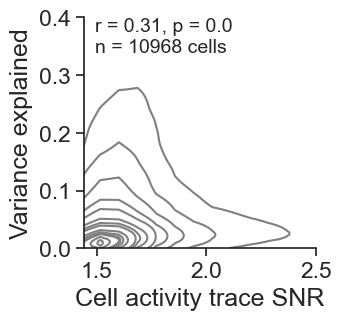

In [ ]:
x = 'robust_snr'
y = 'variance_explained_full'
xlabel = 'Cell activity trace SNR'
ylabel = 'Variance explained'
title = ''

tmp = trace_metrics[trace_metrics.robust_snr<5]
tmp = trace_metrics[trace_metrics.variance_explained_full>0]

plotting.plot_metric_feature_coding_relationship(tmp, x, y, xlabel=xlabel, ylabel=ylabel, title=title, 
                                        xlims=(1.44, 2.5), ylims=(0, 0.4), color_by_cre=False, save_dir=save_dir)

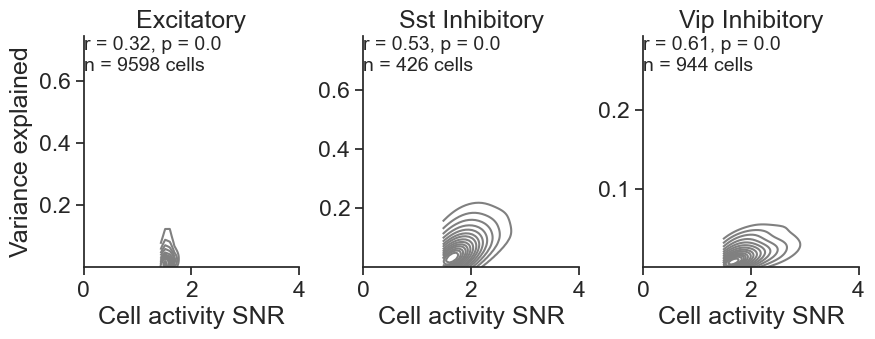

In [ ]:
x = 'robust_snr'
y = 'variance_explained_full'
xlabel = 'Cell activity SNR'
ylabel = 'Variance explained'
title = ''

tmp = trace_metrics[trace_metrics.robust_snr<4]
tmp = trace_metrics[trace_metrics.variance_explained_full>0]

figsize = (10, 3)
fig, ax = plt.subplots(1, 3, figsize=figsize, sharex=False, sharey=False)
for i,cre_line in enumerate(cre_lines): 
    title = utils.convert_cre_line_to_cell_type(cre_line)
    ax[i] = plot_metric_feature_coding_relationship(tmp[tmp.cre_line==cre_line],
                                            x, y, xlabel=xlabel, ylabel=ylabel, title=title, 
                                            xlims=(0,4), ylims=None, color_by_cre=False, ax=ax[i])
    ax[i].set_ylabel('')
ax[0].set_ylabel(ylabel)
plt.subplots_adjust(wspace=0.3)                                            
if save_dir:
    utils.save_figure(fig, figsize, save_dir, 'metric_feature_coding_correlations', x+'_'+y+'_all_cre')